## Feature Extraction

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import softmax
import torch.nn.functional as F
import torchaudio
import torchvision

from pytorch_complex_tensor import ComplexTensor

from models.EfficientNet import EfficientNet

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from speechpy.processing import cmvn, cmvnw
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

import glob
import os
from os import makedirs
from os.path import join, basename, exists, dirname
from tqdm import tqdm
import itertools


In [3]:
MEAN = []
STD = []

In [4]:
def cmvn_global(img1):
    # cropped = cropped - cropped.mean()
    # cropped = cropped / (cropped.std() + 1e-9)\
    # bs x mfcc x time
    m = img1.mean(axis=2)[:, :, np.newaxis]
    s = img1.std(axis=2)[:, :, np.newaxis]

    img1 -= m
    img1 /= s + 1e-9
    return img1

In [5]:
def smooth_one_hot(true_labels: torch.Tensor, classes: int, smoothing=0.0):
    """
    if smoothing == 0, it's one-hot method
    if 0 < smoothing < 1, it's smooth method

    """
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((true_labels.size(0), classes))
    with torch.no_grad():
        true_dist = torch.empty(size=label_shape, device=true_labels.device)
        true_dist.fill_(smoothing / (classes - 1))
        true_dist.scatter_(1, true_labels.data.unsqueeze(1), confidence)
    return true_dist

In [6]:
import torch
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
#https://stackoverflow.com/questions/55681502/label-smoothing-in-pytorch
class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth_one_hot(targets:torch.Tensor, n_classes:int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                    device=targets.device) \
                .fill_(smoothing /(n_classes-1)) \
                .scatter_(1, targets.data.unsqueeze(1), 1.-smoothing)
        return targets

    def forward(self, inputs, targets):
        targets = SmoothCrossEntropyLoss._smooth_one_hot(targets, inputs.size(-1),
            self.smoothing)
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if  self.reduction == 'sum':
            loss = loss.sum()
        elif  self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [7]:
class SignalDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, feats_scp, length_file, mfcc_dir, transform=False, min_max=False, seq_len=500):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
#        self.common_time_len = 500
        time_stretch1 = torchaudio.transforms.TimeStretch(fixed_rate = 2)
        time_stretch2 = torchaudio.transforms.TimeStretch(fixed_rate = 4)
        self.transform_ = torchvision.transforms.RandomApply([time_stretch1, time_stretch2], p=0.5)
        self.STD = np.load("./std.npy")
        self.MEAN = np.load("./mean.npy")
        self.MIN = np.load('./min.npy')
        self.MAX = np.load('./max.npy')
        self.labels = pd.read_csv(csv_file)
        
        self.scplist = read_scpFeature(feats_scp,
                                       orig_path="/home/gazizullina/data/log_mel/audio_train_kaggle/mfcc_cmvn/",
                                       change_path="/home/gazizullina/data/log_mel/audio_train_kaggle/mfcc_cmvn/")
#        df = pd.read_csv(length_file, sep=' ', header=None)
#         df = df[df.loc[:, 1] >= 100]
        files_list_names = [l+'.wav' for l in list(self.scplist.keys())]
        mask = self.labels['fname'].isin(files_list_names)
        self.labels = self.labels[mask]
        self.labels = self.labels.set_index('fname')
        
        self.files_names = [l.replace('.wav', '') for l in list(self.labels.index)]
        self.transform = transform
        self.seq_len = seq_len
        self.min_max = min_max
        #self.files_names = [f for f in self.files_names if os.path.exists(join(self.root_dir, f+'.npy'))]

    def __len__(self):
        return len(self.files_names)

    def __getitem__(self, idx):
        features_idx = self.files_names[idx]
        try:
            features = kaldi_io.read_mat(self.scplist[features_idx]).transpose()
        except AssertionError:
            try:
                features = kaldi_io.read_mat(self.scplist[features_idx].replace("/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", "/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/fbank/")).transpose()
            except:
                return 
        if self.seq_len is not None:
            if self.seq_len<features.shape[-1]:
                x1 = np.random.randint(0, features.shape[-1] - self.seq_len)
                x2 = x1 + self.seq_len
            else:    
                if self.seq_len>features.shape[-1]:
                    while features.shape[-1] < self.seq_len:
                            features = np.repeat(features, 2, axis=1)
                            #features = np.concatenate([features] * 2, axis=-1)
                x1 = 0
                x2 = self.seq_len
            features = features[:, x1:x2]

        if self.transform:
            features = ((features.T - self.MEAN)/self.STD).T
        elif self.min_max:
            features = ((features.T - self.MIN) / (self.MAX - self.MIN)).T
        labels = self.labels.loc[features_idx+'.wav', :]['encoded_labels']
        labels = np.array(labels)
        features = torch.tensor(features).float()
#         features = ComplexTensor(features)
#         features.requires_grad = True
        sample = {'features': features, 'labels': torch.tensor(labels).long(), 'fname': features_idx}

#         if self.transform:
#             sample = self.transform(sample)

        return sample

In [8]:
class BaseLineModel(nn.Module):
    
    def __init__(self, n_classes=41, name='b4'):
        super().__init__()
        if name=='b2':
            self.features = EfficientNet.from_name('efficientnet-b2')
            self.features.load_state_dict(torch.load("./efficientnet-b2-8bb594d6.pth"))
        elif name=='b4':
            self.features = EfficientNet.from_name('efficientnet-b4')
            self.features.load_state_dict(torch.load("./efficientnet-b4-6ed6700e.pth"))
#        self.features._fc =  nn.Linear(1792, n_classes)
#        self.features._fc =  nn.Linear(1792, 512)
#        self.features._fc =  nn.Linear(1408, 512)
        self.features._fc =  nn.Linear(1792, n_classes)
        # use it as features
#         for param in self.features.parameters():
#             param.requires_grad = False
        
    def forward(self, x):
        x, _ = self.features(x)
#       x = x.view(x.shape[0], -1)
#       x = F.relu(x)
#       x = self.fc(x)
        return x
    
    def inference(self, x):
        x = self.forward(x)
        x = F.softmax(x)
        return x

In [9]:
VAR2STD_EPSILON = 0.00001

### TODO: use rely after stat pooling?
### TODO: last layer do we need batchnorm/relu
class E_TDNN3(nn.Module):
    '''
    TODO: check input dimensions and structure and compare to that in https://github.com/hsn-zeinali/x-vector-kaldi-tf/blob/master/local/tf/models.py
    '''
    def __init__(self, num_classes, input_dim=23, dropout_keep_prob=0.5, activation='relu', enable_batch_norm=True, dropout_enable=True, dilation = True, batch_norm_momentum=0.05, batch_norm_eps=1e-03, mode='classification', backbone=False, act_params={}):
        super(E_TDNN3, self).__init__()
        '''
        frame level: number of convolutions = number of frames,
        input size = (128-batch size, 23 - mfcc feature size, 1935 ms - number of frames)
        '''
        '''
        design from http://www.danielpovey.com/files/2019_interspeech_xvector_refinement.pdf
        '''
        #self.layer_sizes = [512, 512, 512, 512, 1500]
        self.layer_sizes = [128, 128, 256, 256, 256, 512, 512]
        self.kernel_sizes = [5, 1, 3, 1, 3, 1, 1]
        self.strides = [1, 1, 1, 1, 1, 1, 1]
        self.embedding_sizes = [512]
        self.dilation_rates = [1, 1, 2, 1, 3, 1, 1]
        self.dilation = dilation
        self.num_classes = num_classes
        self.input_feature_dim = input_dim
        self.dropout_keep_prob = dropout_keep_prob
        self.enable_batch_norm = enable_batch_norm
        self.dropout_enable = dropout_enable
        self.batch_norm_momentum = batch_norm_momentum
        self.batch_norm_eps = batch_norm_eps
        self.frame_level_conv_block_len = 0
        self.embeddings_block_len = 0
        self.activation = nn.ReLU()
        self.backbone = backbone
        self.activation = nn.__dict__[activation](**act_params)
        '''
        frame level convolutional block
        '''
        prev_dim = self.input_feature_dim
        self.mode = mode

        self.frame_level_conv_block = nn.ModuleList([])
        for idx, (kernel_size, layer_size) in enumerate(zip(self.kernel_sizes, self.layer_sizes)):
            print("check", prev_dim, layer_size, kernel_size, kernel_size // 2)
            if not self.dilation:
                self.frame_level_conv_block.append(
                     nn.Sequential(nn.Conv1d(prev_dim, layer_size, kernel_size, stride=1, padding=(kernel_size // 2), bias=0.1), self.activation, nn.BatchNorm1d(layer_size, affine=False)))
            else:
                self.frame_level_conv_block.append(
                    nn.Sequential(
                        nn.Conv1d(prev_dim, layer_size, kernel_size, dilation=self.dilation_rates[idx], stride=1, padding=(kernel_size // 2), bias=0.1),
                        self.activation, nn.BatchNorm1d(layer_size, affine=False)))
            ###########nn.init.kaiming_normal(self.frame_level_conv_block[-1][0].weight)
            prev_dim = layer_size
            self.frame_level_conv_block_len += 1

        prev_dim = prev_dim * 2
        #prev_dim = 2
        '''
        embedding layers
        '''
        self.embeddings_block = nn.ModuleList([])
        for i, out_dim in enumerate(self.embedding_sizes):
            self.embeddings_block.append(
                nn.Sequential(
                    nn.Linear(prev_dim, out_dim, bias=0.1),
                    self.activation,
                    nn.BatchNorm1d(out_dim, affine=True)
                ))
            prev_dim = out_dim
            self.embeddings_block_len+=1
        # if self.mode == 'classification':
        #     self.out = nn.Linear(prev_dim, num_classes, bias=0.1)
        # elif self.mode == 'angular':
        #     self.out = AngleLinear(prev_dim, num_classes, m, phiflag)
        self.out = nn.Linear(prev_dim, num_classes, **params)
        self.dropout = nn.Dropout(self.dropout_keep_prob)
    
    def forward(self, x, y=None, volatile=False):
        '''
        frame level
        '''
        x = x
        for idx in range(self.frame_level_conv_block.__len__()):
            x = self.frame_level_conv_block[idx](x)
            if self.dropout_enable:
                if idx!=len(self.kernel_sizes)-1:
                    x = self.dropout(x)
                    
        '''
        statistic pooling
        '''
        mean, std = x.mean(dim=2), x.std(dim=2)
        x = torch.cat([mean, std], 1)
        '''
        embedding layer
        '''
        embs = []
        for idx in range(self.embeddings_block.__len__()):
            x = self.embeddings_block[idx](x)
            if idx == self.embeddings_block.__len__() - 1:
                embs.append(x)
            if idx == self.embeddings_block.__len__() - 2:
                embs.append(x)
            if self.dropout_enable:
                if idx!=len(self.kernel_sizes)-1:
                    x = self.dropout(x)
        
        if self.out is not None:
            x = self.out(x)
        if not volatile:
            return x
        else:
            return embs[-1], x

In [10]:
BEST_VAL_ACC = 0

In [11]:
def validate(loader, model, criterion, optimizer=None, save_pth=None, kl_criterion=None, alpha=0.8, mode=''):
    model.eval()
    with torch.no_grad():
        loss_value = 0
        accuracy_value = 0
        kl_list = []
        for batch in tqdm(loader, total=loader.__len__()):
            labels, features = batch['labels'], batch['features']
            if isinstance(model, EfficientNet) \
            or isinstance(model, torchvision.models.resnet.ResNet) \
            or isinstance(model, BaseLineModel):
                features = features.unsqueeze(1)
                if isinstance(model, EfficientNet) or isinstance(model, torchvision.models.resnet.ResNet) \
                or isinstance(model, BaseLineModel):
                    #features = torch.cat([features] * 4, axis=2)
                    features = features.repeat_interleave(3, axis=1)
            features_var = Variable(features).cuda(0)
            labels_var = Variable(labels).cuda(0)

            out = model(features_var)
            loss_out = criterion(out, labels_var)
            
            loss_sing = loss_out.item()
            loss_value += loss_sing

            predicted_y = softmax(out, dim=1).data
            predicted_y = predicted_y.argmax(1)

            acc = predicted_y.eq(labels_var).float().mean().item()
            accuracy_value+=acc
    global BEST_VAL_ACC
    if accuracy_value/loader.__len__()>BEST_VAL_ACC and optimizer is not None:
        BEST_VAL_ACC = accuracy_value/loader.__len__()
        state = {
             'model': model.state_dict(),
             'optimizer': optimizer.state_dict()
             }
        torch.save(state, save_pth.replace('.pth', '_val_best.pth'))

    return accuracy_value/loader.__len__(), loss_value/loader.__len__()

In [12]:
def train(x_vec, train_dataset_loader, valid_dataset_loader, criterion, optimizer, kl_criterion=None, alpha=0.8, save_pth = '', mode=''):
    best_acc = 0
    for epoch in range(10000):
        loss_value = 0
        accuracy_value = 0
        kl_list = []
        for batch in tqdm(train_dataset_loader, total=train_dataset_loader.__len__()):
            optimizer.zero_grad()
            labels, features = batch['labels'], batch['features']
            if isinstance(x_vec, EfficientNet) \
            or isinstance(x_vec, torchvision.models.resnet.ResNet) \
            or isinstance(x_vec, BaseLineModel):
                features = features.unsqueeze(1)
                if isinstance(x_vec, EfficientNet) \
                or isinstance(x_vec, torchvision.models.resnet.ResNet) \
                or isinstance(x_vec, BaseLineModel):
                    #bs x 1 x mfcc x time
                    #features = torch.cat([features] * 4, axis=2)
                    features = features.repeat_interleave(3, axis=1)
                
            features_var = Variable(features).cuda(0)
            labels_var = Variable(labels).cuda(0)
            

            out = x_vec(features_var)

            loss_out = criterion(out, labels_var)
        
            loss_out.backward()
            torch.nn.utils.clip_grad_norm_(x_vec.parameters(), 1)
            optimizer.step()
            
            loss_sing = loss_out.item()
            loss_value += loss_sing

            predicted_y = softmax(out, dim=1).data
            predicted_y = predicted_y.argmax(1)  
            
            acc = predicted_y.eq(labels_var).float().mean().item()
            accuracy_value+=acc
        acc_val, loss_val = validate(valid_dataset_loader, x_vec, criterion, kl_criterion=kl_criterion, alpha=alpha, mode=mode, optimizer=optimizer, save_pth=save_pth)
                    
        if acc_val > best_acc:
            best_acc = acc_val
            model_state_dict = x_vec.state_dict()
            state = {
             'model': model_state_dict,
             'epoch': epoch,
             'optimizer': optimizer.state_dict()
             }
            torch.save(state, save_pth)
        state = {
             'model': model_state_dict,
             'epoch': epoch,
             'optimizer': optimizer.state_dict()
             }
        torch.save(state, save_pth.replace('.pth', '_last.pth'))
        print("Epoch {}, loss {}, acc {}, val loss {}, val acc {}".format(epoch, loss_value/train_dataset_loader.__len__(), 
                                                 accuracy_value/train_dataset_loader.__len__(), 
                                                  loss_val, acc_val))

In [13]:
def read_scpFeature(file_scp_feature, orig_path, change_path, conditional_list=None):
    map_res = {}
    fd = open(file_scp_feature, 'r')
    try:
        for line in tqdm(fd):
            (key, rxfile) = line.split(' ')
            name = os.path.basename(key)
            rxfile = rxfile.replace(orig_path, change_path)
            map_res[key] = rxfile
            # yield key, mat
    finally:
        fd.close()

    return map_res

### Prepare Features

In [14]:
from python_kaldi.core.nn_vad_extractor import NNVADExtractor
from python_kaldi.core.mfcc_extractor import MFCCExtractor
from python_kaldi.utils.meta_generators import scp, spk2utt
from python_kaldi.core.fbank_extractor import FbankExtractor
from python_kaldi.core.vad_extractor import VADExtractor
from python_kaldi_ import kaldi_io

In [15]:
#home/gazizullina/Рабочий стол/ЦОС/audio_train/audio_train/train/80ddf53943e3ebff95b3.wav
wav_dir = "/home/gazizullina/data/audio_train/audio_test/test/"
work_dir = '/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/'

wav_scp = os.path.join(work_dir, 'wav.scp')
utt2spk_path = os.path.join(work_dir, 'utt2spk')
spk2utt_path = os.path.join(work_dir, 'spk2utt')

wav_lst = glob.glob(os.path.join(wav_dir, '*.wav'))
ids_lst = list(map(lambda x: basename(x).replace('.wav', ''), wav_lst))

In [142]:
scp.generate_scp_by_wav_list(wav_list=wav_lst, wav_scp_path=wav_scp, sample_rate=16000)
spk2utt.generate_id2id(ids_lst, spk2utt_path, utt2spk_path)

In [172]:
DEFAULT_Fbank_SETTINGS_16k = {
    'sample-frequency': 16000,
    'window-type': 'rectangular',
    'frame-length': 20,
    'frame-shift': 10,
    'use_log_fbank': 'true',
    'low-freq': 20,
    'high-freq': 7600,
    'num-mel-bins': 80,
    'snip-edges': 'false',
    'use-energy': 'true'
}
feat_ext = FbankExtractor(sample_rate=16000, fbank_settings=DEFAULT_Fbank_SETTINGS_16k)

In [173]:
feat_ext.extract(work_dir=work_dir)

2020-05-16 16:03:48,670 - python_kaldi.py_wrappers.c_src_wrapper - INFO - Raw features extracted. Store target feats.scp in: /home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/feats.scp


In [176]:
feat_ext.cmvn(work_dir=work_dir, feats_spc_path=os.path.join(work_dir, 'fbank', 'feats.scp'),
              apply_vad=False)

2020-05-16 16:04:05,970 - python_kaldi.py_wrappers.c_src_wrapper - INFO - CMVN normalization applied. Store target feats.scp in: /home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/feats.scp


3790it [00:00, 407778.06it/s]


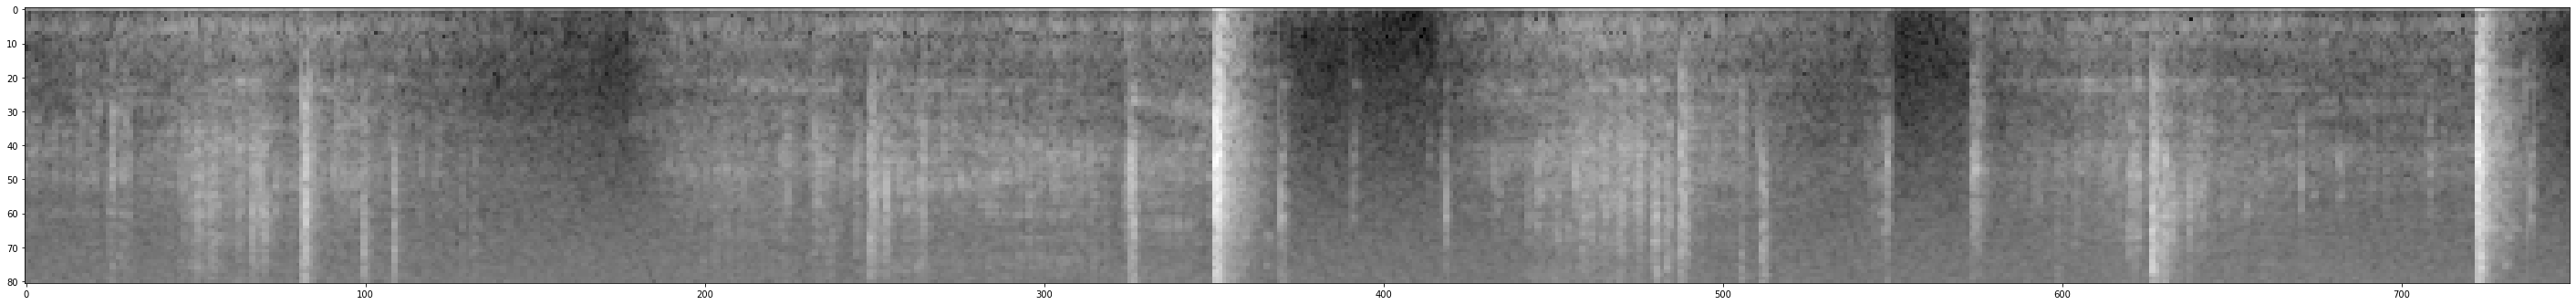

In [20]:
scplist = read_scpFeature("/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/fbank/feats.scp",
                          orig_path="/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/fbank/", 
                          change_path="/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/fbank/")
feats = pd.read_csv("/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/fbank/feats.scp", header=None, sep=' ')
filenames = feats.loc[:, 0].values
img = kaldi_io.read_mat(scplist[filenames[89]]).transpose()
plt.figure(figsize=(50,50))
plt.imshow(img[:, :], cmap="gray")

## Data Split

In [33]:
labels = pd.read_csv("./train.csv")
sample_submission = pd.read_csv("./sample_submission.csv")
labels_names = labels["label"].values

In [81]:
le = preprocessing.LabelEncoder()
encoded_labels = le.fit_transform(labels_names)
with open('./label_encoder.pkl', 'wb') as f:
     pickle.dump(le, f)
with open('./label_encoder.pkl', 'rb') as f:
     enc = pickle.load(f)

In [109]:
enc.inverse_transform([0, 4, 5])
#le.classes_

array(['Acoustic_guitar', 'Burping_or_eructation', 'Bus'], dtype=object)

In [83]:
labels['encoded_labels'] = encoded_labels

In [84]:
len(np.unique(labels['encoded_labels'].values))

41

In [85]:
y_train, y_valid = train_test_split(labels, test_size=0.1, random_state=42)

In [86]:
len(np.unique(y_train['encoded_labels'].values))

41

In [87]:
y_valid, y_test = train_test_split(y_valid, test_size=0.3, random_state=42)

In [88]:
len(y_train), len(y_test), len(y_valid)

(5114, 171, 398)

In [89]:
y_train.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv")
y_valid.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_valid.csv")
y_test.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_test.csv")

In [93]:
sample_submission['encoded_labels'] = np.zeros(len(sample_submission))

In [94]:
sample_submission.to_csv("/home/gazizullina/Рабочий стол/ЦОС/sample_submission.csv")

ensure there are no intersections of train and test

In [45]:
a = pd.read_csv("/home/gazizullina/Рабочий стол/ЦОС/sample_submission.csv")
b = pd.read_csv("./train.csv")
list(set(a['fname'].values)&set(b["fname"].values))

[]

### EDA

In [49]:
train_dataset = SignalDataset(y_train, "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/feats.scp", 
                              "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/utt2num_frames", 
                              "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", seq_len=500)
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=train_dataset.__len__(), shuffle=True,
                                             num_workers=1)

5683it [00:00, 803865.83it/s]


In [51]:
for batch in tqdm(train_dataset_loader, total=train_dataset_loader.__len__()):
        labels, features = batch['labels'], batch['features']
        np.save('./mean.npy', features.mean(axis=(0, 2)))
        np.save('./std.npy', features.std(axis=(0, 2)))
        np.save('./min.npy', features.numpy().min(axis=(0, 2)))
        np.save('./max.npy', features.numpy().max(axis=(0, 2)))

100%|██████████| 1/1 [00:08<00:00,  8.23s/it]


(array([6.9000000e+01, 6.8260000e+03, 7.2410700e+05, 8.7708890e+06,
        3.7870012e+07, 6.9568781e+07, 5.2300361e+07, 3.0230797e+07,
        5.0227580e+06, 6.5400000e+04]),
 array([-10.687491 ,  -6.4759994,  -2.2645078,   1.9469842,   6.158476 ,
         10.369968 ,  14.58146  ,  18.792952 ,  23.004444 ,  27.215935 ,
         31.427427 ], dtype=float32),
 <a list of 10 Patch objects>)

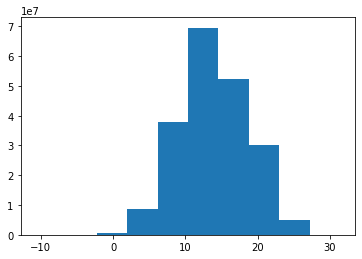

In [52]:
plt.hist(features[:, :, :].flatten())

In [53]:
features.max(), features.min()

(tensor(31.4274), tensor(-10.6875))

In [63]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=128, shuffle=True,
                                             num_workers=4)

valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=valid_dataset.__len__(), shuffle=True,
                                             num_workers=4)

test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=test_dataset.__len__(), shuffle=True,
                                             num_workers=4)

check for class imbalance

In [23]:
train_csv = pd.read_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv")
train_classes = list(sorted(train_csv['encoded_labels'].values))
unique, counts = np.unique(train_classes, return_counts=True)
unque_counts = np.asarray((unique, counts))
unque_counts = unque_counts[1]
n_samp = 5120
b = (n_samp-1)/n_samp
unque_counts_weights = [(1-b)/(1-b**i) for i in unque_counts]
norm_factor = sum(unque_counts_weights)
unque_counts_weights = [i/norm_factor for i in unque_counts_weights]

In [24]:
unque_counts

array([175, 166, 137, 169, 101,  59, 168,  73, 158,  58, 145, 105, 167,
        85,  75, 173,  73, 163, 175,  53, 159,  78,  72, 166,  68, 127,
       155,  89,  78, 148, 158,  53, 168, 159, 153, 125, 142,  69, 175,
       149, 145])

In [25]:
unque_counts_weights

[0.014963371996672787,
 0.015760856357784476,
 0.01904334971190033,
 0.015485589680966161,
 0.025740767155882308,
 0.043884790350804455,
 0.015576252814390488,
 0.035516954879278174,
 0.016546009749619672,
 0.04463707324278457,
 0.018006681210309967,
 0.02476980882920568,
 0.01566800183185975,
 0.030538474407361023,
 0.03457657305191165,
 0.015133419380531957,
 0.035516954879278174,
 0.016046256454106577,
 0.014963371996672787,
 0.048824312840660015,
 0.01644354440263005,
 0.03325642321445991,
 0.036006737422074615,
 0.015760856357784476,
 0.03810992368968613,
 0.020522858681551168,
 0.01686133922527934,
 0.029177322710989412,
 0.03325642321445991,
 0.017646825979373414,
 0.016546009749619672,
 0.048824312840660015,
 0.015576252814390488,
 0.01644354440263005,
 0.01707842933386754,
 0.020847168619157228,
 0.01838174262932741,
 0.037561266046611294,
 0.014963371996672787,
 0.01753009463648419,
 0.018006681210309967]

### Creating lists for self-training

In [ ]:
y_train = "/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv"
y_valid = "/home/gazizullina/Рабочий стол/ЦОС/labels_valid.csv"
y_test = "/home/gazizullina/Рабочий стол/ЦОС/labels_test.csv"

In [ ]:
y_train_df = pd.read_csv(y_train)
y_valid_df = pd.read_csv(y_valid)
y_test_df = pd.read_csv(y_test)
train_all = pd.concat([y_train_df, y_valid_df, y_test_df])
train_all.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train_all_.csv")

In [ ]:
y_train_df = pd.read_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train_and_valid_all_.csv")
y_test_df = pd.read_csv('./draft_submission.csv')
with open('./label_encoder.pkl', 'rb') as f:
     enc = pickle.load(f)
outs_2_names = enc.transform(y_test_df['label'].values)
y_test_df["encoded_labels"] = outs_2_names
train_all = pd.concat([y_train_df, y_test_df])
train_all.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train_all_self.csv")

In [ ]:
y_train_df = pd.read_csv(y_train)
y_valid_df = pd.read_csv(y_valid)
train_all = pd.concat([y_train_df, y_valid_df])
train_all.to_csv("/home/gazizullina/Рабочий стол/ЦОС/labels_train_and_valid_all_.csv")

### Experiments. Model training

In [25]:
y_train = "/home/gazizullina/Рабочий стол/ЦОС/labels_train.csv"
y_valid = "/home/gazizullina/Рабочий стол/ЦОС/labels_valid.csv"
y_test = "/home/gazizullina/Рабочий стол/ЦОС/labels_test.csv"

In [26]:
train_dataset = SignalDataset(y_train, "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/feats.scp", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/utt2num_frames", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", seq_len=500)
valid_dataset = SignalDataset(y_valid, "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/feats.scp", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/utt2num_frames", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", seq_len=500)
test_dataset = SignalDataset(y_test, "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/feats.scp", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/utt2num_frames", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", seq_len=500)
# train_dataset = SignalDataset("/home/gazizullina/Рабочий стол/ЦОС/labels_train_all_self.csv", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/feats.scp", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/utt2num_frames", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", seq_len=500)
# valid_dataset = SignalDataset(y_test, "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/feats.scp", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/utt2num_frames", "/home/gazizullina/data/log_mel/audio_train_kaggle_mfb80/fbank/", seq_len=500)

5683it [00:00, 757740.08it/s]
5683it [00:00, 805931.49it/s]
5683it [00:00, 801110.09it/s]


In [27]:
train_dataset_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=50, shuffle=True,
                                             num_workers=4)

valid_dataset_loader = torch.utils.data.DataLoader(valid_dataset,
                                             batch_size=50, shuffle=True,
                                             num_workers=4)

# test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
#                                              batch_size=38, shuffle=True,
#                                              num_workers=4)

In [28]:
# eff_net = EfficientNet.from_name('efficientnet-b2', override_params={'num_classes':41, 'image_size': [80, 1500]})
# import torchvision.models as models
# resnet34 = models.resnet34(num_classes=41)
# x_vec = E_TDNN3(41, input_dim=80, dropout_keep_prob=0.5,
#                 activation= "LeakyReLU", enable_batch_norm=True, dropout_enable=True, 
#                 dilation = True, batch_norm_momentum=0.05, batch_norm_eps=1e-03, act_params={"negative_slope":0.2})
bs_model = BaseLineModel(name='b4')

In [34]:
#criterion = nn.CrossEntropyLoss()
criterion = SmoothCrossEntropyLoss(smoothing=0.0)
#criterion = nn.CrossEntropyLoss(weight=torch.tensor(unque_counts_weights))

In [42]:
#optimizer = torch.optim.AdamW(bs_model.parameters(), lr=0.0001, weight_decay=5e-6)
#optimizer = torch.optim.SGD(bs_model.parameters(), lr=0.1)
#optimizer = torch.optim.SGD(resnet34.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-6, nesterov=True)
#optimizer = torch.optim.SGD(x_vec.parameters(), lr=0.0001, momentum=0.9, weight_decay=5e-6, nesterov=False)
optimizer = torch.optim.Adam(bs_model.parameters(), lr=0.0001)

In [36]:
criterion.cuda(0)

SmoothCrossEntropyLoss()

#### 1. Load weights of previously trained model

In [38]:
# dict_t = torch.load('./best_model_x_vec_net__last.pth')
# optimizer.load_state_dict(dict_t['optimizer'])

# for state in optimizer.state.values():
#     for k, v in state.items():
#         if isinstance(v, torch.Tensor):
#             state[k] = v.cuda()

# # eff_net.load_state_dict(dict_t['model'])
# for g in optimizer.param_groups:
#     g['lr'] = 0.0005
#     g['weight_decay'] = 5e-5

#### 2. Train

In [ ]:
bs_model.cuda(0)

In [ ]:
#model_eff = train(eff_net, train_dataset_loader, valid_dataset_loader, criterion, optimizer, save_pth='./best_model_efficient_net.pth')
#x_vec = train(x_vec, train_dataset_loader, valid_dataset_loader, criterion, optimizer, save_pth='./best_model_x_vec_net_weight.pth')
#model_eff = train(resnet34, train_dataset_loader, valid_dataset_loader, criterion, optimizer, save_pth='./best_model_resnet34.pth')
bs_model = train(bs_model, train_dataset_loader, valid_dataset_loader, criterion, optimizer, save_pth='./best_model_bs_model_weight_adam_1500.pth')

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 0, loss 0.06706802982348696, acc 0.9796116311573287, val loss 1.3241566866636276, val acc 0.7861458212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1, loss 0.027228268227667534, acc 0.9930096963076915, val loss 1.373071439564228, val acc 0.7966666594147682


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2, loss 0.025726737314007816, acc 0.9935922223387412, val loss 1.529622495174408, val acc 0.7867708057165146


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3, loss 0.01456597790807279, acc 0.9965048484431888, val loss 1.4263953790068626, val acc 0.8092708140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4, loss 0.012801170652433162, acc 0.995145622966359, val loss 1.392914704978466, val acc 0.8165624812245369


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5, loss 0.012226490040826956, acc 0.9961164987202987, val loss 1.590683028101921, val acc 0.7837499901652336


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6, loss 0.015685697961937, acc 0.9944521402849734, val loss 1.6992926970124245, val acc 0.7835416570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7, loss 0.012022943997492106, acc 0.9959223235695107, val loss 1.6362374797463417, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8, loss 0.01124890149181623, acc 0.9963106732924008, val loss 1.7427944242954254, val acc 0.781979151070118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9, loss 0.011040782707242807, acc 0.9961164987202987, val loss 1.7997117787599564, val acc 0.7917708307504654


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10, loss 0.0038305667095539443, acc 0.9990291242460603, val loss 1.7775536328554153, val acc 0.7639583125710487


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11, loss 0.007534610705078138, acc 0.9976698987692305, val loss 1.696741834282875, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12, loss 0.009236046950409395, acc 0.9980582484921205, val loss 1.583554670214653, val acc 0.7912499830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13, loss 0.007281486282770909, acc 0.9978640733413326, val loss 1.9902126677334309, val acc 0.791562482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14, loss 0.00595560666203116, acc 0.9976698981905446, val loss 1.846635416150093, val acc 0.7813541665673256


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15, loss 0.011359650116960924, acc 0.9966990230152908, val loss 1.7853983491659164, val acc 0.788854144513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16, loss 0.006849747355915608, acc 0.9980582484921205, val loss 1.7921215146780014, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17, loss 0.009439635984244778, acc 0.9978640744987043, val loss 1.793484091758728, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18, loss 0.003841993507617013, acc 0.9990291242460603, val loss 1.9104322344064713, val acc 0.7769791558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19, loss 0.005380733149808982, acc 0.9984465987936965, val loss 1.9478471130132675, val acc 0.7838541567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20, loss 0.004872521399292533, acc 0.9984465987936965, val loss 1.9329219833016396, val acc 0.7890624850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21, loss 0.0040290860065502485, acc 0.9986407739444844, val loss 1.9578807801008224, val acc 0.788854144513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22, loss 0.003432579310591711, acc 0.9992232993968482, val loss 1.9590523540973663, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23, loss 0.008483284383237236, acc 0.9976698981905446, val loss 1.9175053238868713, val acc 0.791562482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24, loss 0.004710720563269253, acc 0.9982524236429084, val loss 1.9609495103359222, val acc 0.7987499833106995


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25, loss 0.007078500865588818, acc 0.9974757230397567, val loss 1.931683525443077, val acc 0.7786458283662796


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26, loss 0.007293442492079832, acc 0.9978640739200184, val loss 1.8385132774710655, val acc 0.7817708179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27, loss 0.007140125715482464, acc 0.9978640733413326, val loss 1.8618763908743858, val acc 0.794270820915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28, loss 0.0034559511916307083, acc 0.9994174745476362, val loss 2.0114210471510887, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29, loss 0.006632728261055438, acc 0.9986407745231702, val loss 1.7992329001426697, val acc 0.8045833259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30, loss 0.002035222313601123, acc 0.9992232993968482, val loss 1.990015909075737, val acc 0.7890624776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31, loss 0.00966841101846079, acc 0.9986407739444844, val loss 1.9933750182390213, val acc 0.7990624830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32, loss 0.007069689774072851, acc 0.9980582484921205, val loss 2.0324197709560394, val acc 0.7990624830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33, loss 0.006240265540817664, acc 0.9980582490708064, val loss 2.057749181985855, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34, loss 0.004902075570724014, acc 0.9984465987936965, val loss 1.892642691731453, val acc 0.7818749845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35, loss 0.0028638871217899257, acc 0.9988349490952724, val loss 2.0263969004154205, val acc 0.7940624803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36, loss 0.005632835171883333, acc 0.9984465993723823, val loss 2.1054148077964783, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37, loss 0.00815524040876922, acc 0.9980582484921205, val loss 1.8894522227346897, val acc 0.7890624850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38, loss 0.006258624565785191, acc 0.9980582484921205, val loss 2.069738492369652, val acc 0.8012499809265137


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39, loss 0.006167432433767779, acc 0.9980582490708064, val loss 2.036922909319401, val acc 0.7915624752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40, loss 0.0030205183644464724, acc 0.9988349490952724, val loss 2.0175517350435257, val acc 0.7917708158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41, loss 0.004710491760586994, acc 0.9984465987936965, val loss 1.888416662812233, val acc 0.7989583164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42, loss 0.006795414061334243, acc 0.9980582490708064, val loss 2.0139826238155365, val acc 0.7990624830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43, loss 0.00517599407223105, acc 0.9984465987936965, val loss 2.060271978378296, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44, loss 0.0023638135786164857, acc 0.9994174745476362, val loss 2.179228648543358, val acc 0.7944791540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45, loss 0.0020048089472670264, acc 0.9996116496984241, val loss 2.1278867721557617, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46, loss 0.010703102399840647, acc 0.9984465987936965, val loss 1.9699956327676773, val acc 0.7914583161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47, loss 0.0019979863065748968, acc 0.9992232993968482, val loss 2.037065640091896, val acc 0.7962499856948853


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48, loss 0.004886172545928757, acc 0.9988349490952724, val loss 2.12726891040802, val acc 0.7886458188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49, loss 0.0065534180064149945, acc 0.9980582484921205, val loss 2.215188130736351, val acc 0.7738541662693024


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50, loss 0.0075680532760876214, acc 0.9980582484921205, val loss 2.073018290102482, val acc 0.8086458146572113


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 51, loss 0.00393909104478289, acc 0.9983356433007323, val loss 2.227125458419323, val acc 0.7885416522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 52, loss 0.0028135232210831926, acc 0.9990291242460603, val loss 2.1211471930146217, val acc 0.7966666519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 53, loss 0.003544241563404544, acc 0.9992232993968482, val loss 2.3705147951841354, val acc 0.791458323597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 54, loss 0.0015426763248143308, acc 0.9994174745476362, val loss 2.2495017424225807, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 55, loss 0.008969411172020186, acc 0.9986407751018561, val loss 2.103181704878807, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 56, loss 0.0018061578324576862, acc 0.9996116496984241, val loss 2.2245558351278305, val acc 0.778541661798954


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 57, loss 0.0046126768218203995, acc 0.9996116496984241, val loss 2.3368758857250214, val acc 0.7912499755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 58, loss 0.004550825281318048, acc 0.9994174745476362, val loss 2.2602363973855972, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 59, loss 0.0015843397679254512, acc 0.9990291242460603, val loss 2.2488742768764496, val acc 0.7920833230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 60, loss 0.004071435189864959, acc 0.9992232993968482, val loss 2.2475702464580536, val acc 0.7914583161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 61, loss 0.0036916669242657947, acc 0.9988349490952724, val loss 2.3106001168489456, val acc 0.781354159116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 62, loss 0.003572713752730198, acc 0.9988349490952724, val loss 2.0157424360513687, val acc 0.8035416528582573


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 63, loss 0.0025290735477792444, acc 0.9990291242460603, val loss 2.251123510301113, val acc 0.77364581823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 64, loss 0.0028485054394738456, acc 0.9994174745476362, val loss 2.4002134650945663, val acc 0.8013541549444199


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 65, loss 0.0027660257818658256, acc 0.9992232993968482, val loss 2.2193949669599533, val acc 0.7818749770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 66, loss 0.00046929976106093016, acc 1.0, val loss 2.571306936442852, val acc 0.7562499865889549


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 67, loss 0.00528577018405071, acc 0.9984465987936965, val loss 2.199882596731186, val acc 0.7834374830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 68, loss 0.0016598770880435567, acc 0.9992232993968482, val loss 2.546868920326233, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 69, loss 0.004646636337863855, acc 0.9990291242460603, val loss 2.4849685207009315, val acc 0.7787499874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 70, loss 0.002194006936331795, acc 0.9992232993968482, val loss 2.2454927302896976, val acc 0.8038541525602341


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 71, loss 0.0026992568914333557, acc 0.9992232993968482, val loss 2.4729851484298706, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 72, loss 0.003728122659862141, acc 0.9992232993968482, val loss 2.3124964088201523, val acc 0.8062499761581421


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 73, loss 0.002291653985810589, acc 0.9994174745476362, val loss 2.5156469494104385, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 74, loss 0.002603032829715774, acc 0.9988349490952724, val loss 2.2046131938695908, val acc 0.799270823597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 75, loss 0.003032688918566965, acc 0.9990291242460603, val loss 2.1848987489938736, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 76, loss 0.002124829066855931, acc 0.9992232993968482, val loss 2.2691177502274513, val acc 0.7962499707937241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 77, loss 0.0060343415302486865, acc 0.9984465987936965, val loss 2.4451060593128204, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 78, loss 0.0021210080468666453, acc 0.9996116496984241, val loss 2.314039148390293, val acc 0.8046874776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 79, loss 0.0055599621092751045, acc 0.9984465987936965, val loss 2.57334104180336, val acc 0.788854144513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 80, loss 0.006483603889367463, acc 0.9994174745476362, val loss 2.320984110236168, val acc 0.7789583131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 81, loss 0.0010426695140199958, acc 0.9998058248492121, val loss 2.4952007308602333, val acc 0.7936458215117455


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 82, loss 0.0014045354823234446, acc 0.9994174745476362, val loss 2.452707566320896, val acc 0.783749982714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 83, loss 0.01628514898926225, acc 0.9987239936023082, val loss 2.4234055429697037, val acc 0.7839583232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 84, loss 0.004763171405815073, acc 0.9984465993723823, val loss 2.028559111058712, val acc 0.7959374859929085


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 85, loss 0.002142496388569474, acc 0.9994174745476362, val loss 2.0223693251609802, val acc 0.8061458170413971


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 86, loss 0.007273846525508904, acc 0.9990291242460603, val loss 1.9460059255361557, val acc 0.7912499755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 87, loss 0.0021543961269232786, acc 0.9988349496739583, val loss 2.268041431903839, val acc 0.7883333191275597


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 88, loss 0.0024912143509142302, acc 0.9992232993968482, val loss 2.3029570430517197, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 89, loss 0.0026167341320940812, acc 0.9988349490952724, val loss 2.211434304714203, val acc 0.8062499836087227


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 90, loss 0.003198958341484536, acc 0.9994174745476362, val loss 2.192979797720909, val acc 0.8092708140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 91, loss 0.0058310709254683546, acc 0.9984465987936965, val loss 2.222756505012512, val acc 0.8119791597127914


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 92, loss 0.0022743283045615725, acc 0.9994174745476362, val loss 2.4993760138750076, val acc 0.8039583191275597


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 93, loss 0.0035833007686791613, acc 0.9996116496984241, val loss 2.147000215947628, val acc 0.8087499812245369


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 94, loss 0.0007508796631335436, acc 0.9998058248492121, val loss 2.4630125761032104, val acc 0.8042708188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 95, loss 0.0006974113527769387, acc 0.9994174745476362, val loss 2.2762624323368073, val acc 0.8061458095908165


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 96, loss 0.000908536511096731, acc 0.9998058248492121, val loss 2.311858907341957, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 97, loss 0.0003437251015585757, acc 1.0, val loss 2.373692810535431, val acc 0.7943749874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 98, loss 0.001201653820650754, acc 0.9992232993968482, val loss 2.271723121404648, val acc 0.7988541573286057


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 99, loss 0.005379082153069806, acc 0.9988349490952724, val loss 2.1519663333892822, val acc 0.7987499758601189


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 100, loss 0.003155607688178877, acc 0.9992232993968482, val loss 2.218688115477562, val acc 0.8146874755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 101, loss 0.005772248606681412, acc 0.9990291242460603, val loss 2.067568190395832, val acc 0.8094791546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 102, loss 0.001739857975420416, acc 0.9992232993968482, val loss 2.2131053507328033, val acc 0.7940624803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 103, loss 0.0035210997517643844, acc 0.9986407739444844, val loss 2.135008320212364, val acc 0.8014583140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 104, loss 0.0009820426283869128, acc 0.9996116496984241, val loss 2.2952950298786163, val acc 0.7939583137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 105, loss 0.001370189673280071, acc 0.9994174745476362, val loss 2.4005560874938965, val acc 0.7891666516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 106, loss 0.000761069353936933, acc 0.9996116496984241, val loss 2.340981215238571, val acc 0.7964583188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 107, loss 0.0024484940503780098, acc 0.9994174745476362, val loss 2.638481095433235, val acc 0.7889583110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 108, loss 0.004109089538832692, acc 0.9992232993968482, val loss 2.538522481918335, val acc 0.8062499761581421


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 109, loss 0.0038198597263072323, acc 0.9992232993968482, val loss 2.6587355881929398, val acc 0.7989583164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 110, loss 0.004216278522700275, acc 0.9990291242460603, val loss 2.849980726838112, val acc 0.7838541567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 111, loss 0.009671016883097995, acc 0.9982524248002802, val loss 2.145653873682022, val acc 0.8063541501760483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 112, loss 0.002956554447924655, acc 0.9988349490952724, val loss 2.2464817985892296, val acc 0.8033333122730255


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 113, loss 0.011629996428850955, acc 0.9981414681499444, val loss 2.1893680542707443, val acc 0.7963541448116302


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 114, loss 0.0018474497879876913, acc 0.9998058248492121, val loss 2.3914382308721542, val acc 0.7867708131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 115, loss 0.0039035749899407916, acc 0.9994174745476362, val loss 2.3490400314331055, val acc 0.781354159116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 116, loss 0.002960593960055153, acc 0.999223299975534, val loss 2.32774156332016, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 117, loss 0.0030365915205815457, acc 0.9992232993968482, val loss 2.386052429676056, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 118, loss 0.007415429962813867, acc 0.9986407739444844, val loss 2.1376634016633034, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 119, loss 0.006769501131724878, acc 0.9990291242460603, val loss 2.1811071634292603, val acc 0.7967708185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 120, loss 0.0012133694495002519, acc 0.9998058248492121, val loss 2.0079500526189804, val acc 0.7868749871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 121, loss 0.001194369302743988, acc 0.9996116496984241, val loss 2.2328175008296967, val acc 0.796666644513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 122, loss 0.0014421769232943486, acc 0.9992232993968482, val loss 2.126918137073517, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 123, loss 0.004783168277043442, acc 0.9992232993968482, val loss 2.2687431648373604, val acc 0.7993749752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 124, loss 0.0012079664218053747, acc 0.9996116496984241, val loss 2.147773489356041, val acc 0.7964583188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 125, loss 0.0004284845053958533, acc 0.9998058248492121, val loss 2.6122893691062927, val acc 0.7891666516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 126, loss 0.003415601119903983, acc 0.9994174745476362, val loss 2.329861208796501, val acc 0.8038541525602341


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 127, loss 0.00026533783343469055, acc 1.0, val loss 2.349528804421425, val acc 0.789374977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 128, loss 0.0011251788747437717, acc 0.9994174745476362, val loss 2.598921775817871, val acc 0.7888541594147682


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 129, loss 0.0026745464703519196, acc 0.9994174745476362, val loss 2.550226703286171, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 130, loss 0.004218172184389384, acc 0.9990291248247462, val loss 2.2782940715551376, val acc 0.8064583167433739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 131, loss 0.0008910605909281744, acc 0.9996116496984241, val loss 2.3271930813789368, val acc 0.7989583238959312


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 132, loss 0.0019181741166320876, acc 0.9990291242460603, val loss 2.250400736927986, val acc 0.7989583164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 133, loss 0.0010913996424793324, acc 0.9996116496984241, val loss 2.2497186362743378, val acc 0.7987499758601189


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 134, loss 0.0011628327947714625, acc 0.9998058248492121, val loss 2.3914441913366318, val acc 0.8193749785423279


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 135, loss 0.0011714904779095803, acc 0.9996116496984241, val loss 2.6562695056200027, val acc 0.8090624883770943


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 136, loss 0.0023960949647479574, acc 0.9992232993968482, val loss 2.933366023004055, val acc 0.8014583140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 137, loss 0.0030620445857862146, acc 0.9990291242460603, val loss 2.5203381925821304, val acc 0.8089583069086075


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 138, loss 0.002746642472131728, acc 0.9992232993968482, val loss 2.7209994047880173, val acc 0.8089583143591881


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 139, loss 0.001977604826384908, acc 0.9996116496984241, val loss 2.4161041155457497, val acc 0.8238541483879089


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 140, loss 0.0016127468915099349, acc 0.9994174745476362, val loss 2.9139674305915833, val acc 0.8017708212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 141, loss 0.008991887073197091, acc 0.9984465987936965, val loss 2.4416094720363617, val acc 0.8087499812245369


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 142, loss 0.002582530472680044, acc 0.9988349490952724, val loss 2.4730094522237778, val acc 0.8292708173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 143, loss 0.004517652341095854, acc 0.9990291242460603, val loss 2.4652332067489624, val acc 0.8042708113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 144, loss 0.005113562471259363, acc 0.9990291248247462, val loss 2.7534396946430206, val acc 0.7993749901652336


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 145, loss 0.0005590315171043545, acc 0.9996116496984241, val loss 2.415230095386505, val acc 0.8141666501760483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 146, loss 0.000760059825806474, acc 0.9996116496984241, val loss 2.619088441133499, val acc 0.8014583066105843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 147, loss 0.0007351208529464391, acc 0.9998058248492121, val loss 2.519917368888855, val acc 0.8038541525602341


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 148, loss 0.001542647756991048, acc 0.9994174745476362, val loss 2.7757541984319687, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 149, loss 0.0033312242134872984, acc 0.9994174745476362, val loss 2.6200067698955536, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 150, loss 0.0014268919922321812, acc 0.9990291242460603, val loss 2.413169711828232, val acc 0.8066666424274445


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 151, loss 0.0003821044636852371, acc 1.0, val loss 2.6898503601551056, val acc 0.7755208164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 152, loss 0.002450821943589487, acc 0.9996116496984241, val loss 2.5952184796333313, val acc 0.7843749672174454


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 153, loss 0.003251819065671648, acc 0.9994174745476362, val loss 2.795876383781433, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 154, loss 0.00501250347866713, acc 0.9984465987936965, val loss 2.64298740029335, val acc 0.7817708253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 155, loss 0.0004943242324132727, acc 0.9998058248492121, val loss 2.846556633710861, val acc 0.7935416474938393


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 156, loss 0.0009830561865937005, acc 0.9996116496984241, val loss 2.9661687910556793, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 157, loss 0.008192207034415864, acc 0.9982524236429084, val loss 2.7515081763267517, val acc 0.7965624779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 158, loss 0.0025600720394202536, acc 0.9994174745476362, val loss 2.8426056057214737, val acc 0.7755208164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 159, loss 0.0023176855049170113, acc 0.9992232993968482, val loss 2.7258629202842712, val acc 0.8141666501760483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 160, loss 0.006378874480867159, acc 0.9994174745476362, val loss 2.610082820057869, val acc 0.7958333119750023


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 161, loss 0.00022960458208980708, acc 0.9998058248492121, val loss 2.5589083433151245, val acc 0.8064583167433739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 162, loss 0.0009212515589405836, acc 0.9996116496984241, val loss 2.824700102210045, val acc 0.796666644513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 163, loss 0.002512415211090251, acc 0.9994174745476362, val loss 3.0511561036109924, val acc 0.7892708107829094


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 164, loss 0.0025094387075520054, acc 0.9990291242460603, val loss 3.020608976483345, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 165, loss 0.0006743262461958783, acc 0.9998058248492121, val loss 2.8893162459135056, val acc 0.8065624833106995


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 166, loss 0.0025348494570690645, acc 0.9996116496984241, val loss 3.0190262496471405, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 167, loss 0.0008143367421814852, acc 0.9998058248492121, val loss 2.896320715546608, val acc 0.7917708232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 168, loss 0.0007370414394597046, acc 0.9998058248492121, val loss 2.954305663704872, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 169, loss 0.003264928474703779, acc 0.9992232993968482, val loss 2.8488410860300064, val acc 0.7840624898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 170, loss 0.0030598934198649377, acc 0.9990291242460603, val loss 2.6877735555171967, val acc 0.784270815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 171, loss 0.0006891956596234029, acc 0.9998058248492121, val loss 2.658622369170189, val acc 0.801666647195816


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 172, loss 0.001321971673945413, acc 0.9996116496984241, val loss 2.731604725122452, val acc 0.7840624898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 173, loss 0.0024020873309161923, acc 0.9992232993968482, val loss 2.7048747539520264, val acc 0.7888541519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 174, loss 0.0017125232628176627, acc 0.9998058248492121, val loss 2.8187554329633713, val acc 0.786979153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 175, loss 0.001439552352736001, acc 0.9996116496984241, val loss 2.545118287205696, val acc 0.768541656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 176, loss 0.005293558954210633, acc 0.9994174745476362, val loss 2.525071367621422, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 177, loss 0.0008251128213829417, acc 0.9996116496984241, val loss 2.7364452183246613, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 178, loss 0.0007785576988830545, acc 0.9996116496984241, val loss 2.7276486456394196, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 179, loss 0.006815461643997198, acc 0.9990291242460603, val loss 2.5971421599388123, val acc 0.771458312869072


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 180, loss 0.016453236915938602, acc 0.9986407739444844, val loss 2.5334201008081436, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 181, loss 0.0015439865077871197, acc 0.9990291242460603, val loss 2.6212204694747925, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 182, loss 0.0009408437507594365, acc 0.9998058248492121, val loss 2.4140001833438873, val acc 0.793854147195816


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 183, loss 0.0012236088478582703, acc 0.9996116496984241, val loss 2.6908019930124283, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 184, loss 0.0019191409328268797, acc 0.9990291242460603, val loss 2.8186518847942352, val acc 0.7661458179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 185, loss 0.0034489554710746104, acc 0.9992232993968482, val loss 2.529734343290329, val acc 0.7859374806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 186, loss 0.0016941287838109663, acc 0.9992232993968482, val loss 2.9467913061380386, val acc 0.7588541582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 187, loss 0.001782819508725163, acc 0.9994174745476362, val loss 2.621689096093178, val acc 0.7761458158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 188, loss 0.000641894988923511, acc 0.9998058248492121, val loss 2.516826570034027, val acc 0.7886458113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 189, loss 0.0011879817075771068, acc 0.9996116496984241, val loss 2.656953290104866, val acc 0.7938541546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 190, loss 0.0012053094291554524, acc 0.9996116496984241, val loss 2.9036469906568527, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 191, loss 0.0019080325551677625, acc 0.9994174745476362, val loss 2.57562392950058, val acc 0.7887499779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 192, loss 0.0018572869474753554, acc 0.9994174745476362, val loss 2.6973167955875397, val acc 0.7737499848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 193, loss 0.002141829911256662, acc 0.9996116496984241, val loss 2.77705816924572, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 194, loss 0.0011682249074125208, acc 0.9994174745476362, val loss 2.5972222983837128, val acc 0.7961458191275597


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 195, loss 0.0023870941469829013, acc 0.9996116496984241, val loss 2.6328689604997635, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 196, loss 0.0024938225885100143, acc 0.9992232993968482, val loss 3.020278126001358, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 197, loss 0.0039765531398097, acc 0.9996116496984241, val loss 2.6089672297239304, val acc 0.781562477350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 198, loss 0.003264132520761523, acc 0.9996116496984241, val loss 2.4312070086598396, val acc 0.763541653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 199, loss 0.00508729676115016, acc 0.9992232993968482, val loss 2.649235114455223, val acc 0.7689583227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 200, loss 0.006865121350403252, acc 0.9990291242460603, val loss 2.753371611237526, val acc 0.7711458131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 201, loss 0.005632270288074857, acc 0.9988349490952724, val loss 2.5520365983247757, val acc 0.7682291567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 202, loss 0.00405981286065156, acc 0.9994174745476362, val loss 2.5021343678236008, val acc 0.7755208238959312


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 203, loss 0.0021712529202856583, acc 0.9998058248492121, val loss 2.6964455395936966, val acc 0.7792708203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 204, loss 0.0025883084507611898, acc 0.9996116496984241, val loss 2.9574969932436943, val acc 0.7612499892711639


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 205, loss 0.0003588968105595452, acc 1.0, val loss 3.116136983036995, val acc 0.7664583176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 206, loss 0.0032366565279126186, acc 0.9992232993968482, val loss 2.8641258627176285, val acc 0.7708333134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 207, loss 0.002743232326321428, acc 0.9992232993968482, val loss 2.9456721395254135, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 208, loss 0.00304774781353266, acc 0.9994174745476362, val loss 3.1761336028575897, val acc 0.7660416588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 209, loss 0.011775649583438833, acc 0.9984465993723823, val loss 2.4830329939723015, val acc 0.7787499949336052


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 210, loss 0.0028894347434866292, acc 0.9986407745231702, val loss 2.6130724400281906, val acc 0.794270820915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 211, loss 0.0006035099060269206, acc 1.0, val loss 2.5840456932783127, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 212, loss 0.001587748661091247, acc 0.9994174745476362, val loss 2.7166824340820312, val acc 0.7665624842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 213, loss 0.001262981331118154, acc 0.9996116496984241, val loss 2.685018703341484, val acc 0.7761458083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 214, loss 0.0004339575514536351, acc 0.9998058248492121, val loss 2.635701894760132, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 215, loss 0.0026078695598929476, acc 0.9994174745476362, val loss 2.9274296909570694, val acc 0.7792708203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 216, loss 0.000957584941562645, acc 0.9996116496984241, val loss 2.7940604835748672, val acc 0.7738541439175606


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 217, loss 0.0033407318800210664, acc 0.9992232993968482, val loss 3.2091037929058075, val acc 0.7635416612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 218, loss 0.0016879930348613036, acc 0.9994174745476362, val loss 2.555908724665642, val acc 0.7814583256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 219, loss 0.003642439626958956, acc 0.9998058248492121, val loss 2.7402878999710083, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 220, loss 0.0007992858962922935, acc 0.9998058248492121, val loss 2.977561503648758, val acc 0.7741666585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 221, loss 0.002789227915452189, acc 0.9992232993968482, val loss 2.6814179867506027, val acc 0.7640624865889549


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 222, loss 0.0023572300066045655, acc 0.9994174745476362, val loss 2.659029096364975, val acc 0.7712499797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 223, loss 0.0023906453185734236, acc 0.9994174745476362, val loss 2.6620822101831436, val acc 0.7684374749660492


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 224, loss 0.0009278229093936968, acc 0.9996116496984241, val loss 2.8012856543064117, val acc 0.7739583179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 225, loss 0.002315472728730452, acc 0.9992232993968482, val loss 2.937950164079666, val acc 0.7664583250880241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 226, loss 0.002610321573158517, acc 0.9996116496984241, val loss 2.916615292429924, val acc 0.7742708176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 227, loss 0.00114699500560235, acc 0.9996116496984241, val loss 2.680995762348175, val acc 0.7838541567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 228, loss 0.004801706438443293, acc 0.9996116496984241, val loss 2.7187356650829315, val acc 0.7688541561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 229, loss 0.0014485679977501473, acc 0.9996116496984241, val loss 2.7561347782611847, val acc 0.7964583113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 230, loss 0.0042584036455581, acc 0.9994174745476362, val loss 2.9921843111515045, val acc 0.7867708280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 231, loss 0.00030933547920238827, acc 0.9998058248492121, val loss 2.812529996037483, val acc 0.7866666465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 232, loss 0.0011071607386264925, acc 0.9992232993968482, val loss 2.933562286198139, val acc 0.7911458164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 233, loss 0.0016448511893971006, acc 0.9994174745476362, val loss 2.8088966012001038, val acc 0.7861458212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 234, loss 0.00040531794017153604, acc 0.9998058248492121, val loss 2.8792223930358887, val acc 0.7742708176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 235, loss 0.0005396356060074987, acc 0.9996116496984241, val loss 2.9736258685588837, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 236, loss 0.0008417215123338692, acc 0.9996116496984241, val loss 2.7187133133411407, val acc 0.7762499824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 237, loss 0.0003384040413625324, acc 0.9996116496984241, val loss 2.912138655781746, val acc 0.7589583173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 238, loss 0.0038508217336712044, acc 0.9996116496984241, val loss 2.5361038148403168, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 239, loss 0.0002882487814995685, acc 0.9998058248492121, val loss 2.70261549949646, val acc 0.7812499776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 240, loss 0.014647625654103583, acc 0.9994174751263221, val loss 2.726099967956543, val acc 0.7582291588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 241, loss 8.378899013360559e-05, acc 1.0, val loss 2.991417020559311, val acc 0.7660416588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 242, loss 0.00030108203172598267, acc 1.0, val loss 2.6569813787937164, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 243, loss 0.001182848083616623, acc 0.9998058248492121, val loss 2.7337639033794403, val acc 0.77364581823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 244, loss 0.00019561573124678654, acc 1.0, val loss 2.69700488448143, val acc 0.7839583232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 245, loss 0.0021439815157826905, acc 0.9992232993968482, val loss 3.044201970100403, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 246, loss 0.009108608885784115, acc 0.9982524236429084, val loss 2.5970205664634705, val acc 0.7964583113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 247, loss 0.000628106050456871, acc 0.9998058248492121, val loss 2.806698277592659, val acc 0.7707291543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 248, loss 0.0004909983388052366, acc 0.9998058248492121, val loss 2.845281958580017, val acc 0.783541664481163


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 249, loss 2.6461215002771527e-05, acc 1.0, val loss 2.6377983540296555, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 250, loss 0.00025557392301742116, acc 0.9998058248492121, val loss 2.7845580875873566, val acc 0.7987499907612801


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 251, loss 0.000618212429456253, acc 0.9998058248492121, val loss 2.8629315569996834, val acc 0.7793749794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 252, loss 0.0013294384264763768, acc 0.9998058248492121, val loss 2.9689134657382965, val acc 0.766354151070118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 253, loss 8.262411786899058e-05, acc 1.0, val loss 2.9199521243572235, val acc 0.7663541585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 254, loss 9.899972427031938e-06, acc 1.0, val loss 2.866099566221237, val acc 0.7687499895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 255, loss 0.0020447075554441006, acc 0.9996116496984241, val loss 2.880937933921814, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 256, loss 0.0016142890337492064, acc 0.9996116496984241, val loss 2.8944731950759888, val acc 0.7739583179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 257, loss 0.013229798496441968, acc 0.9992232993968482, val loss 2.6104819774627686, val acc 0.7986458092927933


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 258, loss 0.0028062239461936153, acc 0.9994174745476362, val loss 2.9617734849452972, val acc 0.7637499868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 259, loss 0.0006863027901969877, acc 0.9996116496984241, val loss 3.075479581952095, val acc 0.7715624868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 260, loss 0.008120205005541113, acc 0.9994174745476362, val loss 2.785956934094429, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 261, loss 0.0016842533573534027, acc 0.9998058248492121, val loss 2.573332279920578, val acc 0.7964583188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 262, loss 0.0035205857189571092, acc 0.9992232993968482, val loss 2.678494840860367, val acc 0.7988541424274445


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 263, loss 0.007063396528456312, acc 0.9990291242460603, val loss 2.7936720848083496, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 264, loss 0.002249230568729457, acc 0.9994174745476362, val loss 2.64682400226593, val acc 0.7666666582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 265, loss 0.0034417516663022294, acc 0.9990291242460603, val loss 2.7215976268053055, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 266, loss 0.0015318231634407385, acc 0.9996116496984241, val loss 2.639249697327614, val acc 0.7985416576266289


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 267, loss 0.0016984169884461898, acc 0.9994174751263221, val loss 2.781395524740219, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 268, loss 0.00278562460986769, acc 0.9998058248492121, val loss 2.7778579965233803, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 269, loss 7.606867170643946e-05, acc 1.0, val loss 2.6969324350357056, val acc 0.7785416543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 270, loss 0.005157680585568248, acc 0.9998058248492121, val loss 2.6208936274051666, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 271, loss 0.0020518279263472094, acc 0.9992232993968482, val loss 2.688766375184059, val acc 0.7961458191275597


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 272, loss 0.0018877334668065894, acc 0.9994174745476362, val loss 2.670321688055992, val acc 0.7890624776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 273, loss 0.0004248002367016968, acc 0.9998058248492121, val loss 2.7096546590328217, val acc 0.7887499779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 274, loss 0.002392875063223105, acc 0.9994174745476362, val loss 2.909786432981491, val acc 0.788854144513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 275, loss 0.003255122114296872, acc 0.9990291248247462, val loss 2.7127614617347717, val acc 0.791562482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 276, loss 0.0003282531339149234, acc 0.9998058248492121, val loss 3.1196138858795166, val acc 0.7884374782443047


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 277, loss 4.689728020875847e-05, acc 1.0, val loss 3.2919160574674606, val acc 0.793854147195816


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 278, loss 0.0013699514248395005, acc 0.9996116496984241, val loss 3.0519850850105286, val acc 0.8115624710917473


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 279, loss 0.002736687325294861, acc 0.9992232993968482, val loss 2.5578535050153732, val acc 0.8016666397452354


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 280, loss 0.0014248224240712714, acc 0.9998058248492121, val loss 2.9217175096273422, val acc 0.7965624779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 281, loss 0.00023289571378910868, acc 1.0, val loss 2.9845472276210785, val acc 0.7895833179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 282, loss 7.011844013111529e-05, acc 1.0, val loss 3.025687575340271, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 283, loss 9.786098578708281e-05, acc 1.0, val loss 3.1534654647111893, val acc 0.7688541486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 284, loss 0.00030696775069943567, acc 0.9998058248492121, val loss 3.3125520050525665, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 285, loss 0.00402143588920569, acc 0.9990291242460603, val loss 3.074465110898018, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 286, loss 0.0015660091361275432, acc 0.9996116496984241, val loss 3.063060164451599, val acc 0.7840624824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 287, loss 0.0018156819812065982, acc 0.9996116496984241, val loss 2.990584969520569, val acc 0.7784374803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 288, loss 0.004780434014579012, acc 0.9988349490952724, val loss 2.8420500457286835, val acc 0.7839583083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 289, loss 0.001682529724351846, acc 0.9994174745476362, val loss 2.7721633464097977, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 290, loss 0.003445979873450897, acc 0.9994174745476362, val loss 2.7902928590774536, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 291, loss 0.0033258098469720536, acc 0.9996116496984241, val loss 2.693408027291298, val acc 0.7785416468977928


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 292, loss 0.0023515100427414877, acc 0.9996116496984241, val loss 2.770517885684967, val acc 0.796666644513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 293, loss 1.0848276332388128e-05, acc 1.0, val loss 2.872532457113266, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 294, loss 0.0016449858781080809, acc 0.9998058248492121, val loss 2.945694386959076, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 295, loss 0.004077963073281431, acc 0.9986407745231702, val loss 3.0937893241643906, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 296, loss 0.003081291573780224, acc 0.9992232993968482, val loss 3.26694518327713, val acc 0.7889583110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 297, loss 0.00291383311140545, acc 0.9994174745476362, val loss 2.775543972849846, val acc 0.7840624824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 298, loss 0.005470745002041307, acc 0.9990291242460603, val loss 3.0795351713895798, val acc 0.7718749865889549


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 299, loss 0.0005328306333489901, acc 0.9998058248492121, val loss 3.111211270093918, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 300, loss 2.2935838340246286e-05, acc 1.0, val loss 2.770001769065857, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 301, loss 8.391129315658115e-05, acc 1.0, val loss 3.00497967004776, val acc 0.7844791561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 302, loss 0.004558756281947272, acc 0.9994174745476362, val loss 2.7952092587947845, val acc 0.7940624877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 303, loss 0.0019733913067466326, acc 0.9994174745476362, val loss 3.1693589463829994, val acc 0.7814583256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 304, loss 0.0110109725390941, acc 0.999223299975534, val loss 2.7860552966594696, val acc 0.7886458188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 305, loss 0.0003536661996121968, acc 0.9998058248492121, val loss 2.9104576110839844, val acc 0.801562488079071


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 306, loss 8.757061095160444e-05, acc 1.0, val loss 2.9714556336402893, val acc 0.7840624675154686


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 307, loss 0.0005353099442809954, acc 0.9998058248492121, val loss 2.850096255540848, val acc 0.7816666439175606


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 308, loss 0.00014527696052691314, acc 1.0, val loss 3.098162204027176, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 309, loss 0.00019990673135642954, acc 1.0, val loss 2.8239122182130814, val acc 0.791562482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 310, loss 9.797333851714512e-06, acc 1.0, val loss 2.914455771446228, val acc 0.7888541594147682


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 311, loss 0.0013045536889862111, acc 0.9998058248492121, val loss 2.9383263289928436, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 312, loss 2.3902091852003484e-05, acc 1.0, val loss 2.9741216897964478, val acc 0.7840624749660492


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 313, loss 0.0004367618867248717, acc 0.9998058248492121, val loss 2.957902178168297, val acc 0.7683333232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 314, loss 0.0005445120964845708, acc 0.9996116496984241, val loss 3.2253930866718292, val acc 0.7791666612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 315, loss 0.0012529503598676483, acc 0.9996116496984241, val loss 3.348393887281418, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 316, loss 0.0005728425274226891, acc 0.9998058248492121, val loss 3.1788859367370605, val acc 0.7582291588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 317, loss 0.0006818769803194047, acc 0.9998058248492121, val loss 3.1584689915180206, val acc 0.7811458110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 318, loss 0.00475329037882338, acc 0.9992232993968482, val loss 2.977761849761009, val acc 0.7887499779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 319, loss 0.004503845858148895, acc 0.9996116496984241, val loss 2.865388721227646, val acc 0.7912499830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 320, loss 0.005692940697231936, acc 0.9992232993968482, val loss 3.3011137545108795, val acc 0.7810416519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 321, loss 0.004246390140162063, acc 0.9986407739444844, val loss 3.35366290807724, val acc 0.7718749940395355


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 322, loss 0.003234075824230314, acc 0.9994174745476362, val loss 3.027072533965111, val acc 0.8016666397452354


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 323, loss 0.000924825151300675, acc 0.9998058248492121, val loss 3.124251961708069, val acc 0.7816666439175606


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 324, loss 9.102103402624965e-06, acc 1.0, val loss 3.153151750564575, val acc 0.7889583110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 325, loss 0.0003272823827862681, acc 0.9998058248492121, val loss 3.0800478607416153, val acc 0.7829166576266289


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 326, loss 3.968322173871548e-05, acc 1.0, val loss 3.1000795140862465, val acc 0.7808333113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 327, loss 2.535476334491649e-05, acc 1.0, val loss 2.9909623712301254, val acc 0.7889583259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 328, loss 0.00025074981593960276, acc 0.9998058248492121, val loss 3.203615680336952, val acc 0.7844791486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 329, loss 0.0014352282616155979, acc 0.9996116496984241, val loss 2.994341939687729, val acc 0.7839583083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 330, loss 0.0053837596383227646, acc 0.9992232993968482, val loss 3.6818451285362244, val acc 0.7559374868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 331, loss 0.004347402509835763, acc 0.9990291242460603, val loss 3.154466822743416, val acc 0.7636458203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 332, loss 0.0014859913161972026, acc 0.9994174745476362, val loss 2.983577162027359, val acc 0.7561458200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 333, loss 0.0024311209643551224, acc 0.9996116496984241, val loss 2.9961003065109253, val acc 0.7638541460037231


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 334, loss 6.76972637943276e-05, acc 1.0, val loss 3.1580709517002106, val acc 0.7555208280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 335, loss 0.003799888149422061, acc 0.9996116496984241, val loss 2.871879741549492, val acc 0.7539583295583725


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 336, loss 0.00219384869136753, acc 0.9994174745476362, val loss 3.0302984416484833, val acc 0.7561458274722099


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 337, loss 0.000846603749798095, acc 0.9998058248492121, val loss 2.758304424583912, val acc 0.7693749815225601


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 338, loss 0.0020502462624594855, acc 0.9996116496984241, val loss 2.7878156304359436, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 339, loss 0.0029387620862985344, acc 0.9994174745476362, val loss 3.056732267141342, val acc 0.7660416513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 340, loss 0.0017018591587895213, acc 0.9998058248492121, val loss 3.081192895770073, val acc 0.7615624815225601


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 341, loss 0.0030068715094803532, acc 0.9992232993968482, val loss 3.0748046338558197, val acc 0.7767708078026772


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 342, loss 0.0013240391409485679, acc 0.9998058248492121, val loss 3.137704759836197, val acc 0.8010416477918625


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 343, loss 0.000851863338442199, acc 0.9998058248492121, val loss 2.978484198451042, val acc 0.796770803630352


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 344, loss 0.001290379386370971, acc 0.9996116496984241, val loss 3.018855780363083, val acc 0.7817708179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 345, loss 0.0025936409341294577, acc 0.9994174745476362, val loss 2.9715986251831055, val acc 0.7789583057165146


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 346, loss 0.002882624335619048, acc 0.9994174745476362, val loss 3.0363823771476746, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 347, loss 0.0006480074187437802, acc 0.9998058248492121, val loss 2.9511466175317764, val acc 0.7836458161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 348, loss 0.0035291675873178755, acc 0.9990291242460603, val loss 3.116836577653885, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 349, loss 0.0003649283568512622, acc 0.9998058248492121, val loss 2.8718066439032555, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 350, loss 0.001501737994589416, acc 0.9994174745476362, val loss 3.144854962825775, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 351, loss 0.00023345026995389494, acc 1.0, val loss 2.8552416265010834, val acc 0.8014583215117455


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 352, loss 0.004534540078817594, acc 0.9994174745476362, val loss 3.5637905597686768, val acc 0.7739583179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 353, loss 0.004297208544667707, acc 0.9990291242460603, val loss 3.1466274708509445, val acc 0.771458312869072


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 354, loss 0.007905961837853954, acc 0.9990291242460603, val loss 3.229779653251171, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 355, loss 0.004517477162784851, acc 0.9994174745476362, val loss 3.042804926633835, val acc 0.7934374883770943


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 356, loss 0.004401728305013415, acc 0.9994174745476362, val loss 3.200756311416626, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 357, loss 0.0005086079141541102, acc 0.9998058248492121, val loss 3.122900977730751, val acc 0.7961458116769791


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 358, loss 0.004763216150141944, acc 0.9996116496984241, val loss 3.134560450911522, val acc 0.778541661798954


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 359, loss 0.0027530261011480682, acc 0.9994174745476362, val loss 3.291333094239235, val acc 0.7936458140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 360, loss 0.005315614872584242, acc 0.9994174745476362, val loss 2.9579697102308273, val acc 0.7939583137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 361, loss 0.005004376238772396, acc 0.9994174751263221, val loss 3.056550234556198, val acc 0.7816666588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 362, loss 0.0009135716686739477, acc 0.9998058248492121, val loss 2.9200897812843323, val acc 0.7639583349227905


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 363, loss 6.087868949477996e-05, acc 1.0, val loss 2.891400158405304, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 364, loss 0.00192413492633411, acc 0.9998058248492121, val loss 2.6665083467960358, val acc 0.7912499755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 365, loss 0.00017225724167964322, acc 0.9998058248492121, val loss 2.9693262428045273, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 366, loss 0.0022070790482809125, acc 0.9998058248492121, val loss 2.738551691174507, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 367, loss 0.00146793781438643, acc 0.9996116496984241, val loss 2.8737800121307373, val acc 0.781354159116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 368, loss 0.0005684776130510644, acc 0.9996116496984241, val loss 2.818064719438553, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 369, loss 0.0012835484929391804, acc 0.9996116496984241, val loss 3.2651257365942, val acc 0.7582291513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 370, loss 0.0019775818914233275, acc 0.9994174745476362, val loss 3.143724098801613, val acc 0.8061458095908165


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 371, loss 0.001390845382269866, acc 0.9998058248492121, val loss 3.34671151638031, val acc 0.7712499871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 372, loss 0.0004221409560223149, acc 0.9998058248492121, val loss 3.3637844920158386, val acc 0.7815624922513962


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 373, loss 0.0018198116817531498, acc 0.9996116496984241, val loss 3.2048764675855637, val acc 0.7914583086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 374, loss 0.005727004944162224, acc 0.9994174745476362, val loss 3.0877704732120037, val acc 0.7588541656732559


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 375, loss 0.0069781498705300486, acc 0.9992232993968482, val loss 3.1436669528484344, val acc 0.7559374868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 376, loss 4.0601432641151474e-05, acc 1.0, val loss 3.1305564641952515, val acc 0.7866666540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 377, loss 2.174618177471119e-05, acc 1.0, val loss 3.289189785718918, val acc 0.7832291573286057


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 378, loss 1.7708250550734196e-05, acc 1.0, val loss 3.3145201802253723, val acc 0.7789583206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 379, loss 2.3206718221930146e-05, acc 1.0, val loss 3.256170004606247, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 380, loss 4.258783600881296e-06, acc 1.0, val loss 3.2998132556676865, val acc 0.7612499892711639


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 381, loss 0.0023440174856824043, acc 0.9998058248492121, val loss 3.0444508641958237, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 382, loss 0.00275807049038257, acc 0.9996116496984241, val loss 3.333014339208603, val acc 0.8017708137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 383, loss 0.0006866262202164274, acc 0.9996116496984241, val loss 3.1997319161891937, val acc 0.7963541448116302


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 384, loss 0.0005606773923015217, acc 0.9996116496984241, val loss 3.4527878165245056, val acc 0.7833333164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 385, loss 0.006313342777714364, acc 0.9990291242460603, val loss 3.3202958703041077, val acc 0.7790624871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 386, loss 0.0010386233633338335, acc 0.9994174745476362, val loss 3.0771263986825943, val acc 0.791562482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 387, loss 0.0007742736591696838, acc 0.9998058248492121, val loss 3.0656887739896774, val acc 0.7816666588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 388, loss 0.00478140406792292, acc 0.9990291242460603, val loss 3.7373501360416412, val acc 0.7793749868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 389, loss 0.004200959061412663, acc 0.9996116496984241, val loss 3.3484186232089996, val acc 0.7917708232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 390, loss 0.0007662138696660775, acc 0.9996116496984241, val loss 3.3514584451913834, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 391, loss 0.004077128496289734, acc 0.9994174745476362, val loss 3.333099365234375, val acc 0.7838541492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 392, loss 0.000544499140630119, acc 0.9998058248492121, val loss 3.2862288504838943, val acc 0.7891666516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 393, loss 0.0005921145949461421, acc 0.9998058248492121, val loss 3.1948638558387756, val acc 0.7843749821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 394, loss 0.00021857038570014488, acc 1.0, val loss 3.690033733844757, val acc 0.781041644513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 395, loss 0.002961805779466762, acc 0.9994174745476362, val loss 3.6746470779180527, val acc 0.7888541519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 396, loss 0.001372204661057204, acc 0.9996116496984241, val loss 3.834947019815445, val acc 0.7710416540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 397, loss 0.002689796982640409, acc 0.9996116496984241, val loss 3.931801497936249, val acc 0.7937499806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 398, loss 0.005078872596085667, acc 0.9992232993968482, val loss 3.420842409133911, val acc 0.7911458164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 399, loss 0.0026477578881556178, acc 0.9998058248492121, val loss 3.6814555525779724, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 400, loss 0.00047866245232648934, acc 0.9998058248492121, val loss 3.1432867646217346, val acc 0.7940624803304672


 63%|██████▎   | 65/103 [00:23<00:13,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 499, loss 0.00030210984268729397, acc 1.0, val loss 3.076168030500412, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 500, loss 0.0022706924767541352, acc 0.9998058248492121, val loss 2.9893762171268463, val acc 0.8065624833106995


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 501, loss 8.000809454986559e-05, acc 1.0, val loss 3.3400693237781525, val acc 0.7817708104848862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 502, loss 1.2846918603222089e-05, acc 1.0, val loss 3.378000870347023, val acc 0.7838541492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 503, loss 0.00027594001189522847, acc 0.9998058248492121, val loss 3.058969959616661, val acc 0.7688541561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 504, loss 0.00017895881934234622, acc 0.9998058248492121, val loss 3.33875834941864, val acc 0.7744791582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 505, loss 0.00020271743809214404, acc 0.9998058248492121, val loss 3.736980974674225, val acc 0.7516666501760483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 506, loss 0.0027714428357581227, acc 0.9996116496984241, val loss 3.383997730910778, val acc 0.7817708253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 507, loss 0.0011677133457078691, acc 0.9996116496984241, val loss 3.716018930077553, val acc 0.7915624901652336


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 508, loss 0.0011752563992289374, acc 0.9994174745476362, val loss 3.63705974817276, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 509, loss 0.004125442536035882, acc 0.9992232993968482, val loss 3.521277070045471, val acc 0.7617708221077919


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 510, loss 0.0013107364843419286, acc 0.9998058248492121, val loss 3.5257598161697388, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 511, loss 0.00018830861077014216, acc 1.0, val loss 3.4268291890621185, val acc 0.7811458110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 512, loss 2.4140115496888108e-05, acc 1.0, val loss 3.510401636362076, val acc 0.7889583110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 513, loss 4.902772024323374e-06, acc 1.0, val loss 3.6567144840955734, val acc 0.7718749791383743


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 514, loss 5.2501068445595306e-05, acc 1.0, val loss 3.6581660509109497, val acc 0.7684374824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 515, loss 0.00023706965865951548, acc 0.9998058248492121, val loss 3.55647811293602, val acc 0.7867708280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 516, loss 7.490498249572093e-06, acc 1.0, val loss 3.4496297240257263, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 517, loss 7.83313817542819e-06, acc 1.0, val loss 3.7406599521636963, val acc 0.7786458134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 518, loss 0.00028373275638534956, acc 0.9998058248492121, val loss 3.35843026638031, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 519, loss 2.780675753951894e-05, acc 1.0, val loss 3.6199100613594055, val acc 0.7858333066105843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 520, loss 2.899175894857799e-05, acc 1.0, val loss 3.9327078759670258, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 521, loss 2.338235690900672e-05, acc 1.0, val loss 3.553829565644264, val acc 0.7919791489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 522, loss 0.0021245259111209217, acc 0.9994174745476362, val loss 3.4168034195899963, val acc 0.7817708104848862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 523, loss 0.0028883473940608203, acc 0.9992232993968482, val loss 3.5780193209648132, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 524, loss 0.004978619476998665, acc 0.9986407739444844, val loss 3.9488808512687683, val acc 0.7561458200216293


 72%|███████▏  | 74/103 [00:26<00:10,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 626, loss 0.00038580358414194905, acc 0.9998058248492121, val loss 3.651355192065239, val acc 0.7866666540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 627, loss 0.0007834827850342263, acc 0.9996116496984241, val loss 3.8416990637779236, val acc 0.7917708083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 628, loss 0.003065994178455908, acc 0.9992232993968482, val loss 3.7814057767391205, val acc 0.7739583104848862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 629, loss 0.006132446548703741, acc 0.9994174745476362, val loss 4.054077789187431, val acc 0.77364581823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 630, loss 0.0002907268607086042, acc 0.9998058248492121, val loss 3.87373885512352, val acc 0.7617708221077919


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 631, loss 0.003293392539650395, acc 0.9998058248492121, val loss 3.9472967982292175, val acc 0.7538541555404663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 632, loss 0.005796292055215089, acc 0.9986407739444844, val loss 3.870004326105118, val acc 0.7589583173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 633, loss 1.0960402648042189e-05, acc 1.0, val loss 3.7460675165057182, val acc 0.7834374830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 634, loss 0.0035171141668827446, acc 0.9992232993968482, val loss 4.073920518159866, val acc 0.7695833221077919


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 635, loss 0.000789240928958863, acc 0.9996116496984241, val loss 4.076023370027542, val acc 0.7786458134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 636, loss 0.0002184001564460734, acc 1.0, val loss 3.874635726213455, val acc 0.784270815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 637, loss 0.007191123157143954, acc 0.9992232993968482, val loss 3.6364924013614655, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 638, loss 9.212771353010134e-06, acc 1.0, val loss 4.142799496650696, val acc 0.773749977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 639, loss 0.002325337398232232, acc 0.9996116496984241, val loss 3.827631413936615, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 640, loss 0.001077257951877764, acc 0.9998058248492121, val loss 3.9371555745601654, val acc 0.8013541549444199


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 641, loss 0.0005186485543558737, acc 0.9998058248492121, val loss 3.7304194271564484, val acc 0.7661458253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 642, loss 0.0006781546165623382, acc 0.9996116496984241, val loss 3.670704334974289, val acc 0.7737499698996544


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 643, loss 0.00040636578351740976, acc 0.9998058248492121, val loss 3.864224761724472, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 644, loss 0.00017416159655625702, acc 1.0, val loss 3.4790503084659576, val acc 0.768541656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 645, loss 0.003094742575853191, acc 0.9996116496984241, val loss 3.8122676014900208, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 646, loss 4.124852927382615e-06, acc 1.0, val loss 3.7449267506599426, val acc 0.7686458230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 647, loss 1.0671463332280701e-05, acc 1.0, val loss 3.711961880326271, val acc 0.773749977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 648, loss 0.0020777730339053375, acc 0.9998058248492121, val loss 3.92793732881546, val acc 0.7767708227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 649, loss 0.0016721312040363274, acc 0.9998058248492121, val loss 3.8709369748830795, val acc 0.8039583116769791


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 650, loss 0.004454842618476932, acc 0.9998058248492121, val loss 3.505633845925331, val acc 0.7987499907612801


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 651, loss 0.005113261725918326, acc 0.9996116496984241, val loss 3.7597613632678986, val acc 0.7785416468977928


 85%|████████▌ | 88/103 [00:31<00:05,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 753, loss 0.00011653466566494427, acc 1.0, val loss 3.899046540260315, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 754, loss 0.0028823017665308526, acc 0.9996116496984241, val loss 3.45763036608696, val acc 0.7712499871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 755, loss 0.00015351639081937442, acc 1.0, val loss 3.3974829018115997, val acc 0.7990624755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 756, loss 0.00016909792779199796, acc 0.9998058248492121, val loss 3.7394222617149353, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 757, loss 6.244985868187858e-05, acc 1.0, val loss 4.022813677787781, val acc 0.778645820915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 758, loss 4.3187186442708716e-05, acc 1.0, val loss 4.123025715351105, val acc 0.7785416543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 759, loss 6.709664274809589e-05, acc 1.0, val loss 4.444119513034821, val acc 0.7666666582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 760, loss 0.0025321354881842366, acc 0.9994174745476362, val loss 3.7718998938798904, val acc 0.7816666588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 761, loss 0.0018129379926156185, acc 0.9998058248492121, val loss 4.258653417229652, val acc 0.7712499871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 762, loss 0.006004736537424925, acc 0.9982524236429084, val loss 3.9259627014398575, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 763, loss 3.854843943377648e-05, acc 1.0, val loss 3.944577157497406, val acc 0.7606249898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 764, loss 0.004437911824181352, acc 0.9994174745476362, val loss 4.023106336593628, val acc 0.7665624767541885


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 765, loss 0.0012702745714695983, acc 0.9996116496984241, val loss 3.625533849000931, val acc 0.7759374752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 766, loss 0.002008870578168184, acc 0.9994174745476362, val loss 4.226918607950211, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 767, loss 0.0018808828795398866, acc 0.9994174751263221, val loss 3.624104619026184, val acc 0.7661458253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 768, loss 0.00033545789397420873, acc 0.9998058248492121, val loss 3.71365487575531, val acc 0.7859374806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 769, loss 0.0033035689774875694, acc 0.9992232993968482, val loss 4.198281705379486, val acc 0.7769791632890701


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 770, loss 0.005642682977558066, acc 0.9992232993968482, val loss 3.6607494354248047, val acc 0.7839583083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 771, loss 0.0008163918240532301, acc 0.9998058248492121, val loss 4.05070224404335, val acc 0.7713541612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 772, loss 0.0024935082270832387, acc 0.9992232993968482, val loss 3.6441517174243927, val acc 0.8118749707937241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 773, loss 0.004510469046371761, acc 0.9992232993968482, val loss 3.927981808781624, val acc 0.7941666543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 774, loss 0.004103785371127213, acc 0.9994174745476362, val loss 3.511410945095122, val acc 0.7939583286643028


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 775, loss 0.0011860838109725115, acc 0.9998058248492121, val loss 3.9486475735902786, val acc 0.7838541492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 776, loss 0.001145786164380759, acc 0.9998058248492121, val loss 3.90062153339386, val acc 0.774166651070118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 777, loss 0.00019626540870782777, acc 0.9998058248492121, val loss 3.650942414999008, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 778, loss 0.0002914289945088876, acc 0.9998058248492121, val loss 4.134996056556702, val acc 0.7866666540503502


 12%|█▎        | 1/8 [00:00<00:01,  3.69it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 867, loss 1.8713542718018613e-06, acc 1.0, val loss 3.4746705144643784, val acc 0.7661458253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 868, loss 0.00023432314105963716, acc 0.9998058248492121, val loss 3.57742241024971, val acc 0.7610416561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 869, loss 0.00409563169129267, acc 0.9996116496984241, val loss 3.3475379049777985, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 870, loss 0.0021680094397924185, acc 0.9996116496984241, val loss 3.5966857969760895, val acc 0.7891666516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 871, loss 0.0005600026175722082, acc 0.9998058248492121, val loss 3.596983879804611, val acc 0.7786458134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 872, loss 0.0015850640005985288, acc 0.9996116496984241, val loss 3.5532894283533096, val acc 0.7891666516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 873, loss 0.00036397517423662046, acc 0.9998058248492121, val loss 4.048985317349434, val acc 0.763541653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 874, loss 0.004053496515684692, acc 0.9998058248492121, val loss 4.136436656117439, val acc 0.778229147195816


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 875, loss 0.004812856874539351, acc 0.9996116496984241, val loss 3.813287168741226, val acc 0.789166659116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 876, loss 0.007299791303643484, acc 0.9988349490952724, val loss 3.5775446593761444, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 877, loss 0.017621786939493542, acc 0.9978640733413326, val loss 3.0749959498643875, val acc 0.7887499704957008


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 878, loss 0.002594127102870727, acc 0.9992232993968482, val loss 3.4599248468875885, val acc 0.7789583206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 879, loss 0.0016961345373049273, acc 0.9996116496984241, val loss 3.1971093863248825, val acc 0.7888541519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 880, loss 0.0003315208799235681, acc 0.9998058248492121, val loss 3.3480481803417206, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 881, loss 0.00025577173391238623, acc 0.9998058248492121, val loss 3.1799850165843964, val acc 0.7662499770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 882, loss 6.800093476626018e-05, acc 1.0, val loss 3.350027322769165, val acc 0.7664583325386047


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 883, loss 0.0005500567546941297, acc 0.9998058248492121, val loss 3.592353582382202, val acc 0.7684374749660492


 24%|██▍       | 25/103 [00:09<00:28,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 896, loss 0.0008981974064625106, acc 0.9996116496984241, val loss 3.2953391820192337, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 897, loss 0.008850416537499467, acc 0.9986407739444844, val loss 3.322042465209961, val acc 0.7809374779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 898, loss 0.0016551458362179593, acc 0.9994174745476362, val loss 3.3753700852394104, val acc 0.7911458164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 899, loss 0.0019507744054801256, acc 0.9994174745476362, val loss 3.6367582082748413, val acc 0.7841666638851166


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 900, loss 0.00045867414327112295, acc 0.9998058248492121, val loss 3.4681161046028137, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 901, loss 0.004227603309354332, acc 0.9994174745476362, val loss 3.564979702234268, val acc 0.7710416540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 902, loss 0.004308466002758328, acc 0.9996116496984241, val loss 3.4027144461870193, val acc 0.7760416567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 903, loss 0.00017225791920592425, acc 1.0, val loss 3.3309838324785233, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 904, loss 0.0004969836498443993, acc 0.9998058248492121, val loss 3.888223499059677, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 905, loss 0.00040168035782018853, acc 0.9998058248492121, val loss 3.30741223692894, val acc 0.7941666543483734


 35%|███▍      | 36/103 [00:13<00:24,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 993, loss 3.6281607004447173e-06, acc 1.0, val loss 3.186364307999611, val acc 0.7889583110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 994, loss 0.0004729101329456815, acc 0.9998058248492121, val loss 3.051332652568817, val acc 0.793958306312561


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 995, loss 0.0003748520073742182, acc 0.9998058248492121, val loss 3.374388873577118, val acc 0.8038541451096535


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 996, loss 0.001534527603722176, acc 0.9998058248492121, val loss 3.604343220591545, val acc 0.8039583191275597


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 997, loss 0.005888544207778171, acc 0.9996116496984241, val loss 3.658704251050949, val acc 0.7890624701976776


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 998, loss 1.5833793773900595e-05, acc 1.0, val loss 3.478242337703705, val acc 0.8014583140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 999, loss 3.817104570539201e-06, acc 1.0, val loss 3.3555395305156708, val acc 0.8093749806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1000, loss 2.127110273068011e-06, acc 1.0, val loss 3.3542385399341583, val acc 0.7961458042263985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1001, loss 6.726885245519871e-05, acc 1.0, val loss 3.2393016666173935, val acc 0.7939583212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1002, loss 0.0002308383927810312, acc 0.9998058248492121, val loss 3.6719554364681244, val acc 0.8068749755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1003, loss 0.0007396843648213305, acc 0.9998058248492121, val loss 3.665638580918312, val acc 0.7964583113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1004, loss 0.003033196313072996, acc 0.9992232993968482, val loss 3.3894802033901215, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1005, loss 0.006274281577225647, acc 0.9994174745476362, val loss 3.611158102750778, val acc 0.7586458176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1006, loss 0.000380586481651021, acc 0.9998058248492121, val loss 3.4252099692821503, val acc 0.7888541594147682


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1007, loss 0.005012881168220885, acc 0.9992232993968482, val loss 3.3460137844085693, val acc 0.7933333143591881


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1008, loss 0.0021866521153241433, acc 0.9994174745476362, val loss 3.4629072844982147, val acc 0.7764583081007004


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1009, loss 0.008150990651186346, acc 0.9994174745476362, val loss 2.989725634455681, val acc 0.7864583134651184


 24%|██▍       | 25/103 [00:09<00:28,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1022, loss 0.002067026217211224, acc 0.9998058248492121, val loss 3.021910771727562, val acc 0.8011458143591881


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1023, loss 4.142807412546821e-05, acc 1.0, val loss 3.047649398446083, val acc 0.8089583069086075


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1024, loss 0.0006116022181694864, acc 0.9996116496984241, val loss 3.1180294305086136, val acc 0.8090624883770943


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1025, loss 0.0019423674422969152, acc 0.9994174745476362, val loss 3.551690489053726, val acc 0.7861458212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1026, loss 0.003201114087721935, acc 0.9994174745476362, val loss 3.303360790014267, val acc 0.8067708164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1027, loss 0.00445133447112958, acc 0.9990291242460603, val loss 3.5312309563159943, val acc 0.7713541612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1028, loss 0.006833583614321678, acc 0.9992232993968482, val loss 3.517886206507683, val acc 0.7914583086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1029, loss 0.0030143775967206494, acc 0.999306519054672, val loss 3.6920373737812042, val acc 0.7862499877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1030, loss 0.0010680354197886036, acc 0.9994174745476362, val loss 3.716394752264023, val acc 0.7665624916553497


 61%|██████    | 63/103 [00:22<00:14,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1119, loss 0.002742764015434763, acc 0.9992232993968482, val loss 3.7553405463695526, val acc 0.7790624871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1120, loss 0.001180543708571684, acc 0.9996116496984241, val loss 4.128963351249695, val acc 0.768749974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1121, loss 0.012433474437836285, acc 0.9994174745476362, val loss 3.935906231403351, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1122, loss 0.004722040819755294, acc 0.9996116496984241, val loss 3.8472955226898193, val acc 0.7841666638851166


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1123, loss 9.265454814780169e-07, acc 1.0, val loss 3.5806101709604263, val acc 0.7889583259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1124, loss 0.0010726636838298339, acc 0.9996116496984241, val loss 4.0413495898246765, val acc 0.7609374895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1125, loss 0.0016295759791407028, acc 0.9996116496984241, val loss 3.797329932451248, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1126, loss 0.0003524774110383295, acc 0.9998058248492121, val loss 4.144816607236862, val acc 0.7689583227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1127, loss 0.006687282830309235, acc 0.9996116496984241, val loss 4.214648723602295, val acc 0.7818749845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1128, loss 0.001978094027337052, acc 0.9998058248492121, val loss 4.617947682738304, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1129, loss 0.005354438660941193, acc 0.9998058248492121, val loss 4.224601626396179, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1130, loss 0.0005311911660555925, acc 0.9998058248492121, val loss 4.384191229939461, val acc 0.7766666635870934


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1131, loss 0.00024855284327662494, acc 0.9998058248492121, val loss 3.8283114805817604, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1132, loss 2.8749623021588447e-05, acc 1.0, val loss 3.8163192570209503, val acc 0.7869791463017464


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1133, loss 6.706624242999268e-05, acc 1.0, val loss 3.5571256279945374, val acc 0.798854149878025


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1134, loss 0.0002708967322073557, acc 0.9998058248492121, val loss 3.8248521983623505, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1135, loss 0.0002429944105607021, acc 0.9998058248492121, val loss 4.035273119807243, val acc 0.7836458012461662


 67%|██████▋   | 69/103 [00:25<00:12,  2.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1147, loss 0.0031356634860890127, acc 0.9994174745476362, val loss 3.9278284162282944, val acc 0.7561458125710487


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1148, loss 0.00013236124282832104, acc 1.0, val loss 3.7362045347690582, val acc 0.7514583244919777


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1149, loss 1.1096278052010302e-05, acc 1.0, val loss 3.729092054069042, val acc 0.7508333250880241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1150, loss 6.329318671006151e-06, acc 1.0, val loss 3.704678937792778, val acc 0.7587499767541885


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1151, loss 0.0031277256263647496, acc 0.9996116496984241, val loss 3.536492496728897, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1152, loss 0.00010665288102375714, acc 1.0, val loss 3.687882512807846, val acc 0.7592708170413971


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1153, loss 0.0008105927233699485, acc 0.9996116496984241, val loss 3.56212942302227, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1154, loss 0.0017424049570201098, acc 0.9996116496984241, val loss 3.696020185947418, val acc 0.7439583092927933


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1155, loss 0.002894647952643505, acc 0.9994174745476362, val loss 3.985215812921524, val acc 0.7487499788403511


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1156, loss 0.01203062913940375, acc 0.9986407739444844, val loss 4.2535141706466675, val acc 0.7382291629910469


 35%|███▍      | 36/103 [00:13<00:24,  2.77it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1241, loss 0.007389502999839913, acc 0.9996116496984241, val loss 4.361469119787216, val acc 0.774166651070118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1242, loss 0.0009348911449309127, acc 0.9992232993968482, val loss 4.206694588065147, val acc 0.7737499848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1243, loss 0.005152119829740284, acc 0.9994174745476362, val loss 3.9092303216457367, val acc 0.8061458095908165


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1244, loss 0.009375662212676631, acc 0.9996116496984241, val loss 4.156374454498291, val acc 0.7615624815225601


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1245, loss 0.0028819098031897415, acc 0.9998058248492121, val loss 3.5433395206928253, val acc 0.7937499806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1246, loss 0.0031938917240680203, acc 0.9992232993968482, val loss 4.547624289989471, val acc 0.786354161798954


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1247, loss 0.006124697225488066, acc 0.9990291248247462, val loss 3.9840384423732758, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1248, loss 0.001164976059239509, acc 0.9994174745476362, val loss 4.579080313444138, val acc 0.7765624895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1249, loss 1.8758912044480448e-06, acc 1.0, val loss 4.341606765985489, val acc 0.7863541468977928


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1250, loss 3.5730841574765375e-06, acc 1.0, val loss 4.32007297873497, val acc 0.7640624791383743


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1251, loss 0.0038085750312373636, acc 0.9994174745476362, val loss 4.266761839389801, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1252, loss 0.00107293940341036, acc 0.9996116496984241, val loss 4.9925156235694885, val acc 0.7614583149552345


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1253, loss 0.00011375468284012306, acc 1.0, val loss 4.481572270393372, val acc 0.7618749737739563


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1254, loss 0.0038005381066384884, acc 0.9994174745476362, val loss 4.595831036567688, val acc 0.7662499770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1255, loss 0.0018122723022950642, acc 0.9994174745476362, val loss 4.73241925239563, val acc 0.7637499794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1256, loss 0.002799264391733038, acc 0.9996116496984241, val loss 4.266324490308762, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1257, loss 0.004075098830871803, acc 0.9992232993968482, val loss 4.31647752225399, val acc 0.7789583206176758


 52%|█████▏    | 54/103 [00:19<00:17,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1269, loss 0.0014097026232051237, acc 0.9998058248492121, val loss 3.6399506628513336, val acc 0.7917708232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1270, loss 3.0384479535814316e-06, acc 1.0, val loss 3.8786699771881104, val acc 0.7791666463017464


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1271, loss 9.30003704057083e-06, acc 1.0, val loss 4.095839709043503, val acc 0.7937499806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1272, loss 0.007083706787765208, acc 0.9991123439038841, val loss 4.37546119093895, val acc 0.7812499701976776


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1273, loss 0.005624466555559662, acc 0.9992232993968482, val loss 4.385899394750595, val acc 0.784374974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1274, loss 0.005145830635074298, acc 0.9992232993968482, val loss 4.074501119554043, val acc 0.7821874916553497


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1275, loss 0.00429490409649164, acc 0.9990291242460603, val loss 4.6509634256362915, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1276, loss 0.0012278178353797879, acc 0.9998058248492121, val loss 4.130621820688248, val acc 0.7661458104848862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1277, loss 0.0011153283956350593, acc 0.9996116496984241, val loss 4.713563397526741, val acc 0.7641666606068611


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1278, loss 0.002278294372461947, acc 0.9996116496984241, val loss 4.502417474985123, val acc 0.7811458259820938


 13%|█▎        | 13/103 [00:04<00:32,  2.75it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1367, loss 0.005208452388566808, acc 0.9990291242460603, val loss 3.8911314606666565, val acc 0.7990624904632568


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1368, loss 0.005777731581520262, acc 0.9992232993968482, val loss 4.299700275063515, val acc 0.8015624806284904


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1369, loss 0.0025669786399373827, acc 0.9992232993968482, val loss 3.7523434311151505, val acc 0.8140624761581421


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1370, loss 0.003054524599340809, acc 0.9996116496984241, val loss 3.708635702729225, val acc 0.7965624704957008


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1371, loss 0.0007767990437867332, acc 0.9998058248492121, val loss 4.172251388430595, val acc 0.8044791519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1372, loss 0.004353089405660627, acc 0.9994174745476362, val loss 3.376634582877159, val acc 0.8163541480898857


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1373, loss 0.008104239085198979, acc 0.9988349496739583, val loss 4.058920502662659, val acc 0.7942708134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1374, loss 0.0019710232455870335, acc 0.9996116496984241, val loss 3.720038875937462, val acc 0.8013541549444199


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1375, loss 0.00037731649881986914, acc 0.9996116496984241, val loss 4.165500774979591, val acc 0.7965624779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1376, loss 0.0006864964325770128, acc 0.9998058248492121, val loss 3.705555021762848, val acc 0.8040624707937241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1377, loss 0.0017155595840959983, acc 0.99961165027711, val loss 3.465605616569519, val acc 0.8134374767541885


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1378, loss 0.0024138758531046926, acc 0.9998058248492121, val loss 3.8098665326833725, val acc 0.8062499761581421


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1379, loss 0.0005081357493820744, acc 0.9998058248492121, val loss 3.6755058467388153, val acc 0.8039583116769791


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1380, loss 0.00033221161199734143, acc 0.9998058248492121, val loss 3.5337955057621, val acc 0.8237499743700027


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1381, loss 4.712629081573269e-05, acc 1.0, val loss 3.6976240128278732, val acc 0.7943749725818634


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1382, loss 1.7540431342124725e-06, acc 1.0, val loss 4.178063899278641, val acc 0.7840624749660492


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1383, loss 0.0006920837776838421, acc 0.9998058248492121, val loss 4.245792403817177, val acc 0.7864583283662796


 54%|█████▍    | 56/103 [00:20<00:16,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1395, loss 7.901608236238092e-07, acc 1.0, val loss 3.88007128238678, val acc 0.8116666451096535


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1396, loss 7.946907436331355e-06, acc 1.0, val loss 4.435562640428543, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1397, loss 0.0009273158480364795, acc 0.9998058248492121, val loss 4.334572821855545, val acc 0.7888541519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1398, loss 0.00470374963517302, acc 0.9992232993968482, val loss 4.221488267183304, val acc 0.784270815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1399, loss 0.0031966225034330106, acc 0.9992232993968482, val loss 4.016148090362549, val acc 0.8084374815225601


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1400, loss 0.003637514271972664, acc 0.9994174745476362, val loss 4.7318431586027145, val acc 0.7808333188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1401, loss 0.0019766377582098966, acc 0.99961165027711, val loss 4.729111045598984, val acc 0.775937482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1402, loss 0.004784430234390995, acc 0.9992232993968482, val loss 4.830193012952805, val acc 0.7840624749660492


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1403, loss 0.004293870590808715, acc 0.9988349496739583, val loss 4.652490183711052, val acc 0.7761458232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1404, loss 0.004907699111361243, acc 0.9996116496984241, val loss 5.0187369883060455, val acc 0.77364581823349


 38%|███▊      | 39/103 [00:14<00:23,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1493, loss 0.00026930557589116175, acc 0.9998058248492121, val loss 4.484136804938316, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1494, loss 0.0007690210446033396, acc 0.9996116496984241, val loss 3.929208070039749, val acc 0.7818749770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1495, loss 0.0037804101666941347, acc 0.9994174745476362, val loss 4.459294885396957, val acc 0.7513541653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1496, loss 0.000392728362314291, acc 0.9998058248492121, val loss 4.4512899518013, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1497, loss 0.005138301062331255, acc 0.9998058248492121, val loss 4.539727598428726, val acc 0.7687499895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1498, loss 0.0004566235433710694, acc 0.9998058248492121, val loss 4.467652261257172, val acc 0.7733333259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1499, loss 7.588660715682824e-05, acc 1.0, val loss 4.946095705032349, val acc 0.7515624761581421


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1500, loss 0.000761228355487711, acc 0.9996116496984241, val loss 4.585998296737671, val acc 0.7742708176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1501, loss 5.0807230977634605e-05, acc 1.0, val loss 4.569077640771866, val acc 0.7866666540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1502, loss 3.0180070080169755e-05, acc 1.0, val loss 4.923135012388229, val acc 0.7812499776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1503, loss 0.00013845907448889526, acc 1.0, val loss 4.413536444306374, val acc 0.7762499898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1504, loss 0.0011465029316872636, acc 0.9998058248492121, val loss 4.756334275007248, val acc 0.7790624871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1505, loss 4.964789065612169e-06, acc 1.0, val loss 4.732527747750282, val acc 0.7790624871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1506, loss 0.013263481950173238, acc 0.9996116496984241, val loss 4.36989626288414, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1507, loss 0.0026777180775459765, acc 0.9998058248492121, val loss 3.915145054459572, val acc 0.7760416492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1508, loss 0.0019468971722400778, acc 0.9994174745476362, val loss 4.197824954986572, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1509, loss 0.0004122332590086772, acc 0.9998058248492121, val loss 4.323606461286545, val acc 0.7789583280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1510, loss 0.0002804375374398043, acc 0.9998058248492121, val loss 4.176007449626923, val acc 0.7841666638851166


  7%|▋         | 7/103 [00:02<00:37,  2.59it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1522, loss 0.0024020328479146774, acc 0.9994174745476362, val loss 4.959399998188019, val acc 0.7561458200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1523, loss 0.0005797626597890819, acc 0.9998058248492121, val loss 5.381767421960831, val acc 0.7590624839067459


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1524, loss 6.606506496673776e-06, acc 1.0, val loss 5.037116646766663, val acc 0.7712499871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1525, loss 0.002320193601584055, acc 0.9994174745476362, val loss 4.947806924581528, val acc 0.7612499818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1526, loss 3.5730078307111336e-05, acc 1.0, val loss 4.938090115785599, val acc 0.7715624794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1527, loss 1.5033680034279484e-05, acc 1.0, val loss 4.410727679729462, val acc 0.773541659116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1528, loss 0.0011770906624355986, acc 0.9998058248492121, val loss 4.1212522983551025, val acc 0.7761458232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1529, loss 0.00011243063052574535, acc 1.0, val loss 4.570386826992035, val acc 0.7513541504740715


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1530, loss 0.0026287322620196, acc 0.9996116496984241, val loss 4.326775416731834, val acc 0.7836458161473274


 94%|█████████▍| 97/103 [00:35<00:02,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1619, loss 1.2163977278724276e-07, acc 1.0, val loss 4.553432673215866, val acc 0.7766666635870934


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1620, loss 3.777326234692396e-05, acc 1.0, val loss 4.895973175764084, val acc 0.7544791549444199


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1621, loss 0.0031303271763033825, acc 0.9996116496984241, val loss 4.245243936777115, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1622, loss 0.0021943048448352016, acc 0.9996116496984241, val loss 4.634302258491516, val acc 0.7689583227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1623, loss 0.009676372555848169, acc 0.9990291242460603, val loss 3.9297198802232742, val acc 0.7895833179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1624, loss 0.014143187027216111, acc 0.9986407739444844, val loss 4.2251215279102325, val acc 0.7706249728798866


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1625, loss 0.011373702964023027, acc 0.9986407739444844, val loss 4.257776647806168, val acc 0.7841666638851166


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1626, loss 0.0003291029614756, acc 0.9998058248492121, val loss 3.9005771577358246, val acc 0.7716666609048843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1627, loss 0.004124266255348082, acc 0.9996116496984241, val loss 4.406035602092743, val acc 0.7693749889731407


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1628, loss 0.0011141364570994075, acc 0.9998058248492121, val loss 4.3170026242733, val acc 0.7715624868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1629, loss 2.728513142572077e-05, acc 1.0, val loss 4.732339732348919, val acc 0.7734374850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1630, loss 0.003434034128196952, acc 0.9994174745476362, val loss 4.574192255735397, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1631, loss 3.575734677258617e-06, acc 1.0, val loss 4.619865357875824, val acc 0.7710416540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1632, loss 0.00021047963075088754, acc 0.9998058248492121, val loss 4.78565788269043, val acc 0.776041641831398


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1633, loss 0.006334880641564628, acc 0.9998058248492121, val loss 4.7996587455272675, val acc 0.768749974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1634, loss 0.0031815518729138154, acc 0.9998058248492121, val loss 4.249135851860046, val acc 0.7739583253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1635, loss 0.0005497296865671875, acc 0.9996116496984241, val loss 4.091714382171631, val acc 0.7738541513681412


 70%|██████▉   | 72/103 [00:26<00:11,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1648, loss 0.004920122374273298, acc 0.9986407739444844, val loss 4.686565667390823, val acc 0.741666667163372


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1649, loss 0.00015436528495376976, acc 1.0, val loss 4.367834776639938, val acc 0.7510416507720947


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1650, loss 0.0022614250422016997, acc 0.9996116496984241, val loss 4.574014991521835, val acc 0.774166651070118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1651, loss 0.0010925978191935921, acc 0.9996116496984241, val loss 4.774779200553894, val acc 0.7638541534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1652, loss 0.0026824936717504216, acc 0.9996116496984241, val loss 3.962197333574295, val acc 0.7711458131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1653, loss 0.00428047470966467, acc 0.9996116496984241, val loss 3.759640246629715, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1654, loss 1.5822151106186105e-05, acc 1.0, val loss 4.085123002529144, val acc 0.7639583200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1655, loss 0.00012031008553700301, acc 1.0, val loss 4.318824738264084, val acc 0.7813541442155838


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1656, loss 0.0006031572602059402, acc 0.9994174745476362, val loss 4.062902614474297, val acc 0.7908333241939545


 89%|████████▉ | 92/103 [00:33<00:03,  2.78it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1690, loss 8.102250093506976e-06, acc 1.0, val loss 4.251030504703522, val acc 0.7961458191275597


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1691, loss 0.005570236972536857, acc 0.9998058248492121, val loss 4.71291771531105, val acc 0.7894791513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1692, loss 0.00018695859910128828, acc 1.0, val loss 4.345381677150726, val acc 0.7870833277702332


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1693, loss 3.933855484507052e-05, acc 1.0, val loss 4.663290411233902, val acc 0.7711458131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1694, loss 0.0001123639836935801, acc 1.0, val loss 4.0045908987522125, val acc 0.768958330154419


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1695, loss 0.00014509253745948077, acc 1.0, val loss 4.398040026426315, val acc 0.7814583256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1696, loss 0.003555713896942839, acc 0.9998058248492121, val loss 4.336634069681168, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1697, loss 0.008217624061415863, acc 0.9990291242460603, val loss 4.376658469438553, val acc 0.7914583161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1698, loss 3.9173872526742554e-05, acc 1.0, val loss 4.1242915987968445, val acc 0.7866666540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1699, loss 0.005326708461870304, acc 0.9990291242460603, val loss 4.647218853235245, val acc 0.776562474668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1700, loss 0.000995688439370492, acc 0.9994174745476362, val loss 4.512951284646988, val acc 0.7886458188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1701, loss 0.0007377521596324598, acc 0.9998058248492121, val loss 4.020674750208855, val acc 0.7917708232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1702, loss 0.007896783197867603, acc 0.9994174745476362, val loss 4.708520084619522, val acc 0.7770833298563957


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1703, loss 1.2859742595687655e-05, acc 1.0, val loss 4.853359252214432, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1704, loss 0.006963670858987489, acc 0.9996116496984241, val loss 4.4041982889175415, val acc 0.7660416513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1705, loss 0.0033421484448062718, acc 0.9996116496984241, val loss 4.659724622964859, val acc 0.7862499728798866


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1706, loss 0.000408724663071035, acc 0.9998058248492121, val loss 4.8995702266693115, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1707, loss 0.0004087116065218124, acc 0.9998058248492121, val loss 4.573229998350143, val acc 0.8013541474938393


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1708, loss 3.2482366400472873e-06, acc 1.0, val loss 4.621457606554031, val acc 0.7935416549444199


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1709, loss 1.583906575284892e-05, acc 1.0, val loss 4.361163973808289, val acc 0.7992708086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1710, loss 2.7788494619505553e-07, acc 1.0, val loss 4.647051841020584, val acc 0.7940624803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1711, loss 0.0009790009295892886, acc 0.9998058248492121, val loss 4.536364376544952, val acc 0.7987499833106995


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1712, loss 9.00388901292518e-07, acc 1.0, val loss 4.233370065689087, val acc 0.8086458221077919


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1713, loss 3.814356871472437e-05, acc 1.0, val loss 4.871732972562313, val acc 0.8039583265781403


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1714, loss 0.0003563144152428956, acc 0.9998058248492121, val loss 4.728640705347061, val acc 0.7961458116769791


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1715, loss 9.013319205631294e-05, acc 1.0, val loss 5.312433511018753, val acc 0.8063541501760483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1716, loss 0.0012728403346279522, acc 0.9996116496984241, val loss 5.698729991912842, val acc 0.7941666468977928


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1717, loss 0.003299268755922715, acc 0.9992232993968482, val loss 5.555087596178055, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1718, loss 0.003212935694492935, acc 0.9990291242460603, val loss 5.296453565359116, val acc 0.7987499758601189


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1719, loss 0.007740043769562544, acc 0.9994174745476362, val loss 4.745815768837929, val acc 0.7884374856948853


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1720, loss 0.0007559405186836492, acc 0.9996116496984241, val loss 4.51058155298233, val acc 0.7940624877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1721, loss 5.2607892918401124e-05, acc 1.0, val loss 4.169194757938385, val acc 0.8068749830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1722, loss 0.004179762274104704, acc 0.9998058248492121, val loss 4.724229991436005, val acc 0.7958333194255829


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1723, loss 6.717153951596012e-07, acc 1.0, val loss 4.263974189758301, val acc 0.7991666495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1724, loss 1.6175427195733091e-07, acc 1.0, val loss 4.087958291172981, val acc 0.8115624710917473


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1725, loss 3.858885595841054e-06, acc 1.0, val loss 4.477829247713089, val acc 0.8037499785423279


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1726, loss 2.432332442729656e-07, acc 1.0, val loss 4.351527631282806, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1727, loss 0.00013855581976214196, acc 1.0, val loss 4.4274275451898575, val acc 0.801666647195816


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1728, loss 0.00637890957170348, acc 0.9994174745476362, val loss 4.3986446261405945, val acc 0.80677080899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1729, loss 0.0030569643346713905, acc 0.9990291242460603, val loss 4.552654206752777, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1730, loss 0.003961398400478896, acc 0.9988349490952724, val loss 4.587500602006912, val acc 0.7661458179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1731, loss 0.000924952429281365, acc 0.9994174745476362, val loss 5.152046367526054, val acc 0.7584374845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1732, loss 0.00011366459537745106, acc 1.0, val loss 4.609514355659485, val acc 0.768645815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1733, loss 0.003085900788215152, acc 0.9994174745476362, val loss 5.146498382091522, val acc 0.779270812869072


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1734, loss 2.8669647345448597e-05, acc 1.0, val loss 4.676493525505066, val acc 0.7767708152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1735, loss 0.00047830136664928617, acc 0.9998058248492121, val loss 5.456542015075684, val acc 0.7564583197236061


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1736, loss 0.009695661554970989, acc 0.9992232993968482, val loss 4.568711966276169, val acc 0.7617708146572113


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1737, loss 0.0026763920206360112, acc 0.9996116496984241, val loss 4.957670569419861, val acc 0.7689583152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1738, loss 0.016299949347146132, acc 0.9990291242460603, val loss 4.337315410375595, val acc 0.7869791463017464


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1739, loss 0.005168442341893119, acc 0.9992232993968482, val loss 5.01450902223587, val acc 0.7516666576266289


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1740, loss 0.0009440623959724749, acc 0.9996116496984241, val loss 4.7363957315683365, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1741, loss 0.0015901768277685354, acc 0.9996116496984241, val loss 4.904892653226852, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1742, loss 0.015557325456658385, acc 0.9992232993968482, val loss 4.190196111798286, val acc 0.773749977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1743, loss 7.598914455562868e-05, acc 1.0, val loss 4.423011898994446, val acc 0.7711458057165146


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1744, loss 0.0004576331887178018, acc 0.9998058248492121, val loss 4.604072988033295, val acc 0.7614583149552345


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1745, loss 0.002667503623503891, acc 0.9994174745476362, val loss 4.2430140376091, val acc 0.7715624794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1746, loss 0.0008625803754796, acc 0.9998058248492121, val loss 4.77927827835083, val acc 0.7684374824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1747, loss 0.0005604822683719252, acc 0.9998058248492121, val loss 5.036295413970947, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1748, loss 1.2887611792415802e-05, acc 1.0, val loss 4.661160081624985, val acc 0.7534374818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1749, loss 0.00010376624588554306, acc 1.0, val loss 4.425202697515488, val acc 0.7717708200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1750, loss 7.167371532654637e-07, acc 1.0, val loss 4.901508390903473, val acc 0.7659374848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1751, loss 1.4379434047486373e-06, acc 1.0, val loss 4.787183433771133, val acc 0.7689583227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1752, loss 3.0622204477423234e-06, acc 1.0, val loss 4.634502217173576, val acc 0.7688541486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1753, loss 3.794327457364143e-07, acc 1.0, val loss 4.52109682559967, val acc 0.7688541561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1754, loss 4.396577264954646e-06, acc 1.0, val loss 4.490976095199585, val acc 0.77364581823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1755, loss 2.6628808094055487e-07, acc 1.0, val loss 4.581057250499725, val acc 0.7612499818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1756, loss 6.834511496292253e-07, acc 1.0, val loss 4.317722499370575, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1757, loss 0.0029457063553351517, acc 0.9994174745476362, val loss 5.105521142482758, val acc 0.7711458206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1758, loss 0.006011635438930916, acc 0.9992232993968482, val loss 4.3122614324092865, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1759, loss 0.0073482111651310645, acc 0.9990291242460603, val loss 4.6990578174591064, val acc 0.773749977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1760, loss 0.0006602456295851715, acc 0.9996116496984241, val loss 5.125324577093124, val acc 0.7636458277702332


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1761, loss 0.01222299561532522, acc 0.9986407739444844, val loss 4.1863230764865875, val acc 0.7665624842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1762, loss 0.004300163995276179, acc 0.9990291242460603, val loss 4.432187438011169, val acc 0.7683333083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1763, loss 7.83121765446651e-05, acc 1.0, val loss 4.971789538860321, val acc 0.7587499842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1764, loss 9.194299500578454e-06, acc 1.0, val loss 4.713393151760101, val acc 0.7687499970197678


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1765, loss 2.469035034923595e-05, acc 1.0, val loss 4.929675191640854, val acc 0.7637499868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1766, loss 0.0027716374430004393, acc 0.9998058248492121, val loss 4.356387108564377, val acc 0.7839583232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1767, loss 0.0004971078356189046, acc 0.9998058248492121, val loss 4.549546882510185, val acc 0.7761458158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1768, loss 0.002534295738561411, acc 0.9994174745476362, val loss 4.937592834234238, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1769, loss 0.0032345693437051287, acc 0.9996116496984241, val loss 4.489705115556717, val acc 0.7537499889731407


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1770, loss 0.0057124166005294175, acc 0.999223299975534, val loss 4.967340588569641, val acc 0.7536458224058151


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1771, loss 0.01700402812783698, acc 0.9998058248492121, val loss 4.758246302604675, val acc 0.768541656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1772, loss 0.003184324839982764, acc 0.9996116496984241, val loss 4.678849160671234, val acc 0.7712499797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1773, loss 0.0022459127331990606, acc 0.9996116496984241, val loss 4.6600402891635895, val acc 0.7790624797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1774, loss 0.0005089683354547165, acc 0.9998058248492121, val loss 4.296434253454208, val acc 0.7885416522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1775, loss 2.3030239325945727e-05, acc 1.0, val loss 4.524121344089508, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1776, loss 5.5644658064997105e-05, acc 1.0, val loss 4.45732769370079, val acc 0.7883333116769791


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1777, loss 0.0004190855293706786, acc 0.9998058248492121, val loss 5.0885655879974365, val acc 0.7688541486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1778, loss 0.0012971351926851892, acc 0.9996116496984241, val loss 4.667076379060745, val acc 0.7706249877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1779, loss 0.0020625804834063562, acc 0.9996116496984241, val loss 4.773039668798447, val acc 0.7662499696016312


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1780, loss 0.006401367117721194, acc 0.9996116496984241, val loss 4.353781223297119, val acc 0.7762499824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1781, loss 2.0511101227706665e-05, acc 1.0, val loss 4.484185308218002, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1782, loss 0.0016647712236155675, acc 0.9994174745476362, val loss 4.968807101249695, val acc 0.7641666531562805


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1783, loss 0.0006836303141152816, acc 0.9998058248492121, val loss 4.614255428314209, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1784, loss 0.0008597385447801555, acc 0.9998058248492121, val loss 4.834591418504715, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1785, loss 4.5100229176798e-06, acc 1.0, val loss 4.51649084687233, val acc 0.7887499704957008


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1786, loss 2.1915991089230284e-07, acc 1.0, val loss 4.832326740026474, val acc 0.7661458253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1787, loss 6.469707876229363e-08, acc 1.0, val loss 4.556038975715637, val acc 0.7712499797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1788, loss 4.7607278356402864e-07, acc 1.0, val loss 4.8011429607868195, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1789, loss 7.880683065580388e-06, acc 1.0, val loss 4.550674140453339, val acc 0.7789583206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1790, loss 0.0014463517938465952, acc 0.9994174745476362, val loss 4.711135745048523, val acc 0.7716666609048843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1791, loss 0.0014332653720788016, acc 0.9996116496984241, val loss 4.690814763307571, val acc 0.763541653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1792, loss 0.0009537551275229178, acc 0.9996116496984241, val loss 4.467488706111908, val acc 0.7641666531562805


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1793, loss 0.005673305120329113, acc 0.9998058248492121, val loss 4.445550113916397, val acc 0.7536458149552345


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1794, loss 0.000348521245302795, acc 0.9998058248492121, val loss 4.956936210393906, val acc 0.7634374797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1795, loss 1.4424786022477356e-06, acc 1.0, val loss 4.541615754365921, val acc 0.7687499895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1796, loss 0.0015522111764481384, acc 0.9996116496984241, val loss 4.808653652667999, val acc 0.7565624862909317


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1797, loss 0.0008238590165751502, acc 0.9998058248492121, val loss 4.799862653017044, val acc 0.7565624788403511


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1798, loss 6.067168842674792e-05, acc 1.0, val loss 5.225590616464615, val acc 0.7634374871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1799, loss 0.0013688136132437713, acc 0.9994174745476362, val loss 4.965848982334137, val acc 0.7637499868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1800, loss 0.013332760843792422, acc 0.9990291242460603, val loss 5.052498519420624, val acc 0.7641666531562805


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1801, loss 0.001374513275658965, acc 0.9998058248492121, val loss 4.691746771335602, val acc 0.768541656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1802, loss 0.0002808390747433149, acc 0.9998058248492121, val loss 5.162094742059708, val acc 0.7794791534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1803, loss 0.007574779002525687, acc 0.9994174745476362, val loss 4.663794726133347, val acc 0.768958330154419


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1804, loss 0.00017877222601015197, acc 1.0, val loss 4.576966226100922, val acc 0.7613541558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1805, loss 0.0012893488318909227, acc 0.9996116496984241, val loss 4.949921041727066, val acc 0.7739583253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1806, loss 0.005824732061969969, acc 0.9996116496984241, val loss 5.269482970237732, val acc 0.7768749818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1807, loss 0.0009150921841267907, acc 0.9996116496984241, val loss 5.803180754184723, val acc 0.7692708298563957


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1808, loss 0.0001377753112667666, acc 1.0, val loss 4.998785883188248, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1809, loss 0.0007032863083181923, acc 0.9996116496984241, val loss 5.3577882051467896, val acc 0.7790624797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1810, loss 0.0016387223015091113, acc 0.9998058248492121, val loss 5.869272291660309, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1811, loss 0.0018101868466210026, acc 0.9998058248492121, val loss 5.524250477552414, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1812, loss 0.00016365757116953874, acc 0.9998058248492121, val loss 5.319071799516678, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1813, loss 0.0002849355602558942, acc 0.9998058248492121, val loss 4.998251780867577, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1814, loss 0.000191010019710766, acc 0.9998058248492121, val loss 4.648657113313675, val acc 0.7912499830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1815, loss 0.0029117278164820814, acc 0.9996116496984241, val loss 4.5943699181079865, val acc 0.8042708188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1816, loss 0.003837446644978519, acc 0.9998058248492121, val loss 4.322792548686266, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1817, loss 1.4674084370742174e-06, acc 1.0, val loss 4.110758006572723, val acc 0.791458323597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1818, loss 0.0020817165003526707, acc 0.9998058248492121, val loss 4.597009211778641, val acc 0.7940624803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1819, loss 0.002151167893775518, acc 0.9996116496984241, val loss 4.976477429270744, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1820, loss 1.2742245712603768e-05, acc 1.0, val loss 4.371515095233917, val acc 0.7918749898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1821, loss 0.0009882939459347876, acc 0.9998058248492121, val loss 4.805452525615692, val acc 0.7667708173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1822, loss 0.0008568889517492474, acc 0.9998058248492121, val loss 4.492903828620911, val acc 0.7811458185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1823, loss 0.0005164898804808169, acc 0.9996116496984241, val loss 5.300173759460449, val acc 0.7814583256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1824, loss 0.0048542497626432885, acc 0.9996116496984241, val loss 5.086864769458771, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1825, loss 0.00839973753899239, acc 0.9990291242460603, val loss 4.345796778798103, val acc 0.7789583206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1826, loss 0.0031747093745748407, acc 0.9990291242460603, val loss 4.461274862289429, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1827, loss 0.001815320962833042, acc 0.9996116496984241, val loss 5.088446497917175, val acc 0.766249991953373


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1828, loss 0.00838032433709208, acc 0.9996116496984241, val loss 5.03781321644783, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1829, loss 0.0055530984936402175, acc 0.9996116496984241, val loss 4.397009640932083, val acc 0.7863541468977928


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1830, loss 0.008602179788561705, acc 0.9994174745476362, val loss 5.017282530665398, val acc 0.7688541486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1831, loss 0.00011796335174002847, acc 1.0, val loss 5.651495516300201, val acc 0.7633333206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1832, loss 0.009387244625969434, acc 0.9992232993968482, val loss 5.377908945083618, val acc 0.7663541436195374


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1833, loss 6.964230990814744e-05, acc 1.0, val loss 5.153743624687195, val acc 0.7567708268761635


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1834, loss 0.0018949040471614317, acc 0.9994174745476362, val loss 4.779205486178398, val acc 0.7766666561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1835, loss 6.490241907700871e-05, acc 1.0, val loss 5.052241832017899, val acc 0.7634374797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1836, loss 3.8599215379735625e-06, acc 1.0, val loss 4.9860261380672455, val acc 0.7740624770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1837, loss 2.694523363794546e-06, acc 1.0, val loss 4.967934280633926, val acc 0.7791666612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1838, loss 1.549505424478795e-05, acc 1.0, val loss 5.197169631719589, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1839, loss 0.002249419717917463, acc 0.9992232993968482, val loss 5.492013990879059, val acc 0.7642708271741867


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1840, loss 0.0022882729238664266, acc 0.9996116496984241, val loss 5.080539882183075, val acc 0.7717708274722099


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1841, loss 0.005897632086620238, acc 0.9996116496984241, val loss 4.730925232172012, val acc 0.7737499848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1842, loss 0.004839941315222678, acc 0.9996116496984241, val loss 4.6562760174274445, val acc 0.7688541561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1843, loss 6.997208843149311e-07, acc 1.0, val loss 4.080220609903336, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1844, loss 3.1214901443561665e-05, acc 1.0, val loss 4.680552840232849, val acc 0.7818749845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1845, loss 0.006661775266987746, acc 0.9996116496984241, val loss 4.156066924333572, val acc 0.7568749859929085


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1846, loss 4.9646873737964675e-05, acc 1.0, val loss 4.758474290370941, val acc 0.7614583149552345


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1847, loss 0.0030386594066619697, acc 0.9994174745476362, val loss 4.860466688871384, val acc 0.766249991953373


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1848, loss 0.007772813856126367, acc 0.9996116496984241, val loss 4.554165303707123, val acc 0.7639583125710487


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1849, loss 0.00010290994032781076, acc 1.0, val loss 4.803109377622604, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1850, loss 0.0035232076916473357, acc 0.9994174745476362, val loss 4.981232017278671, val acc 0.7716666534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1851, loss 0.001047859628259562, acc 0.9992232993968482, val loss 5.344924032688141, val acc 0.7613541483879089


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1852, loss 0.0002890673481400539, acc 0.9998058248492121, val loss 4.727758765220642, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1853, loss 0.0021949612128209896, acc 0.9996116496984241, val loss 4.924815148115158, val acc 0.7613541558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1854, loss 0.0032076303486303034, acc 0.9998058248492121, val loss 5.0275386571884155, val acc 0.7691666483879089


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1855, loss 0.0030986078446117163, acc 0.9998058248492121, val loss 4.387511610984802, val acc 0.7791666612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1856, loss 0.0007486274345871414, acc 0.9998058248492121, val loss 4.681360602378845, val acc 0.7844791635870934


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1857, loss 3.5802582465865816e-05, acc 1.0, val loss 5.180914372205734, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1858, loss 0.0002641246090639421, acc 0.9998058248492121, val loss 5.065767556428909, val acc 0.7711458206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1859, loss 0.005231940254396418, acc 0.9998058248492121, val loss 5.266311138868332, val acc 0.773749977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1860, loss 0.0008776164139310433, acc 0.9998058248492121, val loss 5.069824635982513, val acc 0.7613541483879089


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1861, loss 0.003029129100257684, acc 0.9994174745476362, val loss 5.213927388191223, val acc 0.7661458179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1862, loss 0.004659751212818053, acc 0.9992232993968482, val loss 5.236449509859085, val acc 0.768749974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1863, loss 0.003733626512996769, acc 0.9994174745476362, val loss 4.6441483944654465, val acc 0.7689583152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1864, loss 0.0006544646490505681, acc 0.9998058248492121, val loss 4.746312692761421, val acc 0.7639583200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1865, loss 0.0018083857185416305, acc 0.9994174745476362, val loss 4.669955223798752, val acc 0.7665624842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1866, loss 1.9142927769373772e-08, acc 1.0, val loss 4.785059422254562, val acc 0.7688541635870934


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1867, loss 3.2601540392528414e-06, acc 1.0, val loss 5.040281444787979, val acc 0.7744791582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1868, loss 0.000354613923621603, acc 0.9998058248492121, val loss 4.873528957366943, val acc 0.7785416543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1869, loss 0.001885255704661228, acc 0.9994174745476362, val loss 4.7770770490169525, val acc 0.7586458176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1870, loss 0.0024251685479752625, acc 0.9998058248492121, val loss 5.023445338010788, val acc 0.7658333107829094


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1871, loss 1.8796480279419792e-05, acc 1.0, val loss 4.756507217884064, val acc 0.7889583259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1872, loss 3.5357995694899392e-06, acc 1.0, val loss 4.72045161575079, val acc 0.7846874818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1873, loss 5.302845732923193e-07, acc 1.0, val loss 4.6123910546302795, val acc 0.7830208167433739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1874, loss 0.0006974244464594352, acc 0.9998058248492121, val loss 4.7646887600421906, val acc 0.7691666558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1875, loss 0.00905798163216209, acc 0.9994174745476362, val loss 4.986153542995453, val acc 0.7589583247900009


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1876, loss 0.003219554833760399, acc 0.9994174745476362, val loss 5.200652062892914, val acc 0.7636458203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1877, loss 0.000548173888212161, acc 0.9998058248492121, val loss 5.45608714222908, val acc 0.7691666558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1878, loss 0.003765000074189635, acc 0.9996116496984241, val loss 5.27676685154438, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1879, loss 0.017267919021524688, acc 0.9980582484921205, val loss 4.632845818996429, val acc 0.7737499848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1880, loss 0.01130579628630902, acc 0.9988349490952724, val loss 4.380200207233429, val acc 0.7715624868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1881, loss 0.0002517137415431378, acc 0.9998058248492121, val loss 5.056143701076508, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1882, loss 0.00014862752324352606, acc 0.9998058248492121, val loss 4.610095828771591, val acc 0.7764583081007004


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1883, loss 4.339218113101388e-06, acc 1.0, val loss 4.346017614006996, val acc 0.7812499850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1884, loss 0.00042442636581403265, acc 0.9998058248492121, val loss 4.198008194565773, val acc 0.7761458232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1885, loss 8.24724555954331e-05, acc 1.0, val loss 4.328501254320145, val acc 0.7842708230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1886, loss 1.1939443112724153e-05, acc 1.0, val loss 4.202184468507767, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1887, loss 0.00043398828181133697, acc 0.9998058248492121, val loss 4.919875741004944, val acc 0.7614583224058151


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1888, loss 0.0026517043992742104, acc 0.9996116496984241, val loss 4.259394973516464, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1889, loss 0.0002920128259861221, acc 1.0, val loss 4.481117993593216, val acc 0.7662499770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1890, loss 0.0019951058185788692, acc 0.9998058248492121, val loss 4.304634839296341, val acc 0.7741666585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1891, loss 0.002471341623903356, acc 0.9998058248492121, val loss 4.160775154829025, val acc 0.7840624824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1892, loss 0.0017008616631121111, acc 0.9996116496984241, val loss 4.869299948215485, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1893, loss 0.000653877486727702, acc 0.9998058248492121, val loss 5.112117022275925, val acc 0.79114580899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1894, loss 1.7450850356561087e-07, acc 1.0, val loss 4.3100406229496, val acc 0.7942708134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1895, loss 2.833593245165865e-06, acc 1.0, val loss 5.181086838245392, val acc 0.776562474668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1896, loss 9.115459810488168e-08, acc 1.0, val loss 4.995764791965485, val acc 0.7782291546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1897, loss 1.1911669626068019e-07, acc 1.0, val loss 4.445353806018829, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1898, loss 6.924569048048658e-05, acc 1.0, val loss 4.5030767023563385, val acc 0.780937485396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1899, loss 0.007746490104322455, acc 0.9998058248492121, val loss 5.001456677913666, val acc 0.7793749868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1900, loss 0.004035732938701448, acc 0.9994174745476362, val loss 4.742034509778023, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1901, loss 0.00024567882711142735, acc 1.0, val loss 4.8971011489629745, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1902, loss 0.011974745904680556, acc 0.9994174745476362, val loss 4.059147283434868, val acc 0.793749988079071


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1903, loss 0.001557782807332436, acc 0.9994174745476362, val loss 4.595110148191452, val acc 0.7795833274722099


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1904, loss 7.1347454244361035e-06, acc 1.0, val loss 4.168136119842529, val acc 0.7986458241939545


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1905, loss 6.814946308867375e-06, acc 1.0, val loss 4.463742330670357, val acc 0.7864583134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1906, loss 6.72699162820247e-07, acc 1.0, val loss 4.382673352956772, val acc 0.7966666519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1907, loss 0.0010347711281694558, acc 0.9996116496984241, val loss 4.935878574848175, val acc 0.7711458131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1908, loss 0.017531685996459972, acc 0.9988349490952724, val loss 4.0705916583538055, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1909, loss 0.00019103156060165796, acc 1.0, val loss 4.37791608273983, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1910, loss 0.001944604921027597, acc 0.9994174745476362, val loss 4.308841347694397, val acc 0.7987499684095383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1911, loss 0.0012869302444829863, acc 0.9994174745476362, val loss 3.8313790261745453, val acc 0.8060416504740715


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1912, loss 0.0017374806521308758, acc 0.9994174745476362, val loss 3.890421539545059, val acc 0.7991666421294212


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1913, loss 0.00025345539834866263, acc 1.0, val loss 4.387174546718597, val acc 0.8037499785423279


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1914, loss 0.002122715940167151, acc 0.9996116496984241, val loss 4.799726963043213, val acc 0.7866666465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1915, loss 0.0006238392236719551, acc 0.9998058248492121, val loss 4.599226385354996, val acc 0.7761458232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1916, loss 0.005687574602815889, acc 0.9992232993968482, val loss 3.9258208125829697, val acc 0.7935416474938393


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1917, loss 0.006774158498893542, acc 0.9992232993968482, val loss 4.148044168949127, val acc 0.7966666519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1918, loss 0.0071496433534353745, acc 0.9996116496984241, val loss 4.152548968791962, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1919, loss 0.0001235893789659363, acc 1.0, val loss 4.703253269195557, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1920, loss 0.00020254405450506203, acc 0.9998058248492121, val loss 4.00106281042099, val acc 0.793958306312561


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1921, loss 0.002205289127633287, acc 0.9998058248492121, val loss 4.076119020581245, val acc 0.8091666474938393


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1922, loss 0.005083578037642218, acc 0.9990291242460603, val loss 3.9886532574892044, val acc 0.8112499713897705


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1923, loss 0.0001982653033026452, acc 1.0, val loss 4.787840932607651, val acc 0.7814583107829094


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1924, loss 0.0008892030752194102, acc 0.9998058248492121, val loss 5.061912029981613, val acc 0.7964583113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1925, loss 4.220564276511472e-06, acc 1.0, val loss 5.063758999109268, val acc 0.7939583137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1926, loss 0.006151196880680311, acc 0.9992232993968482, val loss 4.733140289783478, val acc 0.8018749803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1927, loss 0.0019817780934687627, acc 0.9996116496984241, val loss 5.1598131358623505, val acc 0.7966666519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1928, loss 0.00018016046689889914, acc 1.0, val loss 4.358825087547302, val acc 0.8038541600108147


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1929, loss 4.432421209207487e-06, acc 1.0, val loss 4.481416702270508, val acc 0.8164583146572113


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1930, loss 0.0003656481828375746, acc 0.9998058248492121, val loss 4.904838368296623, val acc 0.80677080899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1931, loss 0.0002970118848949908, acc 0.9998058248492121, val loss 4.396139353513718, val acc 0.8041666448116302


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1932, loss 2.0992929370407104e-05, acc 1.0, val loss 4.73952704668045, val acc 0.7986458167433739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1933, loss 0.0017643753702364297, acc 0.9994174745476362, val loss 4.135579779744148, val acc 0.8038541525602341


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1934, loss 2.18963152860429e-05, acc 1.0, val loss 4.636401921510696, val acc 0.806666649878025


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1935, loss 0.0017845390953216576, acc 0.9996116496984241, val loss 4.7295277416706085, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1936, loss 0.0034692680269768077, acc 0.9996116496984241, val loss 4.7470948696136475, val acc 0.7866666615009308


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1937, loss 0.00813871215622272, acc 0.9994174745476362, val loss 4.808393061161041, val acc 0.7987499758601189


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1938, loss 3.128798008827226e-05, acc 1.0, val loss 4.2777571976184845, val acc 0.80677080899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1939, loss 3.5799821882358617e-07, acc 1.0, val loss 4.315942823886871, val acc 0.801458328962326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1940, loss 2.420960033078342e-05, acc 1.0, val loss 4.853813320398331, val acc 0.7967708110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1941, loss 0.008439916684273002, acc 0.9998058248492121, val loss 4.17610901594162, val acc 0.799270823597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1942, loss 0.003394931710161224, acc 0.9992232993968482, val loss 4.30271390080452, val acc 0.791354164481163


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1943, loss 1.0526617210155068e-05, acc 1.0, val loss 3.722677156329155, val acc 0.8220833167433739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1944, loss 0.0028147154853187042, acc 0.9994174745476362, val loss 4.0609380304813385, val acc 0.7912499830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1945, loss 0.0014586306192145115, acc 0.9998058248492121, val loss 3.914987325668335, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1946, loss 0.012792657250935082, acc 0.9994174745476362, val loss 3.6885388642549515, val acc 0.7994791492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1947, loss 0.0034438666829251256, acc 0.9998058248492121, val loss 4.123009920120239, val acc 0.7919791489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1948, loss 0.00043036848738613767, acc 0.9998058248492121, val loss 4.074501499533653, val acc 0.7839583232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1949, loss 0.0008829397631851645, acc 0.9996116496984241, val loss 4.0185703337192535, val acc 0.7991666495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1950, loss 0.0003711799596685505, acc 0.9998058248492121, val loss 4.191078826785088, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1951, loss 2.2811796775688183e-06, acc 1.0, val loss 3.9760341942310333, val acc 0.7888541594147682


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1952, loss 0.0019487286126287642, acc 0.9998058248492121, val loss 3.8379362672567368, val acc 0.8109374791383743


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1953, loss 0.0009207831895968259, acc 0.9996116496984241, val loss 3.804787576198578, val acc 0.7885416522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1954, loss 0.00040410739118686644, acc 0.9998058248492121, val loss 3.814928337931633, val acc 0.7938541546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1955, loss 0.0021038780853342006, acc 0.9998058248492121, val loss 3.7975584119558334, val acc 0.7785416468977928


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1956, loss 9.132357237462526e-07, acc 1.0, val loss 3.7843456715345383, val acc 0.7814583256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1957, loss 0.001474616704490768, acc 0.9996116496984241, val loss 4.690215885639191, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1958, loss 0.004658178547920827, acc 0.9994174745476362, val loss 4.797661304473877, val acc 0.7784374728798866


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1959, loss 0.010828508077713364, acc 0.9982524236429084, val loss 4.461447775363922, val acc 0.7940624803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1960, loss 0.008439523119439712, acc 0.9982524236429084, val loss 4.461590021848679, val acc 0.7911458164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1961, loss 0.004831168614008444, acc 0.9996116496984241, val loss 4.202865093946457, val acc 0.8036458045244217


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1962, loss 0.0005782225369695571, acc 0.9998058248492121, val loss 4.1413560807704926, val acc 0.7989583164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1963, loss 0.001564635543875098, acc 0.9992232993968482, val loss 4.08785554766655, val acc 0.7940624877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1964, loss 0.008303687186786667, acc 0.9996116496984241, val loss 4.365302100777626, val acc 0.7712499871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1965, loss 6.389849123436461e-07, acc 1.0, val loss 3.721257269382477, val acc 0.7961458042263985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1966, loss 0.00018657744434944998, acc 0.9998058248492121, val loss 4.3808920085430145, val acc 0.7735416516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1967, loss 4.29431193733103e-06, acc 1.0, val loss 4.125909984111786, val acc 0.7840624824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1968, loss 1.9346463390451598e-05, acc 1.0, val loss 3.9477401971817017, val acc 0.7994791492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1969, loss 0.0018090988366996049, acc 0.9996116496984241, val loss 3.944452553987503, val acc 0.7991666495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1970, loss 0.005393294014942111, acc 0.9994174745476362, val loss 4.2528395652771, val acc 0.7711458206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1971, loss 5.015583368789537e-05, acc 1.0, val loss 4.093638554215431, val acc 0.7738541588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1972, loss 0.005239172877971492, acc 0.9994174745476362, val loss 3.8237729370594025, val acc 0.7991666495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1973, loss 2.0635659572186752e-05, acc 1.0, val loss 4.312599569559097, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1974, loss 0.0002607053253812077, acc 0.9998058248492121, val loss 4.332478404045105, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1975, loss 0.00426652418641203, acc 0.9996116496984241, val loss 4.341049790382385, val acc 0.7940624728798866


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1976, loss 0.001369787031564943, acc 0.9996116496984241, val loss 4.001130759716034, val acc 0.7887499779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1977, loss 0.0006880524074526885, acc 0.9998058248492121, val loss 3.9636270999908447, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1978, loss 0.004657525726094077, acc 0.9998058248492121, val loss 4.354383707046509, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1979, loss 0.0027058572464378422, acc 0.9992232993968482, val loss 4.005602061748505, val acc 0.7562499716877937


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1980, loss 0.0007073368954840258, acc 0.9998058248492121, val loss 4.32432633638382, val acc 0.7589583173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1981, loss 3.729965888889794e-05, acc 1.0, val loss 4.219513237476349, val acc 0.7843749821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1982, loss 0.0013581940270627688, acc 0.9998058248492121, val loss 4.26527439057827, val acc 0.7743749916553497


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1983, loss 2.9179887590830387e-06, acc 1.0, val loss 4.307608664035797, val acc 0.7838541492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1984, loss 0.000123546007658752, acc 1.0, val loss 4.95572492480278, val acc 0.7666666582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1985, loss 0.0007987237768679913, acc 0.9996116496984241, val loss 4.449419170618057, val acc 0.7887499779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1986, loss 0.007168191486063393, acc 0.9998058248492121, val loss 4.2868786454200745, val acc 0.7915624976158142


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1987, loss 0.0015751092247442897, acc 0.9994174745476362, val loss 5.252822399139404, val acc 0.7811458110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1988, loss 0.004054292547974697, acc 0.9994174745476362, val loss 4.959024429321289, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1989, loss 0.003189100862542722, acc 0.9992232993968482, val loss 4.767913311719894, val acc 0.7792708277702332


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1990, loss 0.003912587331130384, acc 0.9992232993968482, val loss 4.918586760759354, val acc 0.7741666659712791


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1991, loss 0.0023169359822439108, acc 0.9994174745476362, val loss 5.549754172563553, val acc 0.768541656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1992, loss 0.0013252915268966933, acc 0.9992232993968482, val loss 5.34087660163641, val acc 0.7637499794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1993, loss 0.0044108414120246535, acc 0.9992232993968482, val loss 5.562608420848846, val acc 0.7513541653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1994, loss 0.010431090668264639, acc 0.9988349490952724, val loss 5.466373026371002, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1995, loss 0.0011124783262361619, acc 0.9998058248492121, val loss 5.512468874454498, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1996, loss 0.0006553781652913953, acc 0.9998058248492121, val loss 5.416555643081665, val acc 0.7715624794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1997, loss 4.425627341404741e-06, acc 1.0, val loss 5.432909369468689, val acc 0.7716666534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1998, loss 2.6348434414227015e-07, acc 1.0, val loss 5.186454892158508, val acc 0.7712499722838402


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 1999, loss 2.3452835507084087e-07, acc 1.0, val loss 5.495785623788834, val acc 0.7689583152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2000, loss 7.837721585187792e-07, acc 1.0, val loss 5.108918488025665, val acc 0.7786458134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2001, loss 0.0002255382490132494, acc 0.9998058248492121, val loss 5.3109550178050995, val acc 0.7790624871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2002, loss 1.0912626334737503e-06, acc 1.0, val loss 5.745058834552765, val acc 0.7562499791383743


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2003, loss 0.007199319676088757, acc 0.9994174745476362, val loss 5.113832414150238, val acc 0.7766666486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2004, loss 0.011234527070741069, acc 0.9990291242460603, val loss 4.347184628248215, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2005, loss 0.003273069648799741, acc 0.9990291242460603, val loss 4.663662761449814, val acc 0.7641666457056999


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2006, loss 0.003586930954167736, acc 0.9996116496984241, val loss 4.506383776664734, val acc 0.7692708224058151


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2007, loss 6.447504915663258e-05, acc 1.0, val loss 4.739150762557983, val acc 0.771249994635582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2008, loss 0.0003811885114583605, acc 0.9998058248492121, val loss 4.54816347360611, val acc 0.7713541463017464


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2009, loss 0.0001234398509877428, acc 1.0, val loss 4.575318813323975, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2010, loss 0.00011205266656288635, acc 1.0, val loss 5.09566056728363, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2011, loss 0.0005098519847574172, acc 0.9998058248492121, val loss 4.772205948829651, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2012, loss 9.685540656997543e-05, acc 1.0, val loss 4.4703628569841385, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2013, loss 0.003511819749719521, acc 0.9998058248492121, val loss 4.594176411628723, val acc 0.7840624749660492


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2014, loss 7.880649208162117e-05, acc 1.0, val loss 4.496275097131729, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2015, loss 0.0012267313872834026, acc 0.9998058248492121, val loss 4.6224744617938995, val acc 0.7867708280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2016, loss 1.5876825393656765e-05, acc 1.0, val loss 4.635492742061615, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2017, loss 8.362672230082979e-07, acc 1.0, val loss 5.065462112426758, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2018, loss 0.0035955766283228548, acc 0.9996116496984241, val loss 4.8169238567352295, val acc 0.7761458232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2019, loss 2.715425542587096e-07, acc 1.0, val loss 5.171935275197029, val acc 0.7762499824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2020, loss 0.004919967201397197, acc 0.9998058248492121, val loss 4.532608836889267, val acc 0.7939583137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2021, loss 0.0015718262624342006, acc 0.9994174745476362, val loss 4.068303972482681, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2022, loss 0.0005151931181657308, acc 0.9998058248492121, val loss 4.641295701265335, val acc 0.7762499824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2023, loss 2.3876578331818057e-06, acc 1.0, val loss 4.750057816505432, val acc 0.774062491953373


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2024, loss 0.0004062226776122385, acc 0.9998058248492121, val loss 4.336998708546162, val acc 0.7990624755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2025, loss 0.0002488050325233532, acc 1.0, val loss 4.691709406673908, val acc 0.7639583125710487


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2026, loss 3.629202350562335e-05, acc 1.0, val loss 4.472165107727051, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2027, loss 0.0012304054264283728, acc 0.9992232993968482, val loss 4.738290071487427, val acc 0.7739583179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2028, loss 0.0024936711076427556, acc 0.9992232993968482, val loss 5.124513700604439, val acc 0.7685416489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2029, loss 0.0004974830090882703, acc 0.9998058248492121, val loss 5.107386827468872, val acc 0.7791666612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2030, loss 0.013520507434157537, acc 0.9988349490952724, val loss 4.75496806204319, val acc 0.7711458280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2031, loss 0.004065947835847276, acc 0.9992232993968482, val loss 4.455096453428268, val acc 0.7890624776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2032, loss 0.0019018080683354181, acc 0.9996116496984241, val loss 5.175502896308899, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2033, loss 1.220078143232173e-06, acc 1.0, val loss 5.0889908373355865, val acc 0.779062494635582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2034, loss 4.1147111156254385e-06, acc 1.0, val loss 5.089869886636734, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2035, loss 3.1535463441491775e-05, acc 1.0, val loss 5.032077759504318, val acc 0.7634374797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2036, loss 0.00024363207057445145, acc 0.9998058248492121, val loss 4.612499326467514, val acc 0.7812499701976776


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2037, loss 2.8714416091789736e-05, acc 1.0, val loss 4.630711048841476, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2038, loss 2.5783325381057954e-05, acc 1.0, val loss 4.8845071494579315, val acc 0.7766666561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2039, loss 6.424524278218486e-06, acc 1.0, val loss 4.79415300488472, val acc 0.7762499824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2040, loss 8.224977757594456e-06, acc 1.0, val loss 4.8748893439769745, val acc 0.7738541588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2041, loss 6.409524504243267e-08, acc 1.0, val loss 4.8767470717430115, val acc 0.7814583256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2042, loss 1.511485803767974e-05, acc 1.0, val loss 4.794258415699005, val acc 0.7689583078026772


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2043, loss 0.0032609685575205444, acc 0.9994174745476362, val loss 4.8725696206092834, val acc 0.7712499871850014


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2044, loss 0.006464327110685505, acc 0.9986407739444844, val loss 5.168659746646881, val acc 0.7689583227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2045, loss 0.00025181431898335226, acc 0.9998058248492121, val loss 5.347521543502808, val acc 0.7687499895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2046, loss 0.0006793073698921957, acc 0.9998058248492121, val loss 4.987891048192978, val acc 0.7694791555404663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2047, loss 0.00623582242343249, acc 0.9998058248492121, val loss 4.838935494422913, val acc 0.7689583152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2048, loss 4.534842446518853e-05, acc 1.0, val loss 5.087796837091446, val acc 0.771458312869072


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2049, loss 3.268498868770633e-06, acc 1.0, val loss 5.259348660707474, val acc 0.7740624770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2050, loss 9.358970527494164e-07, acc 1.0, val loss 4.985429644584656, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2051, loss 0.0011249723159290157, acc 0.9998058248492121, val loss 4.771811336278915, val acc 0.7565624788403511


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2052, loss 0.0001058431251008081, acc 1.0, val loss 4.746771141886711, val acc 0.7869791612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2053, loss 0.0004105022624896743, acc 0.9998058248492121, val loss 4.931957185268402, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2054, loss 0.0007072547896772208, acc 0.9996116496984241, val loss 5.117570698261261, val acc 0.7762499824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2055, loss 0.0023071356337264195, acc 0.9996116496984241, val loss 4.923989921808243, val acc 0.783645823597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2056, loss 0.001161857779282801, acc 0.9996116496984241, val loss 4.761756960302591, val acc 0.7840624824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2057, loss 0.004150090666324548, acc 0.9994174745476362, val loss 4.731932669878006, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2058, loss 0.003998613001030144, acc 0.9996116496984241, val loss 5.303951919078827, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2059, loss 2.2538390183965714e-05, acc 1.0, val loss 5.070587515830994, val acc 0.7765624672174454


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2060, loss 3.530650327227585e-05, acc 1.0, val loss 5.168135046958923, val acc 0.7682291641831398


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2061, loss 0.0026917605455557235, acc 0.9990291248247462, val loss 4.975575923919678, val acc 0.7738541588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2062, loss 0.004675687863422183, acc 0.9996116496984241, val loss 4.672087639570236, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2063, loss 0.002907629292266061, acc 0.9994174745476362, val loss 5.298468232154846, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2064, loss 0.0035515588202702196, acc 0.9994174745476362, val loss 5.105732619762421, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2065, loss 0.002442553549680541, acc 0.9992232993968482, val loss 5.141378283500671, val acc 0.7815624922513962


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2066, loss 0.000455603470801722, acc 0.9998058248492121, val loss 5.299320369958878, val acc 0.7766666561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2067, loss 0.0097478184454312, acc 0.9990291242460603, val loss 4.7339185029268265, val acc 0.7885416522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2068, loss 0.01147415024429893, acc 0.9996116496984241, val loss 4.527106270194054, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2069, loss 0.00034059669291541697, acc 0.9998058248492121, val loss 4.588177114725113, val acc 0.7761458158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2070, loss 0.00617524362405742, acc 0.9994174745476362, val loss 4.187288731336594, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2071, loss 0.0006473788593706215, acc 0.9998058248492121, val loss 4.308589547872543, val acc 0.7666666582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2072, loss 0.00010372020057762702, acc 1.0, val loss 4.113118350505829, val acc 0.774062491953373


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2073, loss 0.0023390066393761517, acc 0.9996116496984241, val loss 4.667668282985687, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2074, loss 0.008711926497164653, acc 0.9994174745476362, val loss 4.493326961994171, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2075, loss 0.00727236965159929, acc 0.9992232993968482, val loss 4.274859189987183, val acc 0.7811458259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2076, loss 0.0002851729648026813, acc 0.9998058248492121, val loss 4.459526911377907, val acc 0.7963541522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2077, loss 0.001602119936515265, acc 0.9998058248492121, val loss 4.4962300062179565, val acc 0.7912499755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2078, loss 0.002107357091421631, acc 0.9996116496984241, val loss 4.38670152425766, val acc 0.7969791442155838


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2079, loss 0.0012194632475625465, acc 0.9998058248492121, val loss 4.566575199365616, val acc 0.7769791632890701


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2080, loss 0.0007987957919403433, acc 0.9998058248492121, val loss 4.4564283192157745, val acc 0.7643749788403511


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2081, loss 0.0006188634092138605, acc 0.9998058248492121, val loss 5.093125224113464, val acc 0.7561458200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2082, loss 1.261558340744163e-06, acc 1.0, val loss 4.649139896035194, val acc 0.7689583227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2083, loss 0.004097237777925097, acc 0.9996116496984241, val loss 4.184591770172119, val acc 0.779062494635582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2084, loss 0.0027462301786125836, acc 0.9998058248492121, val loss 4.267364710569382, val acc 0.7660416513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2085, loss 8.23974611804056e-06, acc 1.0, val loss 4.505456268787384, val acc 0.7691666632890701


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2086, loss 1.0044085165396085e-06, acc 1.0, val loss 4.603627264499664, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2087, loss 1.4797923054602059e-06, acc 1.0, val loss 4.507258892059326, val acc 0.7735416516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2088, loss 6.080237650739434e-06, acc 1.0, val loss 4.557361483573914, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2089, loss 3.20615103795015e-07, acc 1.0, val loss 4.535068958997726, val acc 0.7638541460037231


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2090, loss 0.00037760535488568, acc 0.9998058248492121, val loss 4.445793122053146, val acc 0.7664583250880241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2091, loss 0.0007102151801997117, acc 0.9998058248492121, val loss 4.314824253320694, val acc 0.7787499874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2092, loss 9.98649759918097e-07, acc 1.0, val loss 3.972406655550003, val acc 0.793854147195816


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2093, loss 0.008357841317151485, acc 0.9994174745476362, val loss 4.449326515197754, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2094, loss 0.005683535331033292, acc 0.9994174745476362, val loss 4.481061831116676, val acc 0.7640624791383743


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2095, loss 0.0019391339144297214, acc 0.9996116496984241, val loss 4.564874947071075, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2096, loss 0.0032843076859694472, acc 0.9998058248492121, val loss 4.854091376066208, val acc 0.7833333164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2097, loss 0.000677544838868649, acc 0.9998058248492121, val loss 4.390617102384567, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2098, loss 0.0045351620342722835, acc 0.9990291242460603, val loss 4.330564647912979, val acc 0.7613541558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2099, loss 0.007248945623420121, acc 0.9988349490952724, val loss 4.27693946659565, val acc 0.7559374794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2100, loss 0.0008869995735171512, acc 0.9996116496984241, val loss 4.557869374752045, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2101, loss 6.0499608751246546e-05, acc 1.0, val loss 4.742626458406448, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2102, loss 0.018951407415851152, acc 0.99961165027711, val loss 4.757388457655907, val acc 0.7766666412353516


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2103, loss 1.669895238246038e-05, acc 1.0, val loss 4.564318269491196, val acc 0.7741666436195374


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2104, loss 0.0005227727464577779, acc 0.9998058248492121, val loss 4.700454592704773, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2105, loss 0.0032609754834753185, acc 0.9996116496984241, val loss 4.326035529375076, val acc 0.7733333185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2106, loss 0.004179269674107032, acc 0.9996116496984241, val loss 4.177311420440674, val acc 0.7766666635870934


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2107, loss 6.931568888353026e-06, acc 1.0, val loss 4.308697372674942, val acc 0.7840624898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2108, loss 5.765877605599705e-05, acc 1.0, val loss 4.865044414997101, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2109, loss 6.381747877165015e-06, acc 1.0, val loss 4.855369657278061, val acc 0.7639583200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2110, loss 0.003881791934916953, acc 0.9998058248492121, val loss 4.733657419681549, val acc 0.7609374895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2111, loss 0.001213042284594108, acc 0.9994174745476362, val loss 4.70533162355423, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2112, loss 0.002527768750465253, acc 0.9998058248492121, val loss 5.086565751582384, val acc 0.7760416567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2113, loss 0.000798945407411984, acc 0.9998058248492121, val loss 5.130637496709824, val acc 0.7761458158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2114, loss 0.004870247158089411, acc 0.9998058248492121, val loss 4.721413880586624, val acc 0.780937485396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2115, loss 6.308601743264347e-07, acc 1.0, val loss 4.810333073139191, val acc 0.7660416588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2116, loss 0.0022487510394914737, acc 0.9998058248492121, val loss 4.5095126032829285, val acc 0.770833320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2117, loss 0.0004043895774174344, acc 0.9996116496984241, val loss 4.765090435743332, val acc 0.7866666465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2118, loss 0.0020854026920809434, acc 0.9992232993968482, val loss 4.935057193040848, val acc 0.7711458131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2119, loss 0.005949956217485798, acc 0.9992232993968482, val loss 4.2807232439517975, val acc 0.7817708179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2120, loss 0.004650671931424531, acc 0.9992232993968482, val loss 4.642661154270172, val acc 0.788854144513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2121, loss 0.0008266043248530915, acc 0.9998058248492121, val loss 4.527083396911621, val acc 0.7743749842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2122, loss 0.004380895832484531, acc 0.9996116496984241, val loss 4.611216425895691, val acc 0.7638541683554649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2123, loss 0.0014642932449813464, acc 0.9998058248492121, val loss 4.589740067720413, val acc 0.773541659116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2124, loss 0.002674876782896977, acc 0.999223299975534, val loss 4.517957985401154, val acc 0.770937480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2125, loss 0.0006573043888525854, acc 0.9998058248492121, val loss 4.491551041603088, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2126, loss 4.680324340611167e-06, acc 1.0, val loss 4.5544693768024445, val acc 0.7889583259820938


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2127, loss 3.372602010297899e-05, acc 1.0, val loss 4.348494738340378, val acc 0.7912499904632568


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2128, loss 0.0022301847888787723, acc 0.9998058248492121, val loss 4.67514842748642, val acc 0.7662499770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2129, loss 0.0018791829969933781, acc 0.9996116496984241, val loss 4.581710681319237, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2130, loss 0.0010316104889751673, acc 0.9998058248492121, val loss 4.638027995824814, val acc 0.7711458131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2131, loss 0.0007023729687450854, acc 0.9998058248492121, val loss 4.681814640760422, val acc 0.7739583253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2132, loss 0.004744878903138268, acc 0.9998058248492121, val loss 4.5918450355529785, val acc 0.7710416615009308


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2133, loss 1.5343276692061305e-06, acc 1.0, val loss 4.524196892976761, val acc 0.7836458086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2134, loss 8.134882448456796e-06, acc 1.0, val loss 4.443740352988243, val acc 0.7862499877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2135, loss 0.000753468014384334, acc 0.9991123439038841, val loss 4.64337632060051, val acc 0.7661458179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2136, loss 0.008907421141372555, acc 0.9992232993968482, val loss 4.408562988042831, val acc 0.780937485396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2137, loss 0.002838881628189514, acc 0.9998058248492121, val loss 4.363189160823822, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2138, loss 0.003517106026988696, acc 0.9998058248492121, val loss 4.446014970541, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2139, loss 0.0003652558338013889, acc 0.9998058248492121, val loss 5.166222810745239, val acc 0.768645815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2140, loss 0.000461060950957616, acc 0.9998058248492121, val loss 5.505519226193428, val acc 0.7636458277702332


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2141, loss 0.0002355813109021097, acc 0.9998058248492121, val loss 5.25996607542038, val acc 0.7664583176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2142, loss 0.002394229423599312, acc 0.9998058248492121, val loss 4.817246586084366, val acc 0.7913541421294212


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2143, loss 0.0016714912767924763, acc 0.9996116496984241, val loss 4.3430987149477005, val acc 0.7640624865889549


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2144, loss 0.003962113742778746, acc 0.9992232993968482, val loss 4.262201696634293, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2145, loss 0.0017862559551320586, acc 0.9996116496984241, val loss 4.374850481748581, val acc 0.771458312869072


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2146, loss 0.005354401236655201, acc 0.9996116496984241, val loss 4.307107284665108, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2147, loss 0.0012708279641178177, acc 0.9996116496984241, val loss 4.009038269519806, val acc 0.7840624749660492


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2148, loss 0.005642323713579431, acc 0.9998058248492121, val loss 3.915320187807083, val acc 0.79895830899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2149, loss 0.00014320435733460992, acc 1.0, val loss 3.9086917638778687, val acc 0.7940624877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2150, loss 0.0023359522827524223, acc 0.9996116496984241, val loss 3.8493838608264923, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2151, loss 0.0009781058060449664, acc 0.9998058248492121, val loss 3.3934238106012344, val acc 0.794270820915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2152, loss 1.1644201636788147e-05, acc 1.0, val loss 4.0042944252491, val acc 0.7816666588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2153, loss 3.075379823555304e-05, acc 1.0, val loss 3.750402867794037, val acc 0.7787499874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2154, loss 3.4717448916734603e-06, acc 1.0, val loss 4.017987564206123, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2155, loss 1.0816796164702998e-07, acc 1.0, val loss 4.180477112531662, val acc 0.7690624967217445


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2156, loss 2.369950122708034e-06, acc 1.0, val loss 4.412055134773254, val acc 0.7689583152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2157, loss 9.18767977728035e-07, acc 1.0, val loss 4.54556505382061, val acc 0.770937480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2158, loss 3.717477909538433e-08, acc 1.0, val loss 3.9789379984140396, val acc 0.7735416665673256


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2159, loss 3.4854350642461688e-06, acc 1.0, val loss 4.451833352446556, val acc 0.7765624895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2160, loss 7.187278336238824e-08, acc 1.0, val loss 4.12718078494072, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2161, loss 1.0925588973337556e-07, acc 1.0, val loss 4.463913142681122, val acc 0.7610416486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2162, loss 3.344572717160698e-07, acc 1.0, val loss 4.081769734621048, val acc 0.7783333212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2163, loss 1.0675596648761584e-07, acc 1.0, val loss 4.6328326016664505, val acc 0.7734374850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2164, loss 2.7952841282644864e-07, acc 1.0, val loss 4.328713655471802, val acc 0.7716666609048843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2165, loss 4.1086695900974707e-08, acc 1.0, val loss 4.012302815914154, val acc 0.7813541665673256


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2166, loss 1.9999382999734186e-08, acc 1.0, val loss 4.420663446187973, val acc 0.7691666558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2167, loss 4.626940652323586e-07, acc 1.0, val loss 4.197497755289078, val acc 0.7736458256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2168, loss 0.005472815266451678, acc 0.9994174745476362, val loss 4.616217076778412, val acc 0.7711458280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2169, loss 0.005313923582258139, acc 0.9990291242460603, val loss 4.753542810678482, val acc 0.7508333176374435


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2170, loss 0.008488287602782476, acc 0.9984465987936965, val loss 4.65752249956131, val acc 0.7589583173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2171, loss 0.0055189261855385485, acc 0.9986407739444844, val loss 4.687908798456192, val acc 0.7738541588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2172, loss 0.00022499095004107483, acc 0.9998058248492121, val loss 4.384271949529648, val acc 0.7887499704957008


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2173, loss 0.0017548625717119372, acc 0.9994174745476362, val loss 4.683667153120041, val acc 0.7867708280682564


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2174, loss 0.004626673049662236, acc 0.9996116496984241, val loss 4.96751144528389, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2175, loss 0.001143160935792233, acc 0.9996116496984241, val loss 5.013478875160217, val acc 0.7787499874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2176, loss 0.00351524112757685, acc 0.9986407739444844, val loss 5.470189988613129, val acc 0.7662499770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2177, loss 0.007040657752174936, acc 0.9984465999510682, val loss 5.288322687149048, val acc 0.7540624886751175


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2178, loss 0.0027360071984613723, acc 0.9994174745476362, val loss 4.904643535614014, val acc 0.7587499842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2179, loss 0.003303563131801291, acc 0.9996116496984241, val loss 4.980596959590912, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2180, loss 0.0018764347047084018, acc 0.9992232993968482, val loss 4.781617224216461, val acc 0.7661458104848862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2181, loss 0.0072081747217118235, acc 0.9996116496984241, val loss 5.031601890921593, val acc 0.7665624842047691


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2182, loss 0.0016817878429868064, acc 0.9996116496984241, val loss 5.352701723575592, val acc 0.7587499916553497


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2183, loss 0.002361875541069515, acc 0.9994174745476362, val loss 5.149524003267288, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2184, loss 1.3368580319410766e-05, acc 1.0, val loss 4.814735263586044, val acc 0.7791666612029076


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2185, loss 4.073300284813535e-06, acc 1.0, val loss 4.887982755899429, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2186, loss 4.224870414231874e-05, acc 1.0, val loss 4.6976498663425446, val acc 0.7785416468977928


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2187, loss 1.4307903900476932e-05, acc 1.0, val loss 4.9339419305324554, val acc 0.7714583054184914


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2188, loss 0.0010216971941822927, acc 0.9998058248492121, val loss 5.012435287237167, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2189, loss 8.270115442605934e-07, acc 1.0, val loss 4.770827770233154, val acc 0.7865624725818634


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2190, loss 2.8777121001904078e-06, acc 1.0, val loss 4.930167406797409, val acc 0.7812499776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2191, loss 2.1755612533918195e-07, acc 1.0, val loss 5.106575280427933, val acc 0.781041644513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2192, loss 0.007805246801742503, acc 0.9992232993968482, val loss 4.771255075931549, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2193, loss 0.010506927348484936, acc 0.9990291242460603, val loss 4.282869040966034, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2194, loss 0.005963765719311565, acc 0.9988349490952724, val loss 4.385421127080917, val acc 0.7585416585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2195, loss 0.0004334885741547326, acc 0.9998058248492121, val loss 4.4723764806985855, val acc 0.7591666579246521


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2196, loss 0.0012395187489671897, acc 0.9998058248492121, val loss 4.374888449907303, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2197, loss 0.0011112802445966896, acc 0.9996116496984241, val loss 5.060870468616486, val acc 0.7612499743700027


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2198, loss 0.0008697725737959731, acc 0.9998058248492121, val loss 4.78094357252121, val acc 0.7542708218097687


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2199, loss 0.004888128341297021, acc 0.9998058248492121, val loss 5.139615714550018, val acc 0.7660416513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2200, loss 0.003545023134739776, acc 0.9992232993968482, val loss 5.636440694332123, val acc 0.7563541606068611


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2201, loss 0.0005419708622759966, acc 0.9998058248492121, val loss 5.317182242870331, val acc 0.7712499797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2202, loss 0.006540176041501528, acc 0.9992232993968482, val loss 4.6696826964616776, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2203, loss 0.008390306865048242, acc 0.9986407739444844, val loss 4.917965054512024, val acc 0.7812499850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2204, loss 0.0019099827808378399, acc 0.9998058248492121, val loss 4.656399846076965, val acc 0.7840624824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2205, loss 0.001703723461766793, acc 0.9992232993968482, val loss 4.744692951440811, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2206, loss 0.0005102329401923817, acc 0.9998058248492121, val loss 5.191385924816132, val acc 0.7936458140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2207, loss 0.0004987275154670362, acc 0.9996116496984241, val loss 4.717936873435974, val acc 0.783541664481163


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2208, loss 6.53391204550195e-05, acc 1.0, val loss 5.412585407495499, val acc 0.76583331823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2209, loss 6.958350321786417e-07, acc 1.0, val loss 5.345809668302536, val acc 0.7639583200216293


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2210, loss 2.705680489809419e-06, acc 1.0, val loss 5.271215856075287, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2211, loss 7.937255272025133e-08, acc 1.0, val loss 6.070793151855469, val acc 0.7642708197236061


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2212, loss 7.354402743928152e-07, acc 1.0, val loss 5.47637939453125, val acc 0.7710416540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2213, loss 1.3541249256742408e-08, acc 1.0, val loss 4.950177043676376, val acc 0.7760416567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2214, loss 0.0003473397191197588, acc 0.9998058248492121, val loss 5.753620952367783, val acc 0.768749974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2215, loss 0.0013479003966357054, acc 0.9998058248492121, val loss 4.872959107160568, val acc 0.7762499898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2216, loss 0.0025199238226029453, acc 0.9996116496984241, val loss 4.8689194321632385, val acc 0.7615624815225601


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2217, loss 0.002768916165018965, acc 0.9996116496984241, val loss 4.581911236047745, val acc 0.7739583179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2218, loss 0.000677003525054035, acc 0.9996116496984241, val loss 5.033320933580399, val acc 0.7758333086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2219, loss 0.0004473040957664256, acc 0.9998058248492121, val loss 4.9748280346393585, val acc 0.7683333232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2220, loss 0.007343467475730446, acc 0.9994174745476362, val loss 4.69973960518837, val acc 0.781354159116745


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2221, loss 0.008423258825402702, acc 0.9988349490952724, val loss 4.712475955486298, val acc 0.7864583060145378


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2222, loss 0.00447026598203283, acc 0.9996116496984241, val loss 4.371852770447731, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2223, loss 0.00025572112676510654, acc 0.9998058248492121, val loss 5.025079891085625, val acc 0.7758333161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2224, loss 1.5406932355584765e-07, acc 1.0, val loss 4.416573613882065, val acc 0.780937485396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2225, loss 0.009433006568493886, acc 0.9988349490952724, val loss 5.09120574593544, val acc 0.7986458092927933


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2226, loss 1.892251790169183e-05, acc 1.0, val loss 5.2605374455451965, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2227, loss 3.701570971008736e-05, acc 1.0, val loss 5.051771700382233, val acc 0.768749974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2228, loss 0.002307449628741241, acc 0.9994174745476362, val loss 4.982798337936401, val acc 0.7915624752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2229, loss 0.005228164120435981, acc 0.9992232993968482, val loss 4.780775681138039, val acc 0.7860416546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2230, loss 5.2062791983887824e-05, acc 1.0, val loss 4.802394598722458, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2231, loss 0.0002736399425368153, acc 0.9998058248492121, val loss 4.787676185369492, val acc 0.7986458092927933


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2232, loss 0.002065706316647871, acc 0.9998058248492121, val loss 4.957360863685608, val acc 0.7667708247900009


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2233, loss 0.004619618933162273, acc 0.9994174745476362, val loss 5.284341514110565, val acc 0.7734374850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2234, loss 0.005859463762397509, acc 0.9994174745476362, val loss 4.64302584528923, val acc 0.7914583086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2235, loss 0.002510116805222637, acc 0.9994174745476362, val loss 4.613880842924118, val acc 0.7810416594147682


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2236, loss 0.018932779789119822, acc 0.9996116496984241, val loss 4.264672257006168, val acc 0.7860416546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2237, loss 9.071826738855562e-06, acc 1.0, val loss 4.10996201634407, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2238, loss 0.00020786683168596813, acc 1.0, val loss 4.256966799497604, val acc 0.7812499701976776


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2239, loss 0.001971194698013003, acc 0.9998058248492121, val loss 4.424346059560776, val acc 0.7710416615009308


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2240, loss 0.0025747567514556985, acc 0.9994174745476362, val loss 4.295006692409515, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2241, loss 0.003344975199104221, acc 0.9998058248492121, val loss 4.254005074501038, val acc 0.7963541522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2242, loss 0.0010744345758109638, acc 0.9996116496984241, val loss 4.881776332855225, val acc 0.7785416543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2243, loss 0.0010470504008895036, acc 0.9996116496984241, val loss 4.89231750369072, val acc 0.7734374850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2244, loss 0.005094390714842136, acc 0.9992232993968482, val loss 3.9599529504776, val acc 0.788749985396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2245, loss 0.0004208823495169639, acc 0.9998058248492121, val loss 3.7197450399398804, val acc 0.8065624758601189


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2246, loss 0.008629130847287936, acc 0.9984465987936965, val loss 4.402310073375702, val acc 0.755624994635582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2247, loss 0.0013684913949549352, acc 0.9996116496984241, val loss 4.219303578138351, val acc 0.781979151070118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2248, loss 0.00040266159594759543, acc 0.9998058248492121, val loss 4.084009528160095, val acc 0.783645823597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2249, loss 0.0038368379055485654, acc 0.9992232993968482, val loss 4.293299645185471, val acc 0.7912499755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2250, loss 7.70130743412571e-05, acc 1.0, val loss 4.009806364774704, val acc 0.7987499684095383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2251, loss 0.0020799607700152786, acc 0.9996116496984241, val loss 3.898808166384697, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2252, loss 0.0007328769357999288, acc 0.9998058248492121, val loss 3.5697736144065857, val acc 0.7991666495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2253, loss 0.0005018972508420395, acc 0.9998058248492121, val loss 3.821656048297882, val acc 0.8009374737739563


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2254, loss 9.269226199754496e-05, acc 1.0, val loss 3.617059037089348, val acc 0.7887499928474426


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2255, loss 0.0009218366040749756, acc 0.9998058248492121, val loss 3.649160847067833, val acc 0.8041666522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2256, loss 0.009067924275776464, acc 0.9994174745476362, val loss 3.9629267901182175, val acc 0.7939583137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2257, loss 1.5380752051929475e-05, acc 1.0, val loss 3.9406926929950714, val acc 0.7988541573286057


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2258, loss 3.0588292373747866e-06, acc 1.0, val loss 3.7421984672546387, val acc 0.7962499707937241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2259, loss 0.0005526104048577813, acc 0.9996116496984241, val loss 3.928841292858124, val acc 0.7889583185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2260, loss 2.340668599585972e-06, acc 1.0, val loss 3.621475338935852, val acc 0.794270820915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2261, loss 0.00268951733918889, acc 0.9996116496984241, val loss 3.779765009880066, val acc 0.7836458161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2262, loss 2.5138160735492938e-05, acc 1.0, val loss 3.8019054383039474, val acc 0.7861458137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2263, loss 4.7269375134926086e-06, acc 1.0, val loss 3.5844845473766327, val acc 0.7938541546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2264, loss 0.0007827862604932351, acc 0.9998058248492121, val loss 3.6869118213653564, val acc 0.7858333140611649


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2265, loss 0.005049314103991386, acc 0.9994174745476362, val loss 3.993815302848816, val acc 0.7909374758601189


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2266, loss 0.005552890431855942, acc 0.9988349490952724, val loss 4.399536907672882, val acc 0.7890624776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2267, loss 0.01277094959567658, acc 0.9982524242215943, val loss 4.362809538841248, val acc 0.7911458238959312


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2268, loss 0.0043853751590497685, acc 0.9986407739444844, val loss 4.9791595339775085, val acc 0.7715624868869781


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2269, loss 0.0003711771989472506, acc 0.9998058248492121, val loss 4.931238204240799, val acc 0.7887499779462814


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2270, loss 0.002516734064000909, acc 0.9994174745476362, val loss 4.773693948984146, val acc 0.7761458232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2271, loss 0.0007563007342833535, acc 0.9998058248492121, val loss 4.888604015111923, val acc 0.7767708227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2272, loss 1.2419570140171618e-05, acc 1.0, val loss 4.913992568850517, val acc 0.7839583232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2273, loss 4.711258798322432e-05, acc 1.0, val loss 5.21162948012352, val acc 0.7661458179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2274, loss 2.7653846000683398e-05, acc 1.0, val loss 5.245397239923477, val acc 0.7616666555404663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2275, loss 0.0015509659586309347, acc 0.9996116496984241, val loss 5.3533642292022705, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2276, loss 0.0011732527142979197, acc 0.9994174745476362, val loss 5.115421324968338, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2277, loss 0.0007571555428005749, acc 0.9998058248492121, val loss 4.890809640288353, val acc 0.784374974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2278, loss 2.338970502854351e-05, acc 1.0, val loss 4.754359260201454, val acc 0.7835416570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2279, loss 0.0014837800019869654, acc 0.9998058248492121, val loss 4.919114142656326, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2280, loss 0.00573553931941361, acc 0.9996116496984241, val loss 4.725397288799286, val acc 0.7639583125710487


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2281, loss 0.00017340880465070748, acc 1.0, val loss 4.895054519176483, val acc 0.7789583206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2282, loss 0.0068177956780924075, acc 0.9988349490952724, val loss 5.446310609579086, val acc 0.7881249785423279


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2283, loss 5.458929020499405e-06, acc 1.0, val loss 5.262241095304489, val acc 0.7738541588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2284, loss 3.870482367672982e-06, acc 1.0, val loss 5.378795266151428, val acc 0.768749974668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2285, loss 0.001033841646411013, acc 0.9998058248492121, val loss 5.6509027779102325, val acc 0.7437499910593033


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2286, loss 0.00287733696906788, acc 0.9996116496984241, val loss 4.852326065301895, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2287, loss 0.0023142291537622123, acc 0.9996116496984241, val loss 4.9375671446323395, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2288, loss 0.0053827667226237315, acc 0.9996116496984241, val loss 4.451488673686981, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2289, loss 0.00319819931619502, acc 0.9990291242460603, val loss 4.635827928781509, val acc 0.771249994635582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2290, loss 0.0007104940375183934, acc 0.9998058248492121, val loss 4.181852012872696, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2291, loss 0.0037349009012869745, acc 0.9994174745476362, val loss 3.828100264072418, val acc 0.802187480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2292, loss 0.005561320528825732, acc 0.9992232993968482, val loss 3.946542203426361, val acc 0.8036458119750023


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2293, loss 3.242279626204564e-05, acc 1.0, val loss 4.3830344676971436, val acc 0.8016666546463966


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2294, loss 7.488426631148364e-07, acc 1.0, val loss 4.231322914361954, val acc 0.7894791439175606


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2295, loss 4.334125525136253e-06, acc 1.0, val loss 4.774145215749741, val acc 0.7892708033323288


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2296, loss 0.0010706990936331096, acc 0.9998058248492121, val loss 4.832171186804771, val acc 0.7990624830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2297, loss 0.0032264838515992664, acc 0.9992232993968482, val loss 4.653781145811081, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2298, loss 0.0044008767306239, acc 0.999223299975534, val loss 5.2949539721012115, val acc 0.7916666641831398


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2299, loss 0.00638803553797922, acc 0.9994174745476362, val loss 3.9438377916812897, val acc 0.798854149878025


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2300, loss 8.849484738230232e-07, acc 1.0, val loss 3.935757666826248, val acc 0.79895830899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2301, loss 2.284559137745459e-06, acc 1.0, val loss 3.7942811250686646, val acc 0.8010416552424431


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2302, loss 1.2161430891243682e-06, acc 1.0, val loss 4.390247747302055, val acc 0.7911458164453506


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2303, loss 1.6300133848935547e-07, acc 1.0, val loss 4.221230208873749, val acc 0.7918749898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2304, loss 1.7025168722110247e-06, acc 1.0, val loss 4.151057481765747, val acc 0.8037499710917473


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2305, loss 5.734255893851374e-07, acc 1.0, val loss 4.160887643694878, val acc 0.791458323597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2306, loss 4.735965084610441e-08, acc 1.0, val loss 3.910101905465126, val acc 0.798854149878025


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2307, loss 9.230680361280028e-06, acc 1.0, val loss 3.9156109988689423, val acc 0.8038541525602341


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2308, loss 4.035950865667725e-05, acc 1.0, val loss 4.239063113927841, val acc 0.7861458137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2309, loss 0.002070405233702871, acc 0.9994174745476362, val loss 3.870675653219223, val acc 0.7914583086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2310, loss 0.008331256914261587, acc 0.9990291242460603, val loss 4.063718378543854, val acc 0.7867708057165146


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2311, loss 0.0010149158430224525, acc 0.9996116496984241, val loss 4.7015387415885925, val acc 0.7690624818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2312, loss 0.0019960796122715768, acc 0.9992232993968482, val loss 4.616189628839493, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2313, loss 0.013531190775442929, acc 0.9992232993968482, val loss 4.453868240118027, val acc 0.7963541522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2314, loss 0.0010072134607445253, acc 0.9994174745476362, val loss 4.5031207501888275, val acc 0.7812499925494194


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2315, loss 0.00012927561958049253, acc 1.0, val loss 5.06917342543602, val acc 0.7885416597127914


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2316, loss 0.0033481135527051475, acc 0.9998058248492121, val loss 4.716637909412384, val acc 0.7915624752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2317, loss 3.2188822583861746e-07, acc 1.0, val loss 4.546913743019104, val acc 0.7964583188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2318, loss 5.848222267415144e-06, acc 1.0, val loss 4.381684422492981, val acc 0.804270826280117


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2319, loss 8.694176412246221e-08, acc 1.0, val loss 4.764449134469032, val acc 0.7962499782443047


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2320, loss 0.0013733708909274887, acc 0.9996116496984241, val loss 5.010000571608543, val acc 0.773958332836628


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2321, loss 0.01466362281442915, acc 0.9994174745476362, val loss 4.36807581782341, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2322, loss 0.008936232966276273, acc 0.9996116496984241, val loss 4.269810646772385, val acc 0.7813541442155838


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2323, loss 0.009751129193234096, acc 0.9986407745231702, val loss 3.809387281537056, val acc 0.7734374850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2324, loss 0.0006327428823500781, acc 0.9998058248492121, val loss 4.0962028950452805, val acc 0.799166664481163


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2325, loss 5.125997195346792e-05, acc 1.0, val loss 3.660605162382126, val acc 0.7966666519641876


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2326, loss 0.0005060933963099275, acc 0.9998058248492121, val loss 3.773758828639984, val acc 0.7886458188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2327, loss 0.005821905549757439, acc 0.9990291242460603, val loss 4.164307743310928, val acc 0.7734374776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2328, loss 5.024721967531572e-05, acc 1.0, val loss 3.746026933193207, val acc 0.7843749821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2329, loss 0.004035237473257932, acc 0.9992232993968482, val loss 3.6130312085151672, val acc 0.7965624928474426


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2330, loss 0.0013902280342171316, acc 0.9998058248492121, val loss 3.998275876045227, val acc 0.7762499898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2331, loss 0.0008462731988195621, acc 0.9998058248492121, val loss 4.139240860939026, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2332, loss 0.0006445060655877746, acc 0.9996116496984241, val loss 4.153447180986404, val acc 0.7862499877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2333, loss 5.759741476171619e-05, acc 1.0, val loss 4.1819948852062225, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2334, loss 0.005410616270775702, acc 0.9996116496984241, val loss 4.225133806467056, val acc 0.7887499928474426


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2335, loss 0.0050973568819405604, acc 0.9996116496984241, val loss 4.286553114652634, val acc 0.7894791513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2336, loss 0.001519128886010952, acc 0.9998058248492121, val loss 3.949861988425255, val acc 0.7836458086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2337, loss 0.01173607989472595, acc 0.9992232993968482, val loss 3.609677255153656, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2338, loss 0.017797536078390287, acc 0.9990291242460603, val loss 3.4275260120630264, val acc 0.7809374928474426


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2339, loss 0.0016788978768823366, acc 0.9994174745476362, val loss 3.9409353733062744, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2340, loss 2.7914232406220995e-05, acc 1.0, val loss 3.8688262701034546, val acc 0.7789583131670952


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2341, loss 2.9202732738748335e-05, acc 1.0, val loss 3.666854500770569, val acc 0.779270812869072


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2342, loss 2.4555145628323853e-06, acc 1.0, val loss 3.615462750196457, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2343, loss 3.218488746944835e-06, acc 1.0, val loss 3.829042226076126, val acc 0.7716666460037231


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2344, loss 2.29679543075558e-06, acc 1.0, val loss 3.607280910015106, val acc 0.7864583283662796


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2345, loss 0.0025423398026612463, acc 0.9996116496984241, val loss 3.744438350200653, val acc 0.7913541421294212


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2346, loss 0.000315605595885017, acc 0.9998058248492121, val loss 3.8896938264369965, val acc 0.7890624850988388


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2347, loss 0.0019929192780528755, acc 0.9998058248492121, val loss 3.9636808931827545, val acc 0.788749985396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2348, loss 0.0008045202381721023, acc 0.9998058248492121, val loss 3.841977447271347, val acc 0.7964583113789558


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2349, loss 0.0014830982595309457, acc 0.9998058248492121, val loss 4.554566949605942, val acc 0.7811458185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2350, loss 0.0013500187711487832, acc 0.9996116496984241, val loss 4.103759407997131, val acc 0.7689583152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2351, loss 5.712360795106309e-05, acc 1.0, val loss 4.0365278124809265, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2352, loss 3.3875111935770078e-06, acc 1.0, val loss 3.890623390674591, val acc 0.7691666558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2353, loss 0.000195419093095523, acc 0.9998058248492121, val loss 4.003722816705704, val acc 0.7738541439175606


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2354, loss 0.003278618703765838, acc 0.9998058248492121, val loss 3.987195163965225, val acc 0.789374977350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2355, loss 0.010173854343096015, acc 0.9990291242460603, val loss 3.9235841035842896, val acc 0.7863541543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2356, loss 0.0034140450731413186, acc 0.9996116496984241, val loss 3.715183138847351, val acc 0.781041644513607


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2357, loss 0.0024805635561802515, acc 0.9998058248492121, val loss 3.4650683850049973, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2358, loss 0.005547370909823238, acc 0.9998058248492121, val loss 3.4358939230442047, val acc 0.7990624830126762


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2359, loss 0.00010770628422629651, acc 1.0, val loss 3.5145985186100006, val acc 0.796458326280117


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2360, loss 2.28469807682792e-06, acc 1.0, val loss 3.6524493247270584, val acc 0.7942708134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2361, loss 2.7587296996236024e-05, acc 1.0, val loss 3.9273928701877594, val acc 0.7940624803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2362, loss 1.1255439642532394e-06, acc 1.0, val loss 3.559789940714836, val acc 0.7914583161473274


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2363, loss 0.0014431132052797233, acc 0.9998058248492121, val loss 3.623818814754486, val acc 0.788958303630352


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2364, loss 0.0050253077869880074, acc 0.9990291242460603, val loss 3.940383695065975, val acc 0.7766666561365128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2365, loss 0.0017760419685236032, acc 0.9996116496984241, val loss 3.973751574754715, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2366, loss 0.002152278110626074, acc 0.9996116496984241, val loss 3.772640973329544, val acc 0.7664583250880241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2367, loss 0.0022233768125328158, acc 0.9996116496984241, val loss 3.550640106201172, val acc 0.77364581823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2368, loss 0.03440394980177611, acc 0.9998058248492121, val loss 4.042012870311737, val acc 0.7985416501760483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2369, loss 6.872241613316463e-07, acc 1.0, val loss 3.9080787748098373, val acc 0.7944791540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2370, loss 3.3848725508185643e-06, acc 1.0, val loss 4.0389950424432755, val acc 0.7989583238959312


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2371, loss 0.000525590609934013, acc 0.9996116496984241, val loss 3.9352594316005707, val acc 0.7568749934434891


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2372, loss 0.002064621245783049, acc 0.9994174751263221, val loss 4.060794800519943, val acc 0.7694791555404663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2373, loss 3.641751152773282e-05, acc 1.0, val loss 4.187013402581215, val acc 0.7788541465997696


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2374, loss 0.007204327956538257, acc 0.9992232993968482, val loss 4.004540413618088, val acc 0.7712499797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2375, loss 0.002887856194806906, acc 0.9990291242460603, val loss 3.6133726835250854, val acc 0.78927081823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2376, loss 7.643761739593844e-05, acc 1.0, val loss 3.622560530900955, val acc 0.79895830899477


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2377, loss 0.00031150398776076525, acc 0.9998058248492121, val loss 3.788697123527527, val acc 0.783645823597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2378, loss 0.0006928978224844153, acc 0.9996116496984241, val loss 4.006922692060471, val acc 0.7688541486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2379, loss 0.0004047435551099685, acc 0.9998058248492121, val loss 4.4511628448963165, val acc 0.7789583206176758


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2380, loss 0.0004928155734289012, acc 0.9998058248492121, val loss 4.503449320793152, val acc 0.776562474668026


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2381, loss 0.0013248222857208446, acc 0.9996116496984241, val loss 3.9558798521757126, val acc 0.7913541570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2382, loss 0.0013497170026686243, acc 0.9996116496984241, val loss 4.289707362651825, val acc 0.7739583253860474


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2383, loss 0.008801086300155261, acc 0.9992232993968482, val loss 4.012203387916088, val acc 0.7862499877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2384, loss 1.8603867991609e-05, acc 1.0, val loss 3.978853091597557, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2385, loss 0.0002932726686121546, acc 0.9998058248492121, val loss 4.323743611574173, val acc 0.7840624675154686


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2386, loss 6.392721989522585e-05, acc 1.0, val loss 3.899614602327347, val acc 0.781562477350235


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2387, loss 0.0011689636110273638, acc 0.9998058248492121, val loss 3.9694626927375793, val acc 0.7909374684095383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2388, loss 0.01104530153297386, acc 0.9984465993723823, val loss 4.193241000175476, val acc 0.7813541442155838


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2389, loss 0.0003509157642311812, acc 0.9998058248492121, val loss 5.045279830694199, val acc 0.7538541629910469


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2390, loss 0.0005708868863011546, acc 0.9998058248492121, val loss 4.527194336056709, val acc 0.7742708250880241


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2391, loss 0.0020932661719508788, acc 0.9996116496984241, val loss 4.569415122270584, val acc 0.755729153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2392, loss 0.001254298725338403, acc 0.9998058248492121, val loss 4.012076944112778, val acc 0.7896874845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2393, loss 3.6673116427985924e-05, acc 1.0, val loss 4.161895990371704, val acc 0.7759374901652336


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2394, loss 1.8315407271940152e-07, acc 1.0, val loss 4.3181068897247314, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2395, loss 1.9978550637361813e-07, acc 1.0, val loss 4.244757384061813, val acc 0.7794791534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2396, loss 0.0009230886031211988, acc 0.9998058248492121, val loss 5.038980394601822, val acc 0.7715624794363976


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2397, loss 0.0005207098340506026, acc 0.9998058248492121, val loss 5.009974956512451, val acc 0.779166653752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2398, loss 0.0029448956415641884, acc 0.9994174751263221, val loss 4.6023353934288025, val acc 0.784166656434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2399, loss 0.0017966128696812111, acc 0.9996116496984241, val loss 4.732020020484924, val acc 0.7840624898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2400, loss 4.519181124122412e-05, acc 1.0, val loss 4.981329172849655, val acc 0.7760416567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2401, loss 0.006739459327011402, acc 0.9986407739444844, val loss 4.239413142204285, val acc 0.7992708086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2402, loss 7.396807787393577e-05, acc 1.0, val loss 5.0130288898944855, val acc 0.7916666567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2403, loss 0.0006411776275726587, acc 0.9998058248492121, val loss 5.035746440291405, val acc 0.7794791609048843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2404, loss 1.1419225556709878e-05, acc 1.0, val loss 4.949784606695175, val acc 0.7811458185315132


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2405, loss 5.227894426894243e-06, acc 1.0, val loss 5.023184597492218, val acc 0.7813541516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2406, loss 2.639270401666611e-07, acc 1.0, val loss 5.251576274633408, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2407, loss 3.527669029813682e-08, acc 1.0, val loss 5.4925854206085205, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2408, loss 0.00025542849537609164, acc 0.9998058248492121, val loss 5.057235509157181, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2409, loss 1.5371053368036796e-06, acc 1.0, val loss 5.028393000364304, val acc 0.7890624776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2410, loss 7.240170102114215e-07, acc 1.0, val loss 4.852236181497574, val acc 0.7886458188295364


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2411, loss 4.663745119974032e-07, acc 1.0, val loss 5.017976820468903, val acc 0.7819791585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2412, loss 3.462228803010334e-05, acc 1.0, val loss 5.442783355712891, val acc 0.776354156434536


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2413, loss 0.013335099759135974, acc 0.9988349490952724, val loss 4.778763830661774, val acc 0.7786458134651184


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2414, loss 0.0018728993817453254, acc 0.9998058248492121, val loss 4.6001468896865845, val acc 0.7909374907612801


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2415, loss 0.010461429709070238, acc 0.9998058248492121, val loss 4.350765436887741, val acc 0.7735416516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2416, loss 0.0014949026997396683, acc 0.9992232993968482, val loss 4.624142676591873, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2417, loss 0.0028541228605439657, acc 0.9992232993968482, val loss 5.021361827850342, val acc 0.7690624743700027


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2418, loss 0.004225977772057595, acc 0.9994174745476362, val loss 4.703789412975311, val acc 0.7963541522622108


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2419, loss 0.007207107599573049, acc 0.9992232993968482, val loss 4.34830167889595, val acc 0.7861458137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2420, loss 0.005233662922892127, acc 0.9988349490952724, val loss 4.197640657424927, val acc 0.7987499907612801


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2421, loss 0.004469979731766794, acc 0.9990291248247462, val loss 3.752451181411743, val acc 0.7939583137631416


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2422, loss 0.001578197572853611, acc 0.9996116496984241, val loss 4.060974836349487, val acc 0.7861458212137222


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2423, loss 0.0005216625185221425, acc 0.9998058248492121, val loss 4.059454321861267, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2424, loss 4.67882578275041e-05, acc 1.0, val loss 4.209961101412773, val acc 0.794166661798954


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2425, loss 0.004453778770342409, acc 0.9996116496984241, val loss 4.186090752482414, val acc 0.7911458238959312


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2426, loss 0.007454721036065317, acc 0.9990291242460603, val loss 3.9852314591407776, val acc 0.788749985396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2427, loss 0.001231591747696187, acc 0.9998058248492121, val loss 3.967665359377861, val acc 0.771354153752327


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2428, loss 0.0006218049644352914, acc 0.9998058248492121, val loss 3.787556231021881, val acc 0.7718749865889549


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2429, loss 1.082488593983972e-05, acc 1.0, val loss 3.6313187181949615, val acc 0.7865624874830246


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2430, loss 0.0002883780660806201, acc 0.9998058248492121, val loss 3.675362080335617, val acc 0.7815624848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2431, loss 0.002264798234567669, acc 0.9996116496984241, val loss 3.6892688423395157, val acc 0.788749985396862


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2432, loss 0.004144378103242891, acc 0.9994174745476362, val loss 3.543225258588791, val acc 0.7811458110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2433, loss 0.0012287186238862104, acc 0.9998058248492121, val loss 3.562224894762039, val acc 0.7784374803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2434, loss 1.2917657314645639e-06, acc 1.0, val loss 3.6091891825199127, val acc 0.7839583158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2435, loss 1.654578601766084e-07, acc 1.0, val loss 3.669737935066223, val acc 0.7733333110809326


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2436, loss 7.842350696349067e-08, acc 1.0, val loss 3.287201762199402, val acc 0.7862499877810478


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2437, loss 1.8022592703662802e-07, acc 1.0, val loss 3.4964500069618225, val acc 0.7893749922513962


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2438, loss 1.4734661813428829e-05, acc 1.0, val loss 3.470276489853859, val acc 0.791458323597908


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2439, loss 7.835406439744585e-08, acc 1.0, val loss 3.6107244044542313, val acc 0.7868749722838402


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2440, loss 8.398814963721718e-07, acc 1.0, val loss 3.6655452847480774, val acc 0.7816666513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2441, loss 0.0006856688385440628, acc 0.9998058248492121, val loss 4.0214501321315765, val acc 0.7740624770522118


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2442, loss 0.006974015144891103, acc 0.9996116496984241, val loss 3.4691613912582397, val acc 0.7959374710917473


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2443, loss 0.0010254590949386, acc 0.9996116496984241, val loss 4.013845145702362, val acc 0.7841666489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2444, loss 0.016754715026787322, acc 0.9996116496984241, val loss 3.7472487092018127, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2445, loss 0.00252292049214328, acc 0.9996116496984241, val loss 4.027960315346718, val acc 0.7665624767541885


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2446, loss 0.0013993275872807229, acc 0.9996116496984241, val loss 4.029167622327805, val acc 0.7663541585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2447, loss 0.0025621764555183854, acc 0.9994174745476362, val loss 3.992667108774185, val acc 0.794270820915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2448, loss 0.0002942139366047048, acc 0.9998058248492121, val loss 4.889887869358063, val acc 0.786458320915699


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2449, loss 0.0069700446868028515, acc 0.9998058248492121, val loss 4.2786508202552795, val acc 0.7838541492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2450, loss 2.464507345644217e-07, acc 1.0, val loss 4.099772781133652, val acc 0.7892708107829094


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2451, loss 0.00010491072183516943, acc 1.0, val loss 4.159740626811981, val acc 0.7839583232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2452, loss 0.0003450851387590879, acc 0.9998058248492121, val loss 4.414486050605774, val acc 0.7838541567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2453, loss 0.000342843118636919, acc 0.9998058248492121, val loss 4.275614470243454, val acc 0.7762499898672104


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2454, loss 0.0008895421667772548, acc 0.9998058248492121, val loss 4.334533467888832, val acc 0.7786458060145378


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2455, loss 0.0026223607751214833, acc 0.9992232993968482, val loss 4.350219950079918, val acc 0.7984374761581421


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2456, loss 0.002618888434499626, acc 0.9996116496984241, val loss 4.745680749416351, val acc 0.7862499803304672


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2457, loss 0.0010765054368014708, acc 0.9996116496984241, val loss 5.039879322052002, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2458, loss 0.00035640757901721313, acc 0.9998058248492121, val loss 4.955635517835617, val acc 0.7916666492819786


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2459, loss 1.908297649220569e-06, acc 1.0, val loss 5.23323929309845, val acc 0.7707291543483734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2460, loss 2.7150550981352835e-06, acc 1.0, val loss 5.095863938331604, val acc 0.7767708227038383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2461, loss 0.0006369435622518819, acc 0.9996116496984241, val loss 5.163133084774017, val acc 0.7612499818205833


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2462, loss 0.00019902712985173934, acc 0.9998058248492121, val loss 5.043513238430023, val acc 0.7712499797344208


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2463, loss 0.0021012116487264727, acc 0.9996116496984241, val loss 4.956740587949753, val acc 0.7662499845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2464, loss 0.0028872003996681522, acc 0.9996116496984241, val loss 4.829759508371353, val acc 0.7769791483879089


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2465, loss 0.002506167143855525, acc 0.9994174745476362, val loss 5.735859632492065, val acc 0.7735416516661644


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2466, loss 0.008751886339352435, acc 0.9984465987936965, val loss 4.20487704873085, val acc 0.7913541495800018


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2467, loss 0.0028446058967170743, acc 0.9996116496984241, val loss 4.712689518928528, val acc 0.7764583230018616


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2468, loss 0.0012887565399200363, acc 0.9994174745476362, val loss 5.0469652116298676, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2469, loss 0.004379833289400329, acc 0.9996116496984241, val loss 4.809927821159363, val acc 0.7663541436195374


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2470, loss 0.0006118925971579742, acc 0.9998058248492121, val loss 5.0854049772024155, val acc 0.7834374755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2471, loss 0.006954335638394419, acc 0.9990291242460603, val loss 4.698561429977417, val acc 0.7716666609048843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2472, loss 0.0004151730197314054, acc 0.9998058248492121, val loss 4.7411801517009735, val acc 0.7611458152532578


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2473, loss 0.001561032106449317, acc 0.9998058248492121, val loss 4.568631440401077, val acc 0.7736458256840706


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2474, loss 0.0025112951282348184, acc 0.9996116496984241, val loss 4.439310729503632, val acc 0.7991666570305824


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2475, loss 0.0013749733527693806, acc 0.9998058248492121, val loss 4.438627302646637, val acc 0.7763541489839554


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2476, loss 8.927916918359468e-06, acc 1.0, val loss 4.648739010095596, val acc 0.7816666662693024


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2477, loss 1.674971531682556e-06, acc 1.0, val loss 4.822817012667656, val acc 0.7683333232998848


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2478, loss 1.7140675431765705e-07, acc 1.0, val loss 4.440051913261414, val acc 0.7756249755620956


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2479, loss 3.7017377202785755e-07, acc 1.0, val loss 4.3948585987091064, val acc 0.7765624821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2480, loss 2.9732532958478002e-05, acc 1.0, val loss 4.431232497096062, val acc 0.7744791582226753


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2481, loss 0.007883123198959969, acc 0.9998058248492121, val loss 5.2414869368076324, val acc 0.7765624895691872


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2482, loss 8.274066897501694e-06, acc 1.0, val loss 4.810390412807465, val acc 0.7914583086967468


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2483, loss 0.009284583771330686, acc 0.9996116496984241, val loss 4.777188271284103, val acc 0.768645815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2484, loss 1.047741985934481e-05, acc 1.0, val loss 4.479294270277023, val acc 0.7815624922513962


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2485, loss 2.1179902399768258e-07, acc 1.0, val loss 4.8463562577962875, val acc 0.7734374776482582


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2486, loss 2.2976143210660494e-07, acc 1.0, val loss 4.462555900216103, val acc 0.7838541567325592


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2487, loss 0.003085135415072644, acc 0.9996116496984241, val loss 4.371978402137756, val acc 0.7735416367650032


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2488, loss 0.00011291874372798225, acc 1.0, val loss 4.558655947446823, val acc 0.7839583307504654


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2489, loss 0.0017903203651551155, acc 0.9994174745476362, val loss 5.012237161397934, val acc 0.7739583179354668


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2490, loss 0.00922634741402719, acc 0.9990291242460603, val loss 4.7429507076740265, val acc 0.7738541588187218


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2491, loss 0.0036697505309807215, acc 0.9994174745476362, val loss 4.789585649967194, val acc 0.7714583203196526


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2492, loss 0.0013768407594423003, acc 0.9994174745476362, val loss 4.200861692428589, val acc 0.7615624964237213


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2493, loss 0.010367174847567917, acc 0.9990291242460603, val loss 4.178015977144241, val acc 0.7835416421294212


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2494, loss 5.998298607426319e-06, acc 1.0, val loss 4.095952749252319, val acc 0.7740624845027924


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2495, loss 2.465201780315796e-07, acc 1.0, val loss 4.208400934934616, val acc 0.7741666585206985


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2496, loss 7.845267306357591e-06, acc 1.0, val loss 4.256282091140747, val acc 0.780833326280117


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2497, loss 5.39752571445576e-05, acc 1.0, val loss 3.9955143183469772, val acc 0.7837499752640724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2498, loss 0.0025983401669423885, acc 0.9996116496984241, val loss 4.489971548318863, val acc 0.791562482714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2499, loss 5.385044549699889e-05, acc 1.0, val loss 4.50496880710125, val acc 0.783749982714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2500, loss 0.0015307981254044797, acc 0.9996116496984241, val loss 4.507575631141663, val acc 0.783749982714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2501, loss 0.005681101830638458, acc 0.9986407739444844, val loss 5.169793099164963, val acc 0.7986458167433739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2502, loss 0.001214135114718987, acc 0.9996116496984241, val loss 4.754882335662842, val acc 0.8060416504740715


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2503, loss 0.002583193945017403, acc 0.9994174745476362, val loss 4.870727986097336, val acc 0.7761458158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2504, loss 1.2059558655073737e-05, acc 1.0, val loss 4.891019582748413, val acc 0.7884374782443047


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2505, loss 0.0010073587145563476, acc 0.9998058248492121, val loss 4.886937260627747, val acc 0.7738541513681412


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2506, loss 0.0010017909027269646, acc 0.9998058248492121, val loss 4.9485728442668915, val acc 0.778749980032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2507, loss 0.00012971282866721333, acc 1.0, val loss 5.049880534410477, val acc 0.799374982714653


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2508, loss 0.0035140739601841817, acc 0.99961165027711, val loss 4.643423765897751, val acc 0.7466666549444199


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2509, loss 0.0064396265114427115, acc 0.9994174745476362, val loss 5.15133211016655, val acc 0.7638541534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2510, loss 0.0008816974396297793, acc 0.9998058248492121, val loss 4.722676232457161, val acc 0.786562480032444


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2511, loss 0.0009818020540826033, acc 0.9994174745476362, val loss 5.568151473999023, val acc 0.7761458083987236


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2512, loss 6.819743445229737e-06, acc 1.0, val loss 5.5933438539505005, val acc 0.7761458158493042


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2513, loss 3.2531791804574595e-05, acc 1.0, val loss 5.664744347333908, val acc 0.7564583197236061


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2514, loss 0.004503748926763862, acc 0.9994174745476362, val loss 5.25481641292572, val acc 0.7691666558384895


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2515, loss 0.0003646959126537628, acc 0.9998058248492121, val loss 4.605125457048416, val acc 0.7563541457056999


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2516, loss 0.00026298996234258196, acc 0.9998058248492121, val loss 5.0975452065467834, val acc 0.7638541534543037


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2517, loss 0.00012999992344092822, acc 1.0, val loss 5.099037706851959, val acc 0.7688541486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2518, loss 0.00014556889272731162, acc 1.0, val loss 5.61456686258316, val acc 0.7483333274722099


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2519, loss 9.835344820775064e-08, acc 1.0, val loss 5.501256555318832, val acc 0.7561458274722099


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2520, loss 0.0011606888096925398, acc 0.9994174745476362, val loss 5.65645095705986, val acc 0.7511458173394203


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2521, loss 0.004224234341832842, acc 0.9992232993968482, val loss 4.845100715756416, val acc 0.7543749958276749


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2522, loss 0.0040420845866469615, acc 0.9992232993968482, val loss 5.557857900857925, val acc 0.7616666555404663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2523, loss 0.007594005501998172, acc 0.9990291242460603, val loss 4.96093887090683, val acc 0.7766666486859322


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2524, loss 0.0018096935160886378, acc 0.9996116496984241, val loss 4.577477991580963, val acc 0.7684374824166298


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2525, loss 8.561633870863806e-06, acc 1.0, val loss 4.7323897778987885, val acc 0.78145831823349


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2526, loss 0.012072521195361983, acc 0.9992232993968482, val loss 4.282658040523529, val acc 0.776458315551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2527, loss 1.3310912207213684e-05, acc 1.0, val loss 4.669834196567535, val acc 0.7659374848008156


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2528, loss 6.170948998915646e-07, acc 1.0, val loss 4.694903522729874, val acc 0.7687499821186066


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2529, loss 0.012596851957410247, acc 0.9992232993968482, val loss 4.4544645845890045, val acc 0.7936458215117455


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2530, loss 0.003249599767556805, acc 0.9994174745476362, val loss 4.618050634860992, val acc 0.7716666609048843


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2531, loss 0.005303947611126363, acc 0.9994174745476362, val loss 4.219159156084061, val acc 0.7788541540503502


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2532, loss 0.0015203033509022038, acc 0.9998058248492121, val loss 4.430336952209473, val acc 0.768645815551281


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2533, loss 3.691571372029035e-05, acc 1.0, val loss 4.369164511561394, val acc 0.7807291448116302


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2534, loss 0.0030022089920983767, acc 0.9998058248492121, val loss 4.11094856262207, val acc 0.786458320915699


  6%|▌         | 6/103 [00:02<00:38,  2.55it/s]

#### 3. Load best model

In [71]:
bs_model2 = BaseLineModel(name="b2")
dict_t = torch.load('./best_model_bs_model_weight_sgd_b2_0_82.pth')
bs_model2.load_state_dict(dict_t['model'])

bs_model = BaseLineModel(name="b4")
dict_t = torch.load('./best_model_bs_model_weight_adam_1500_0_83.pth')
bs_model.load_state_dict(dict_t['model'])

<All keys matched successfully>

#### 4. Test

In [58]:
test_dataset = SignalDataset("/home/gazizullina/Рабочий стол/ЦОС/sample_submission.csv", "/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/feats.scp", "/home/gazizullina/data/log_mel/audio_test_kaggle/utt2num_frames", "/home/gazizullina/data/log_mel/audio_test_kaggle_mfb80/fbank/", seq_len=None)
test_dataset_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=1, shuffle=True,
                                             num_workers=10)
bs_model.cuda(0)
bs_model2.cuda(0)

3790it [00:00, 757044.11it/s]


In [73]:
df = None
fnames = []
outs_ = []
bs_model.eval()
bs_model2.eval()
with torch.no_grad():
    for batch in test_dataset_loader:

        fname = batch['fname']
        feats = batch['features']

        feats = feats.unsqueeze(1)
        feats = feats.repeat_interleave(3, axis=1)
        if feats.shape[-1]<1500:
            while feats.shape[-1] < 1500:
                            feats = np.repeat(feats, 2, axis=-1)
            feats = feats.cuda(0)
            outs = bs_model(feats)
            outs2 = bs_model2(feats)
            outs+=outs2
        else:
            outs = torch.zeros(1, 41).cuda(0)
            cnt = 0
            for i in range(int(np.ceil(feats.shape[-1]//1500))+1):
                cnt+=1
                f = feats[..., i*1500:(i*1500+1500)]
                if f.shape[-1]>=1500//3:
                    if f.shape[-1]<1500:
                        while f.shape[-1] < 1500:
                                f = np.repeat(f, 2, axis=-1)
                        f = f[..., :1500]
                    #print(f.shape)
                    f = f.cuda(0)
                    out = bs_model(f)
                    out2 = bs_model2(f[..., :1200])
                    out+=out2
                    outs+=out
            outs/=cnt
#         feats = feats.cuda(0)

#         outs = bs_model(feats)
#         outs2 = bs_model(feats)
#         outs3 = bs_model(feats)
#         outs = outs+outs2+outs3
        if outs.shape[0]>1: 
            out_ = [np.argmax(l) for l in outs.detach().cpu().numpy()]
        else:
            out_ = [np.argmax(outs.detach().cpu().numpy())]
        outs_.append(out_)
        fnames.append(fname)

Не большой прирост
1. стекинг x-vectors + efficinetnet
2. селф ленинг + label smoothing
3. на раннем этапе взвешивание
Прирост (1.2%)
1. TTA
Прирост (4%)
1. отлавливание переобучения, понижение шага в 10 раз

### Save preds for submission

In [74]:
outs_ = list(itertools.chain(*outs_))
fnames = list(itertools.chain(*fnames))
fnames = [l+'.wav' for l in fnames]
with open('./label_encoder.pkl', 'rb') as f:
     enc = pickle.load(f)
outs_2_names = enc.inverse_transform(outs_)
#outs_2_names = [dict1.loc[i]['label'] for i in outs_]
df_res = pd.DataFrame(fnames, columns =['fname']) 
df_res['label'] = outs_2_names
df_res.to_csv('./draft_submission.csv', index=False)